# 2025 DATA ANALYSIS for reporting

In [1]:
xlss_data_file = 'Agromillora correzzione errori IA (2025).xlsx'

# Import e Stat

In [2]:
# importing needed libraries
from matplotlib.dates import DateFormatter
from scipy.stats import wilcoxon
import matplotlib.pyplot as plt
from datetime import datetime
import scipy.stats as stats
import pandas as pd
import numpy as np
import cv2
import os
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd

## Assign SIgn e Letter

In [3]:
# Function to assign Sign indicators
def assign_significance(p_value):
    if p_value < 0.001:
        return '***'
    elif p_value < 0.01:
        return '**'
    elif p_value < 0.05:
        return '*'
    elif p_value < 0.1:
        return '~'
    else:
        return ''
    
    
    # Add max_sign column
def get_max_sign(row):
    order = {'***': 4, '**': 3, '*': 2, '~': 1, '': 0}
    signs = [row.get(col, '') for col in ['1way group_Sign', 'Inter_Sign', 'Irr_Sign', 'PV_Sign']]
    max_sign = max(signs, key=lambda x: order.get(x, 0))
    return max_sign


def add_grouping_letters(tukey_result):
    """
    Assign group letters based on Tukey HSD reject matrix (compact letter display, handles overlaps).
    """
    groups = list(tukey_result.groupsunique)
    n = len(groups)
    # Build a boolean matrix: True if not significantly different
    not_sig = np.ones((n, n), dtype=bool)
    idx = 0
    for i in range(n):
        for j in range(i+1, n):
            not_sig[i, j] = not_sig[j, i] = not tukey_result.reject[idx]
            idx += 1

    # Start assigning letters
    letters = [''] * n
    used_letters = []
    for group_idx in range(n):
        # Find which groups this group is not significantly different from (including itself)
        group_mask = not_sig[group_idx]
        # Try to assign an existing letter if possible
        assigned = False
        for letter in used_letters:
            # Check if all groups with this letter are not significantly different from this group
            indices_with_letter = [i for i, l in enumerate(letters) if letter in l]
            if all(group_mask[i] for i in indices_with_letter):
                letters[group_idx] += letter
                assigned = True
        # If not assigned, create a new letter
        if not assigned:
            new_letter = chr(ord('A') + len(used_letters))
            letters[group_idx] += new_letter
            used_letters.append(new_letter)
    return dict(zip(groups, letters))


## Stat

In [4]:
def perform_tukey_analysis(dataset, var_to_analyze, anova_df):


    # Prepare data for later plotting
    df = dataset.copy()
    df['group'] = df['training'].astype(str) + '*' + df['Rootstock'].astype(str)
    
    tukey_rootstock=None
    tukey_training=None
    tukey_groups=None

    training_letters = {}   
    rootstock_letters = {} 
    group_letters = {} 
    
    tr_mean_values = pd.DataFrame()
    rst_mean_values = pd.DataFrame()
    group_mean_values = pd.DataFrame()  

    df['training_letter'] = 'A'
    df['rootstock_letter'] = 'A'
    df['group_letter'] = 'A'

    if anova_df.loc['training', 'Significance'] != '':
# Perform Tukey's HSD test for TRAINING factor------------------------
        print('\n-------TUKEY TEST FOR TRAINING-----------')
        tukey_training = pairwise_tukeyhsd(
            endog=dataset[var_to_analyze], 
            groups=dataset['training'], 
            alpha=0.05
        )
        # print(tukey_training)
        
        # Get grouping letters for training
        training_letters = add_grouping_letters(tukey_training)
        display(training_letters)

        # Get mean values for training and Rootstock factors separately with Tukey letters
        tr_mean_values = dataset.groupby(['training'])[var_to_analyze].mean().reset_index()
        tr_mean_values.columns = ['training', var_to_analyze]
        tr_mean_values['Letter'] = tr_mean_values['training'].map(training_letters)

        print('\n-------TRAINING MEANS WITH TUKEY LETTERS-----------')
        display(tr_mean_values)
        
        # Prepare data for later plotting
        df['training_letter'] = df['training'].map(training_letters)
#--------------------------------------------------------------------------------------
    
    if anova_df.loc['Rootstock', 'Significance'] != '':
# Perform Tukey's HSD test for ROOTSTOCK factor------------------------
        print('\n-------TUKEY TEST FOR ROOTSTOCK-----------')
        tukey_rootstock = pairwise_tukeyhsd(
            endog=dataset[var_to_analyze], 
            groups=dataset['Rootstock'], 
            alpha=0.05
        )
        # print(tukey_rootstock)

        # Get grouping letters for rootstock
        rootstock_letters = add_grouping_letters(tukey_rootstock)
        display(rootstock_letters)

        # Get mean values for training and Rootstock factors separately with Tukey letter
        rst_mean_values = dataset.groupby(['Rootstock'])[var_to_analyze].mean().reset_index()
        rst_mean_values.columns = ['Rootstock', var_to_analyze]
        rst_mean_values['Letter'] = rst_mean_values['Rootstock'].map(rootstock_letters)

        print('\n-------ROOTSTOCK MEANS WITH TUKEY LETTERS-----------')
        display(rst_mean_values)

        # Prepare data for later plotting
        df['rootstock_letter'] = df['Rootstock'].map(rootstock_letters)
#--------------------------------------------------------------------------------------

    if anova_df.loc['training:Rootstock', 'Significance'] != '':
# Perform Tukey's HSD test for TRAINING * ROOTSTOCK factor-----------------
        print('\n-------TUKEY TEST FOR TRAINING * ROOTSTOCK-----------')
        tukey_groups = pairwise_tukeyhsd(
            endog=dataset[var_to_analyze],
            groups=dataset['training'].astype(str) + '*' + dataset['Rootstock'].astype(str),
            alpha=0.05
            )
        # print(tukey_groups)

        # Get grouping letters
        group_letters = add_grouping_letters(tukey_groups)
        display(group_letters)

        # Get mean values for training and Rootstock factors separately with Tukey letter
        group_mean_values = dataset.groupby(['training', 'Rootstock'])[var_to_analyze].mean().reset_index()
        group_mean_values['Group'] = group_mean_values['training'].astype(str) + '*' + group_mean_values['Rootstock'].astype(str)
        group_mean_values['Letter'] = group_mean_values['Group'].map(group_letters)
    
        print ( '-------GROUP (TRAINING * ROOTSTOCK)WITH TUKEY LETTERS-----------')
        # group_mean_values
        display(group_mean_values)

        # Prepare data for plotting
        df['group_letter'] = df['group'].map(group_letters)
#--------------------------------------------------------------------------------------


    # print('\n-------DF-----------')
    # print(df.head())
    
    return {
        'tr_mean_values': tr_mean_values,
        'rst_mean_values': rst_mean_values,
        'tukey_training': tukey_training,
        'tukey_rootstock': tukey_rootstock,
        'training_letters': training_letters,
        'rootstock_letters': rootstock_letters,
        'df': df
    }

## Graph

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

def analysis_barplot_with_letters(df, var_to_analyze,measure_unit, round_unit=1):
    # Assuming df is already defined and contains the necessary columns
    hue_order = ["Spi", "Bib", "Guy", "DGuy"]
    group_order = ["Spi*M9", "Spi*G213", "Spi*G41", "Spi*G969","Spi*CG5257", "Bib*M9", "Bib*G213", "Bib*G41", "Bib*G969","Bib*CG5257",
                "Guy*M9", "Guy*G213", "Guy*G41", "Guy*G969","Guy*CG5257", "DGuy*M9", "DGuy*G213", "DGuy*G41", "DGuy*G969","DGuy*CG5257"
                ]

    plt.figure(figsize=(10, 5))
    graph = sns.barplot(data=df, y=var_to_analyze, x="group", order=group_order, hue="training", hue_order=hue_order,
                        errorbar=('ci', 95), capsize=0.2, err_kws={'color': 'black', 'linewidth': 1}, palette="Set1")

    sns.move_legend(graph, "upper left", bbox_to_anchor=(1, 1))
    plt.grid(which='both', linestyle='--', linewidth=0.5)
    plt.title(f"'{var_to_analyze}' group means with 95% ci")
    # Remove x and y axis labels
    plt.ylabel( measure_unit, fontsize=12)
    plt.xlabel('')

    # Rotate x values of group by 90 degrees
    plt.xticks(rotation=90)

    # Increase font size of everything but bar values and Tukey letters
    plt.xticks(fontsize=11)
    plt.yticks(fontsize=12)
    # plt.xlabel(graph.get_xlabel(), fontsize=13)
    # plt.ylabel(graph.get_ylabel(), fontsize=14)
    plt.title(graph.get_title(), fontsize=13)

    # Add Tukey group letters and bar values
    unique_groups = df.drop_duplicates(subset=['group'])
    unique_groups = unique_groups[['group_letter', 'group']]

    for i, row in unique_groups.iterrows():
        x_position = group_order.index(row['group'])
        bar_value = df[df['group'] == row['group']][var_to_analyze].mean()
        if round_unit>0:
            graph.text(x_position-0.07, bar_value*0.75, f' {round(bar_value,round_unit):}', ha='center', va='center', fontsize=11, color='yellow') #f' {bar_value:.0f}'
        else:
            graph.text(x_position-0.07, bar_value*0.75, f' {bar_value:.0f}', ha='center', va='center', fontsize=11, color='yellow') #f' {bar_value:.0f}'
        graph.text(x_position + 0.2, bar_value, f'{row["group_letter"]}', ha='center', va='bottom', fontsize=12, color='blue')



# Light Interception 

## LI Anova na Tukey

training Rootstock RecordType         DateandTime  Annotation  \
0     DGuy        M9        BLW  29/07/202512:16:53         NaN   
1     DGuy        M9        BLW  29/07/202512:17:05         NaN   
2     DGuy        M9        BLW  29/07/202512:17:13         NaN   
3     DGuy        M9        BLW  29/07/202512:17:49         NaN   
4     DGuy        M9        BLW  29/07/202512:18:03         NaN   

   AverageAbovePAR  AverageBelowPAR  Tau[Т]  LeafAreaIndex[LAI]  \
0           1295.7        1168.7750   0.335                1.91   
1            764.5         278.6625   0.335                1.91   
2            809.4         362.5750   0.335                1.91   
3           1630.5         322.3125   0.335                1.91   
4           1511.2         422.6000   0.335                1.91   

   LeafDistribution[χ]  ...         K       Tau  LAI_Corrected  \
0                    2  ...  0.755633  0.902041       0.143114   
1                    2  ...  0.755633  0.364503       1.400982   
2                    2  ...  0.755633  0.447955       1.114796   
3                    2  ...  0.755633  0.197677       2.250410   
4                    2  ...  0.755633  0.279645       1.768867   

   Lightintercepted(%)      test1      test2  LI0  LI2  LI3     LI_ave  
0             0.097959  90.204137  90.302095    0    0    0   2.448966  
1             0.635497  36.450294  37.085791    0    0    0  15.887426  
2             0.552045  44.795528  45.347572    0    0    0  13.801118  
3             0.802323  19.767709  20.570032    0    0    0  20.058073  
4             0.720355  27.964531  28.684886    0    0    0  18.008867  

[5 rows x 26 columns]

-------ANOVA TABLE-----------


sum_sq     df           F        PR(>F) Significance
Intercept           4218.580300    1.0  421.625951  3.516160e-54          ***
training             862.746128    3.0   28.742383  7.534086e-16          ***
Rootstock             32.460304    4.0    0.811061  5.191924e-01             
training:Rootstock   300.793975   12.0    2.505237  4.114287e-03           **
Residual            2331.282521  233.0         NaN           NaN


-------TUKEY TEST FOR TRAINING-----------


{'Bib': 'A', 'DGuy': 'B', 'Guy': 'C', 'Spi': 'A'}


-------TRAINING MEANS WITH TUKEY LETTERS-----------


training     LI_ave Letter
0      Bib  21.184112      A
1     DGuy  16.423551      B
2      Guy  18.791847      C
3      Spi  21.613645      A


-------TUKEY TEST FOR TRAINING * ROOTSTOCK-----------


{'Bib*CG5257': 'A',
 'Bib*G213': 'A',
 'Bib*G41': 'A',
 'Bib*G969': 'A',
 'Bib*M9': 'A',
 'DGuy*CG5257': 'B',
 'DGuy*G213': 'A',
 'DGuy*G41': 'C',
 'DGuy*G969': 'C',
 'DGuy*M9': 'C',
 'Guy*CG5257': 'C',
 'Guy*G213': 'A',
 'Guy*G41': 'AC',
 'Guy*G969': 'AC',
 'Guy*M9': 'C',
 'Spi*CG5257': 'AC',
 'Spi*G213': 'D',
 'Spi*G41': 'AD',
 'Spi*G969': 'ACD',
 'Spi*M9': 'ACD'}

-------GROUP (TRAINING * ROOTSTOCK)WITH TUKEY LETTERS-----------


training Rootstock     LI_ave        Group Letter
0       Bib    CG5257  20.539183   Bib*CG5257      A
1       Bib      G213  22.715414     Bib*G213      A
2       Bib       G41  20.639483      Bib*G41      A
3       Bib      G969  21.268384     Bib*G969      A
4       Bib        M9  20.758097       Bib*M9      A
5      DGuy    CG5257  11.256266  DGuy*CG5257      B
6      DGuy      G213  18.881782    DGuy*G213      A
7      DGuy       G41  16.947701     DGuy*G41      C
8      DGuy      G969  17.509483    DGuy*G969      C
9      DGuy        M9  17.030399      DGuy*M9      C
10      Guy    CG5257  16.293934   Guy*CG5257      C
11      Guy      G213  21.716737     Guy*G213      A
12      Guy       G41  18.259656      Guy*G41     AC
13      Guy      G969  20.784304     Guy*G969     AC
14      Guy        M9  16.904604       Guy*M9      C
15      Spi    CG5257  20.785729   Spi*CG5257     AC
16      Spi      G213  23.779717     Spi*G213      D
17      Spi       G41  21.809957      Spi*G41     AD
18      Spi      G969  21.069312     Spi*G969    ACD
19      Spi        M9  20.623512       Spi*M9    ACD

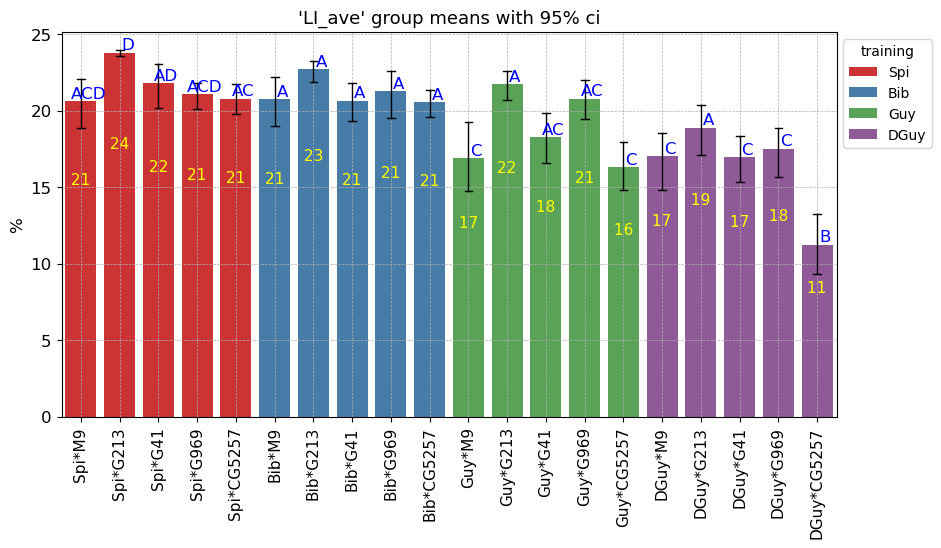

In [6]:
dataset = pd.read_excel(xlss_data_file, sheet_name='light_interception', skiprows=2)
dataset['LI_ave']=  dataset['LI_ave'] *100
display(dataset.head())

var_to_analyze = 'LI_ave'

dataset = dataset.dropna(subset=[var_to_analyze])

# ------------------ Perform ANOVA
model = ols(str(var_to_analyze +' ~ training * Rootstock'), data=dataset).fit()
anova_table = sm.stats.anova_lm(model, typ=3)
anova_df = pd.DataFrame(anova_table)
anova_df['Significance'] = anova_df['PR(>F)'].apply(assign_significance)

print('-------ANOVA TABLE-----------')
display(anova_df)

# Perform ANOVA and Tukey analysis (separate tests for training and Rootstock)
analysis_results = perform_tukey_analysis(dataset, var_to_analyze, anova_df)

# Plotting
df = analysis_results['df'] 
# display(df.head())
measure_unit = '%'
analysis_barplot_with_letters(df, var_to_analyze,measure_unit, round_unit=0)

## LAI Anova and Tukey

training Rootstock RecordType         DateandTime  Annotation  \
0     DGuy        M9        BLW  29/07/202512:16:53         NaN   
1     DGuy        M9        BLW  29/07/202512:17:05         NaN   
2     DGuy        M9        BLW  29/07/202512:17:13         NaN   
3     DGuy        M9        BLW  29/07/202512:17:49         NaN   
4     DGuy        M9        BLW  29/07/202512:18:03         NaN   

   AverageAbovePAR  AverageBelowPAR  Tau[Т]  LeafAreaIndex[LAI]  \
0           1295.7        1168.7750   0.335                1.91   
1            764.5         278.6625   0.335                1.91   
2            809.4         362.5750   0.335                1.91   
3           1630.5         322.3125   0.335                1.91   
4           1511.2         422.6000   0.335                1.91   

   LeafDistribution[χ]  ...         K       Tau  LAI_Corrected  \
0                    2  ...  0.755633  0.902041       0.143114   
1                    2  ...  0.755633  0.364503       1.400982   
2                    2  ...  0.755633  0.447955       1.114796   
3                    2  ...  0.755633  0.197677       2.250410   
4                    2  ...  0.755633  0.279645       1.768867   

   Lightintercepted(%)      test1      test2  LI0  LI2  LI3     LI_ave  
0             0.097959  90.204137  90.302095    0    0    0   2.448966  
1             0.635497  36.450294  37.085791    0    0    0  15.887426  
2             0.552045  44.795528  45.347572    0    0    0  13.801118  
3             0.802323  19.767709  20.570032    0    0    0  20.058073  
4             0.720355  27.964531  28.684886    0    0    0  18.008867  

[5 rows x 26 columns]

-------ANOVA TABLE-----------


sum_sq     df           F        PR(>F) Significance
Intercept            58.848181    1.0  131.112846  2.235308e-24          ***
training             25.482718    3.0   18.925035  5.096902e-11          ***
Rootstock             6.021480    4.0    3.353941  1.080042e-02            *
training:Rootstock   11.481897   12.0    2.131791  1.587033e-02            *
Residual            104.578815  233.0         NaN           NaN


-------TUKEY TEST FOR TRAINING-----------


{'Bib': 'A', 'DGuy': 'B', 'Guy': 'C', 'Spi': 'A'}


-------TRAINING MEANS WITH TUKEY LETTERS-----------


training  LAI_Corrected Letter
0      Bib       2.805764      A
1     DGuy       1.658448      B
2      Guy       2.153003      C
3      Spi       3.053201      A


-------TUKEY TEST FOR ROOTSTOCK-----------


{'CG5257': 'A', 'G213': 'B', 'G41': 'C', 'G969': 'C', 'M9': 'AC'}


-------ROOTSTOCK MEANS WITH TUKEY LETTERS-----------


Rootstock  LAI_Corrected Letter
0    CG5257       1.681617      A
1      G213       2.971324      B
2       G41       2.179748      C
3      G969       2.351532      C
4        M9       2.086010     AC


-------TUKEY TEST FOR TRAINING * ROOTSTOCK-----------


{'Bib*CG5257': 'A',
 'Bib*G213': 'A',
 'Bib*G41': 'A',
 'Bib*G969': 'A',
 'Bib*M9': 'A',
 'DGuy*CG5257': 'B',
 'DGuy*G213': 'C',
 'DGuy*G41': 'BC',
 'DGuy*G969': 'C',
 'DGuy*M9': 'C',
 'Guy*CG5257': 'BC',
 'Guy*G213': 'A',
 'Guy*G41': 'C',
 'Guy*G969': 'A',
 'Guy*M9': 'BC',
 'Spi*CG5257': 'A',
 'Spi*G213': 'D',
 'Spi*G41': 'A',
 'Spi*G969': 'A',
 'Spi*M9': 'A'}

-------GROUP (TRAINING * ROOTSTOCK)WITH TUKEY LETTERS-----------


training Rootstock  LAI_Corrected        Group Letter
0       Bib    CG5257       2.425864   Bib*CG5257      A
1       Bib      G213       3.424289     Bib*G213      A
2       Bib       G41       2.576165      Bib*G41      A
3       Bib      G969       2.907302     Bib*G969      A
4       Bib        M9       2.695197       Bib*M9      A
5      DGuy    CG5257       0.907930  DGuy*CG5257      B
6      DGuy      G213       2.162107    DGuy*G213      C
7      DGuy       G41       1.641747     DGuy*G41     BC
8      DGuy      G969       1.795226    DGuy*G969      C
9      DGuy        M9       1.713753      DGuy*M9      C
10      Guy    CG5257       1.499664   Guy*CG5257     BC
11      Guy      G213       2.959743     Guy*G213      A
12      Guy       G41       1.957703      Guy*G41      C
13      Guy      G969       2.648046     Guy*G969      A
14      Guy        M9       1.699862       Guy*M9     BC
15      Spi    CG5257       2.589326   Spi*CG5257      A
16      Spi      G213       4.229298     Spi*G213      D
17      Spi       G41       3.135178      Spi*G41      A
18      Spi      G969       2.667494     Spi*G969      A
19      Spi        M9       2.644711       Spi*M9      A

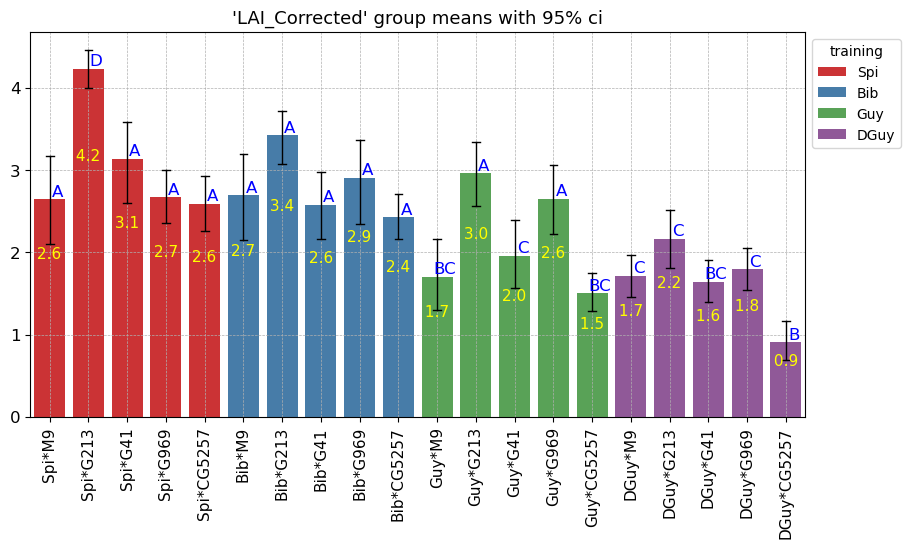

In [7]:
dataset = pd.read_excel(xlss_data_file, sheet_name='light_interception', skiprows=2)
dataset['LI_ave']=  dataset['LI_ave'] *100
display(dataset.head())

var_to_analyze = 'LAI_Corrected'

dataset = dataset.dropna(subset=[var_to_analyze])

# ------------------ Perform ANOVA
model = ols(str(var_to_analyze +' ~ training * Rootstock'), data=dataset).fit()
anova_table = sm.stats.anova_lm(model, typ=3)
anova_df = pd.DataFrame(anova_table)
anova_df['Significance'] = anova_df['PR(>F)'].apply(assign_significance)

print('-------ANOVA TABLE-----------')
display(anova_df)

# Perform ANOVA and Tukey analysis (separate tests for training and Rootstock)
analysis_results = perform_tukey_analysis(dataset, var_to_analyze, anova_df)

# Plotting
df = analysis_results['df'] 
# display(df.head())
measure_unit = ''
analysis_barplot_with_letters(df, var_to_analyze,measure_unit, round_unit=1)

# Yields e Production

## Cropload Anova and Tukey

year  inter-pole training  row  tree Rootstock  early_season_trunk1  \
0  2025           1     DGuy    2     2        M9                21.85   
1  2025           1     DGuy    2     3        M9                24.95   
2  2025           1     DGuy    2     4        M9                  NaN   
3  2025           2     DGuy    2     6      G213                23.77   
4  2025           2     DGuy    2     7      G213                28.06   

   early_season_trunk2  end_season_trunk1a  end_season_trunk1b  ...     kg  \
0                27.39               27.97               24.93  ...    NaN   
1                29.02               29.43               32.58  ...  19.22   
2                  NaN               25.54               23.85  ...  13.66   
3                29.79               29.44               29.19  ...  26.16   
4                39.55               35.81               36.91  ...  25.86   

   time/tree  tree/ha   Yield  yield_eff_2  avg_fruit_weight  harvest_time  \
0        NaN      NaN     NaN          NaN               NaN           NaN   
1       10.0   1600.0  30.752     2.264979        215.955056    266.666667   
2       10.0   1600.0  21.856     2.006713        168.641975    266.666667   
3       15.0   1600.0  41.856     2.765437        192.352941    400.000000   
4       15.0   1600.0  41.376     2.155353        160.621118    400.000000   

   VLIe  PLIe  VPLI  
0   NaN   NaN   NaN  
1   NaN   NaN   NaN  
2   NaN   NaN   NaN  
3   NaN   NaN   NaN  
4   NaN   NaN   NaN  

[5 rows x 36 columns]

-------ANOVA TABLE-----------


sum_sq    df         F    PR(>F) Significance
Intercept             337.500000   1.0  1.090550  0.299146             
training              494.780303   3.0  0.532921  0.660869             
Rootstock            9659.466667   4.0  7.803061  0.000019          ***
training:Rootstock  17102.724242  12.0  4.605278  0.000009          ***
Residual            27852.916667  90.0       NaN       NaN


-------TUKEY TEST FOR ROOTSTOCK-----------


{'CG5257': 'A', 'G213': 'B', 'G41': 'B', 'G969': 'B', 'M9': 'C'}


-------ROOTSTOCK MEANS WITH TUKEY LETTERS-----------


Rootstock   cropload Letter
0    CG5257  13.272727      A
1      G213  73.545455      B
2       G41  60.772727      B
3      G969  53.000000      B
4        M9  41.818182      C


-------TUKEY TEST FOR TRAINING * ROOTSTOCK-----------


{'Bib*CG5257': 'A',
 'Bib*G213': 'B',
 'Bib*G41': 'B',
 'Bib*G969': 'AB',
 'Bib*M9': 'AB',
 'DGuy*CG5257': 'A',
 'DGuy*G213': 'C',
 'DGuy*G41': 'C',
 'DGuy*G969': 'C',
 'DGuy*M9': 'D',
 'Guy*CG5257': 'A',
 'Guy*G213': 'D',
 'Guy*G41': 'D',
 'Guy*G969': 'BD',
 'Guy*M9': 'AB',
 'Spi*CG5257': 'A',
 'Spi*G213': 'AB',
 'Spi*G41': 'AB',
 'Spi*G969': 'A',
 'Spi*M9': 'A'}

-------GROUP (TRAINING * ROOTSTOCK)WITH TUKEY LETTERS-----------


training Rootstock    cropload        Group Letter
0       Bib    CG5257    7.500000   Bib*CG5257      A
1       Bib      G213   61.833333     Bib*G213      B
2       Bib       G41   48.333333      Bib*G41      B
3       Bib      G969   40.166667     Bib*G969     AB
4       Bib        M9   36.166667       Bib*M9     AB
5      DGuy    CG5257   18.750000  DGuy*CG5257      A
6      DGuy      G213  138.750000    DGuy*G213      C
7      DGuy       G41   96.750000     DGuy*G41      C
8      DGuy      G969  117.000000    DGuy*G969      C
9      DGuy        M9   86.000000      DGuy*M9      D
10      Guy    CG5257   18.000000   Guy*CG5257      A
11      Guy      G213   79.166667     Guy*G213      D
12      Guy       G41   82.666667      Guy*G41      D
13      Guy      G969   64.166667     Guy*G969     BD
14      Guy        M9   43.000000       Guy*M9     AB
15      Spi    CG5257   10.666667   Spi*CG5257      A
16      Spi      G213   36.166667     Spi*G213     AB
17      Spi       G41   27.333333      Spi*G41     AB
18      Spi      G969   12.000000     Spi*G969      A
19      Spi        M9   16.833333       Spi*M9      A

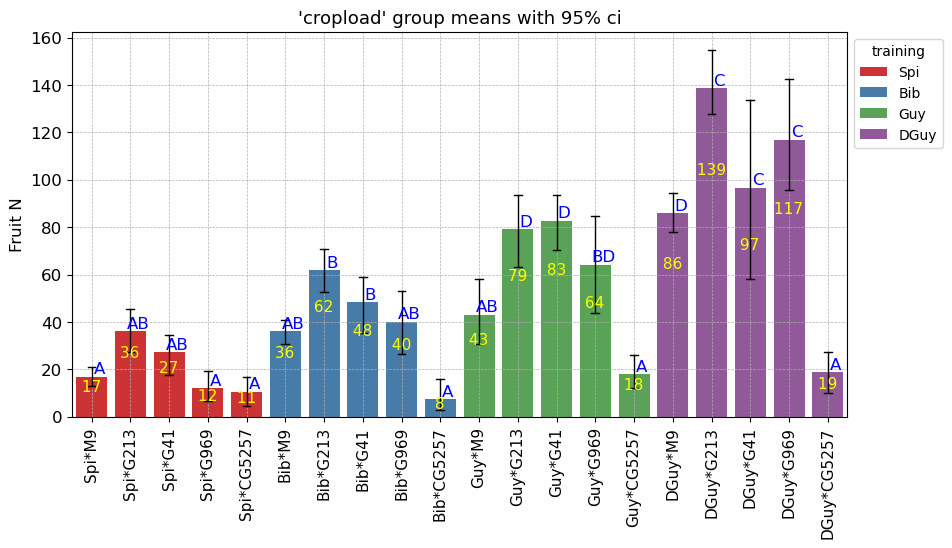

In [8]:
dataset = pd.read_excel(xlss_data_file, sheet_name='all_data', skiprows=1)
display(dataset.head())

var_to_analyze = 'cropload'

dataset = dataset.dropna(subset=[var_to_analyze])

# ------------------ Perform ANOVA
model = ols(str(var_to_analyze +' ~ training * Rootstock'), data=dataset).fit()
anova_table = sm.stats.anova_lm(model, typ=3)
anova_df = pd.DataFrame(anova_table)
anova_df['Significance'] = anova_df['PR(>F)'].apply(assign_significance)

print('-------ANOVA TABLE-----------')
display(anova_df)

# Perform ANOVA and Tukey analysis (separate tests for training and Rootstock)
analysis_results = perform_tukey_analysis(dataset, var_to_analyze, anova_df)

# Plotting
df = analysis_results['df'] 
# display(df.head())
measure_unit = 'Fruit N'
analysis_barplot_with_letters(df, var_to_analyze,measure_unit, round_unit=0)

## Production (Kg/tree) Anova and Tukey

year  inter-pole training  row  tree Rootstock  early_season_trunk1  \
0  2025           1     DGuy    2     2        M9                21.85   
1  2025           1     DGuy    2     3        M9                24.95   
2  2025           1     DGuy    2     4        M9                  NaN   
3  2025           2     DGuy    2     6      G213                23.77   
4  2025           2     DGuy    2     7      G213                28.06   

   early_season_trunk2  end_season_trunk1a  end_season_trunk1b  ...     kg  \
0                27.39               27.97               24.93  ...    NaN   
1                29.02               29.43               32.58  ...  19.22   
2                  NaN               25.54               23.85  ...  13.66   
3                29.79               29.44               29.19  ...  26.16   
4                39.55               35.81               36.91  ...  25.86   

   time/tree  tree/ha   Yield  yield_eff_2  avg_fruit_weight  harvest_time  \
0        NaN      NaN     NaN          NaN               NaN           NaN   
1       10.0   1600.0  30.752     2.264979        215.955056    266.666667   
2       10.0   1600.0  21.856     2.006713        168.641975    266.666667   
3       15.0   1600.0  41.856     2.765437        192.352941    400.000000   
4       15.0   1600.0  41.376     2.155353        160.621118    400.000000   

   VLIe  PLIe  VPLI  
0   NaN   NaN   NaN  
1   NaN   NaN   NaN  
2   NaN   NaN   NaN  
3   NaN   NaN   NaN  
4   NaN   NaN   NaN  

[5 rows x 36 columns]

-------ANOVA TABLE-----------


sum_sq    df         F    PR(>F) Significance
Intercept            11.316267   1.0  1.254023  0.265765             
training              8.765382   3.0  0.323782  0.808153             
Rootstock           315.969413   4.0  8.753616  0.000005          ***
training:Rootstock  455.225033  12.0  4.203851  0.000031          ***
Residual            812.157108  90.0       NaN       NaN


-------TUKEY TEST FOR ROOTSTOCK-----------


{'CG5257': 'A', 'G213': 'B', 'G41': 'B', 'G969': 'C', 'M9': 'C'}


-------ROOTSTOCK MEANS WITH TUKEY LETTERS-----------


Rootstock         kg Letter
0    CG5257   2.139091      A
1      G213  13.120909      B
2       G41  10.841364      B
3      G969   8.446364      C
4        M9   8.008182      C


-------TUKEY TEST FOR TRAINING * ROOTSTOCK-----------


{'Bib*CG5257': 'A',
 'Bib*G213': 'B',
 'Bib*G41': 'B',
 'Bib*G969': 'AB',
 'Bib*M9': 'AB',
 'DGuy*CG5257': 'A',
 'DGuy*G213': 'C',
 'DGuy*G41': 'C',
 'DGuy*G969': 'C',
 'DGuy*M9': 'D',
 'Guy*CG5257': 'A',
 'Guy*G213': 'D',
 'Guy*G41': 'D',
 'Guy*G969': 'BD',
 'Guy*M9': 'AB',
 'Spi*CG5257': 'A',
 'Spi*G213': 'AB',
 'Spi*G41': 'AB',
 'Spi*G969': 'A',
 'Spi*M9': 'A'}

-------GROUP (TRAINING * ROOTSTOCK)WITH TUKEY LETTERS-----------


training Rootstock         kg        Group Letter
0       Bib    CG5257   1.373333   Bib*CG5257      A
1       Bib      G213  11.043333     Bib*G213      B
2       Bib       G41   9.050000      Bib*G41      B
3       Bib      G969   6.486667     Bib*G969     AB
4       Bib        M9   7.473333       Bib*M9     AB
5      DGuy    CG5257   2.800000  DGuy*CG5257      A
6      DGuy      G213  24.070000    DGuy*G213      C
7      DGuy       G41  16.717500     DGuy*G41      C
8      DGuy      G969  18.170000    DGuy*G969      C
9      DGuy        M9  16.165000      DGuy*M9      D
10      Guy    CG5257   2.816667   Guy*CG5257      A
11      Guy      G213  14.036667     Guy*G213      D
12      Guy       G41  13.843333      Guy*G41      D
13      Guy      G969  10.083333     Guy*G969     BD
14      Guy        M9   7.433333       Guy*M9     AB
15      Spi    CG5257   1.786667   Spi*CG5257      A
16      Spi      G213   6.983333     Spi*G213     AB
17      Spi       G41   5.713333      Spi*G41     AB
18      Spi      G969   2.286667     Spi*G969      A
19      Spi        M9   3.680000       Spi*M9      A

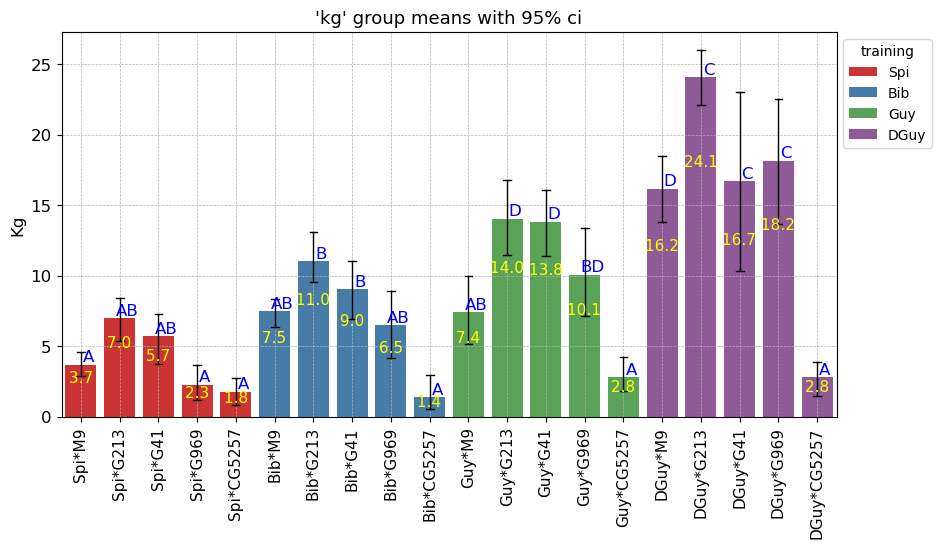

In [9]:
dataset = pd.read_excel(xlss_data_file, sheet_name='all_data', skiprows=1)
display(dataset.head())

var_to_analyze = 'kg'

dataset = dataset.dropna(subset=[var_to_analyze])

# ------------------ Perform ANOVA
model = ols(str(var_to_analyze +' ~ training * Rootstock'), data=dataset).fit()
anova_table = sm.stats.anova_lm(model, typ=3)
anova_df = pd.DataFrame(anova_table)
anova_df['Significance'] = anova_df['PR(>F)'].apply(assign_significance)

print('-------ANOVA TABLE-----------')
display(anova_df)

# Perform ANOVA and Tukey analysis (separate tests for training and Rootstock)
analysis_results = perform_tukey_analysis(dataset, var_to_analyze, anova_df)

# Plotting
df = analysis_results['df'] 
# display(df.head())
measure_unit = 'Kg'
analysis_barplot_with_letters(df, var_to_analyze,measure_unit, round_unit=1)

## Yields (ton/ha) Anova and Tukey

year  inter-pole training  row  tree Rootstock  early_season_trunk1  \
0  2025           1     DGuy    2     2        M9                21.85   
1  2025           1     DGuy    2     3        M9                24.95   
2  2025           1     DGuy    2     4        M9                  NaN   
3  2025           2     DGuy    2     6      G213                23.77   
4  2025           2     DGuy    2     7      G213                28.06   

   early_season_trunk2  end_season_trunk1a  end_season_trunk1b  ...     kg  \
0                27.39               27.97               24.93  ...    NaN   
1                29.02               29.43               32.58  ...  19.22   
2                  NaN               25.54               23.85  ...  13.66   
3                29.79               29.44               29.19  ...  26.16   
4                39.55               35.81               36.91  ...  25.86   

   time/tree  tree/ha   Yield  yield_eff_2  avg_fruit_weight  harvest_time  \
0        NaN      NaN     NaN          NaN               NaN           NaN   
1       10.0   1600.0  30.752     2.264979        215.955056    266.666667   
2       10.0   1600.0  21.856     2.006713        168.641975    266.666667   
3       15.0   1600.0  41.856     2.765437        192.352941    400.000000   
4       15.0   1600.0  41.376     2.155353        160.621118    400.000000   

   VLIe  PLIe  VPLI  
0   NaN   NaN   NaN  
1   NaN   NaN   NaN  
2   NaN   NaN   NaN  
3   NaN   NaN   NaN  
4   NaN   NaN   NaN  

[5 rows x 36 columns]

-------ANOVA TABLE-----------


sum_sq    df          F        PR(>F) Significance
Intercept            144.305497   1.0   2.205262  1.410348e-01             
training              38.257392   3.0   0.194882  8.996353e-01             
Rootstock           4029.254914   4.0  15.393666  1.252661e-09          ***
training:Rootstock  1285.672620  12.0   1.637293  9.524475e-02            ~
Residual            5889.320714  90.0        NaN           NaN


-------TUKEY TEST FOR ROOTSTOCK-----------


{'CG5257': 'A', 'G213': 'B', 'G41': 'B', 'G969': 'C', 'M9': 'C'}


-------ROOTSTOCK MEANS WITH TUKEY LETTERS-----------


Rootstock      Yield Letter
0    CG5257   6.165472      A
1      G213  35.646273      B
2       G41  30.028876      B
3      G969  21.451994      C
4        M9  21.434291      C


-------TUKEY TEST FOR TRAINING * ROOTSTOCK-----------


{'Bib*CG5257': 'A',
 'Bib*G213': 'B',
 'Bib*G41': 'B',
 'Bib*G969': 'B',
 'Bib*M9': 'B',
 'DGuy*CG5257': 'A',
 'DGuy*G213': 'B',
 'DGuy*G41': 'B',
 'DGuy*G969': 'B',
 'DGuy*M9': 'B',
 'Guy*CG5257': 'A',
 'Guy*G213': 'B',
 'Guy*G41': 'B',
 'Guy*G969': 'B',
 'Guy*M9': 'A',
 'Spi*CG5257': 'A',
 'Spi*G213': 'B',
 'Spi*G41': 'B',
 'Spi*G969': 'A',
 'Spi*M9': 'A'}

-------GROUP (TRAINING * ROOTSTOCK)WITH TUKEY LETTERS-----------


training Rootstock      Yield        Group Letter
0       Bib    CG5257   4.904173   Bib*CG5257      A
1       Bib      G213  39.435743     Bib*G213      B
2       Bib       G41  32.317550      Bib*G41      B
3       Bib      G969  23.163887     Bib*G969      B
4       Bib        M9  26.687273       Bib*M9      B
5      DGuy    CG5257   4.480000  DGuy*CG5257      A
6      DGuy      G213  38.512000    DGuy*G213      B
7      DGuy       G41  26.748000     DGuy*G41      B
8      DGuy      G969  29.072000    DGuy*G969      B
9      DGuy        M9  25.864000      DGuy*M9      B
10      Guy    CG5257   7.512050   Guy*CG5257      A
11      Guy      G213  37.435790     Guy*G213      B
12      Guy       G41  36.920170      Guy*G41      B
13      Guy      G969  26.892250     Guy*G969      B
14      Guy        M9  19.824700       Guy*M9      A
15      Spi    CG5257   7.203840   Spi*CG5257      A
16      Spi      G213  28.156800     Spi*G213      B
17      Spi       G41  23.036160      Spi*G41      B
18      Spi      G969   9.219840     Spi*G969      A
19      Spi        M9  14.837760       Spi*M9      A

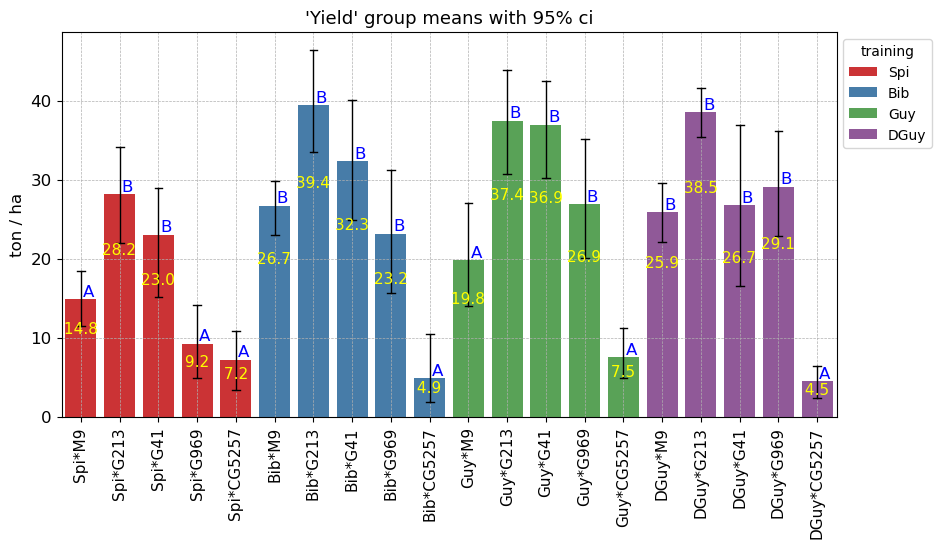

In [10]:
dataset = pd.read_excel(xlss_data_file, sheet_name='all_data', skiprows=1)
display(dataset.head())

var_to_analyze = 'Yield'

dataset = dataset.dropna(subset=[var_to_analyze])

# ------------------ Perform ANOVA
model = ols(str(var_to_analyze +' ~ training * Rootstock'), data=dataset).fit()
anova_table = sm.stats.anova_lm(model, typ=3)
anova_df = pd.DataFrame(anova_table)
anova_df['Significance'] = anova_df['PR(>F)'].apply(assign_significance)

print('-------ANOVA TABLE-----------')
display(anova_df)

# Perform ANOVA and Tukey analysis (separate tests for training and Rootstock)
analysis_results = perform_tukey_analysis(dataset, var_to_analyze, anova_df)

# Plotting
df = analysis_results['df'] 
# display(df.head())
measure_unit = 'ton / ha'
analysis_barplot_with_letters(df, var_to_analyze,measure_unit, round_unit=1)

## Yield Efficiency (kgTree/TCSA)

### Yield efficiency tcsa 2

year  inter-pole training  row  tree Rootstock  early_season_trunk1  \
0  2025           1     DGuy    2     2        M9                21.85   
1  2025           1     DGuy    2     3        M9                24.95   
2  2025           1     DGuy    2     4        M9                  NaN   
3  2025           2     DGuy    2     6      G213                23.77   
4  2025           2     DGuy    2     7      G213                28.06   

   early_season_trunk2  end_season_trunk1a  end_season_trunk1b  ...     kg  \
0                27.39               27.97               24.93  ...    NaN   
1                29.02               29.43               32.58  ...  19.22   
2                  NaN               25.54               23.85  ...  13.66   
3                29.79               29.44               29.19  ...  26.16   
4                39.55               35.81               36.91  ...  25.86   

   time/tree  tree/ha   Yield  yield_eff_2  avg_fruit_weight  harvest_time  \
0        NaN      NaN     NaN          NaN               NaN           NaN   
1       10.0   1600.0  30.752     2.264979        215.955056    266.666667   
2       10.0   1600.0  21.856     2.006713        168.641975    266.666667   
3       15.0   1600.0  41.856     2.765437        192.352941    400.000000   
4       15.0   1600.0  41.376     2.155353        160.621118    400.000000   

   VLIe  PLIe  VPLI  
0   NaN   NaN   NaN  
1   NaN   NaN   NaN  
2   NaN   NaN   NaN  
3   NaN   NaN   NaN  
4   NaN   NaN   NaN  

[5 rows x 36 columns]

-------ANOVA TABLE-----------


sum_sq    df          F        PR(>F) Significance
Intercept           0.438862   1.0   4.140789  4.501512e-02            *
training            0.159504   3.0   0.501656  6.821622e-01             
Rootstock           5.983594   4.0  14.114218  7.504807e-09          ***
training:Rootstock  5.656797  12.0   4.447788  1.755009e-05          ***
Residual            8.902758  84.0        NaN           NaN


-------TUKEY TEST FOR ROOTSTOCK-----------


{'CG5257': 'A', 'G213': 'B', 'G41': 'B', 'G969': 'AB', 'M9': 'B'}


-------ROOTSTOCK MEANS WITH TUKEY LETTERS-----------


Rootstock  yield_eff_2 Letter
0    CG5257     0.308284      A
1      G213     1.339739      B
2       G41     1.186505      B
3      G969     0.840066     AB
4        M9     0.999510      B


-------TUKEY TEST FOR TRAINING * ROOTSTOCK-----------


{'Bib*CG5257': 'A',
 'Bib*G213': 'B',
 'Bib*G41': 'B',
 'Bib*G969': 'AB',
 'Bib*M9': 'B',
 'DGuy*CG5257': 'A',
 'DGuy*G213': 'C',
 'DGuy*G41': 'C',
 'DGuy*G969': 'C',
 'DGuy*M9': 'C',
 'Guy*CG5257': 'A',
 'Guy*G213': 'A',
 'Guy*G41': 'B',
 'Guy*G969': 'A',
 'Guy*M9': 'A',
 'Spi*CG5257': 'A',
 'Spi*G213': 'A',
 'Spi*G41': 'A',
 'Spi*G969': 'A',
 'Spi*M9': 'A'}

-------GROUP (TRAINING * ROOTSTOCK)WITH TUKEY LETTERS-----------


training Rootstock  yield_eff_2        Group Letter
0       Bib    CG5257     0.270451   Bib*CG5257      A
1       Bib      G213     1.638979     Bib*G213      B
2       Bib       G41     1.304642      Bib*G41      B
3       Bib      G969     0.889587     Bib*G969     AB
4       Bib        M9     1.186002       Bib*M9      B
5      DGuy    CG5257     0.476225  DGuy*CG5257      A
6      DGuy      G213     2.643666    DGuy*G213      C
7      DGuy       G41     2.108328     DGuy*G41      C
8      DGuy      G969     1.943926    DGuy*G969      C
9      DGuy        M9     1.916827      DGuy*M9      C
10      Guy    CG5257     0.306887   Guy*CG5257      A
11      Guy      G213     0.791726     Guy*G213      A
12      Guy       G41     1.156668      Guy*G41      B
13      Guy      G969     0.692813     Guy*G969      A
14      Guy        M9     0.801584       Guy*M9      A
15      Spi    CG5257     0.221005   Spi*CG5257      A
16      Spi      G213     0.586428     Spi*G213      A
17      Spi       G41     0.483657      Spi*G41      A
18      Spi      G969     0.218397     Spi*G969      A
19      Spi        M9     0.399398       Spi*M9      A

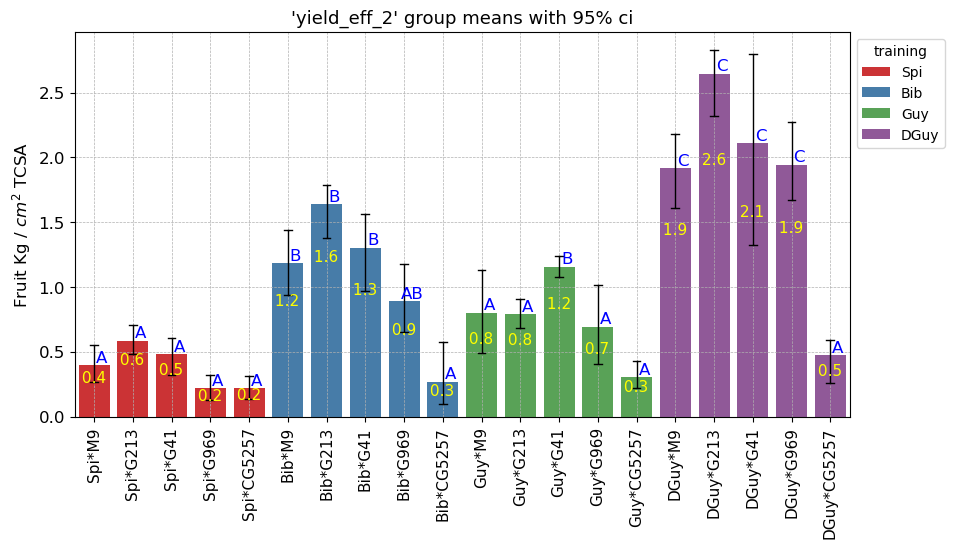

In [11]:
dataset = pd.read_excel(xlss_data_file, sheet_name='all_data', skiprows=1)
display(dataset.head())

var_to_analyze = 'yield_eff_2'

dataset = dataset.dropna(subset=[var_to_analyze])

# ------------------ Perform ANOVA
model = ols(str(var_to_analyze +' ~ training * Rootstock'), data=dataset).fit()
anova_table = sm.stats.anova_lm(model, typ=3)
anova_df = pd.DataFrame(anova_table)
anova_df['Significance'] = anova_df['PR(>F)'].apply(assign_significance)

print('-------ANOVA TABLE-----------')
display(anova_df)

# Perform ANOVA and Tukey analysis (separate tests for training and Rootstock)
analysis_results = perform_tukey_analysis(dataset, var_to_analyze, anova_df)

# Plotting
df = analysis_results['df'] 
# display(df.head())
measure_unit = 'Fruit Kg / ${cm}^2$ TCSA'
analysis_barplot_with_letters(df, var_to_analyze,measure_unit, round_unit=1)

# Fuit Quality

## Fruit Size Anova e Tukey

year training Rootstock  nr.fruit  diameter1  diameter2   diam  height  \
0  2025      Spi      G969         1      76.07      70.89  76.07   64.98   
1  2025      Spi      G969         2      73.39      73.51  73.51   61.69   
2  2025      Spi      G969         3      76.85      74.20  76.85   64.00   
3  2025      Spi      G969         4      75.55      72.29  75.55   62.62   
4  2025      Spi      G969         5      77.20      74.77  77.20   69.87   

   weight  color_cover   SSC  DA_Index  SDI   L   a   b   C  Hue  Firmness  
0  184.46         80.0  12.8    0.2787  5.0 NaN NaN NaN NaN  NaN       NaN  
1  181.17         60.0  12.5    0.6124  2.0 NaN NaN NaN NaN  NaN       NaN  
2  192.80        100.0  14.9    0.9112  3.0 NaN NaN NaN NaN  NaN       NaN  
3  172.58         80.0  14.7    0.2109  5.0 NaN NaN NaN NaN  NaN       NaN  
4  206.32         80.0  12.6    0.1973  6.0 NaN NaN NaN NaN  NaN       NaN

-------ANOVA TABLE-----------


sum_sq     df            F         PR(>F)  \
Intercept           79267.718427    1.0  4768.695134  7.035850e-178   
training               46.703660    3.0     0.936554   4.233946e-01   
Rootstock             449.602512    4.0     6.761950   3.297617e-05   
training:Rootstock    483.164887   12.0     2.422241   5.271925e-03   
Residual             4654.304907  280.0          NaN            NaN   

                   Significance  
Intercept                   ***  
training                         
Rootstock                   ***  
training:Rootstock           **  
Residual


-------TUKEY TEST FOR ROOTSTOCK-----------


{'CG5257': 'A', 'G213': 'B', 'G41': 'B', 'G969': 'A', 'M9': 'C'}


-------ROOTSTOCK MEANS WITH TUKEY LETTERS-----------


Rootstock       diam Letter
0    CG5257  73.418333      A
1      G213  76.111000      B
2       G41  76.511667      B
3      G969  73.942500      A
4        M9  78.736167      C


-------TUKEY TEST FOR TRAINING * ROOTSTOCK-----------


{'Bib*CG5257': 'A',
 'Bib*G213': 'A',
 'Bib*G41': 'A',
 'Bib*G969': 'A',
 'Bib*M9': 'B',
 'DGuy*CG5257': 'A',
 'DGuy*G213': 'AB',
 'DGuy*G41': 'AB',
 'DGuy*G969': 'C',
 'DGuy*M9': 'ABC',
 'Guy*CG5257': 'AC',
 'Guy*G213': 'AB',
 'Guy*G41': 'AC',
 'Guy*G969': 'AC',
 'Guy*M9': 'B',
 'Spi*CG5257': 'AC',
 'Spi*G213': 'ABC',
 'Spi*G41': 'B',
 'Spi*G969': 'AB',
 'Spi*M9': 'D'}

-------GROUP (TRAINING * ROOTSTOCK)WITH TUKEY LETTERS-----------


training Rootstock       diam        Group Letter
0       Bib    CG5257  72.694667   Bib*CG5257      A
1       Bib      G213  76.683333     Bib*G213      A
2       Bib       G41  76.245333      Bib*G41      A
3       Bib      G969  75.838667     Bib*G969      A
4       Bib        M9  80.378667       Bib*M9      B
5      DGuy    CG5257  72.636667  DGuy*CG5257      A
6      DGuy      G213  75.109333    DGuy*G213     AB
7      DGuy       G41  77.631333     DGuy*G41     AB
8      DGuy      G969  70.597333    DGuy*G969      C
9      DGuy        M9  75.597333      DGuy*M9    ABC
10      Guy    CG5257  73.520667   Guy*CG5257     AC
11      Guy      G213  76.986667     Guy*G213     AB
12      Guy       G41  73.842667      Guy*G41     AC
13      Guy      G969  72.592000     Guy*G969     AC
14      Guy        M9  78.426000       Guy*M9      B
15      Spi    CG5257  74.821333   Spi*CG5257     AC
16      Spi      G213  75.664667     Spi*G213    ABC
17      Spi       G41  78.327333      Spi*G41      B
18      Spi      G969  76.742000     Spi*G969     AB
19      Spi        M9  80.542667       Spi*M9      D

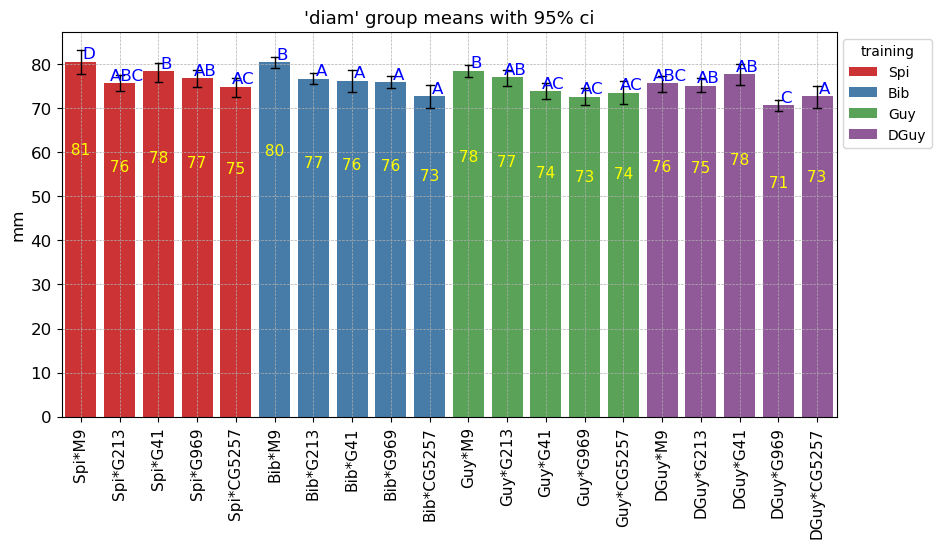

In [12]:
dataset = pd.read_excel(xlss_data_file, sheet_name='fruit_quality', skiprows=1)
display(dataset.head())

var_to_analyze = 'diam'

dataset = dataset.dropna(subset=[var_to_analyze])

# ------------------ Perform ANOVA
model = ols(str(var_to_analyze +' ~ training * Rootstock'), data=dataset).fit()
anova_table = sm.stats.anova_lm(model, typ=3)
anova_df = pd.DataFrame(anova_table)
anova_df['Significance'] = anova_df['PR(>F)'].apply(assign_significance)

print('-------ANOVA TABLE-----------')
display(anova_df)

# Perform ANOVA and Tukey analysis (separate tests for training and Rootstock)
analysis_results = perform_tukey_analysis(dataset, var_to_analyze, anova_df)

# Plotting
df = analysis_results['df'] 
# display(df.head())
measure_unit = 'mm'
analysis_barplot_with_letters(df, var_to_analyze,measure_unit, round_unit=0)

## Fruit Weight Anova e Tukey

year training Rootstock  nr.fruit  diameter1  diameter2   diam  height  \
0  2025      Spi      G969         1      76.07      70.89  76.07   64.98   
1  2025      Spi      G969         2      73.39      73.51  73.51   61.69   
2  2025      Spi      G969         3      76.85      74.20  76.85   64.00   
3  2025      Spi      G969         4      75.55      72.29  75.55   62.62   
4  2025      Spi      G969         5      77.20      74.77  77.20   69.87   

   weight  color_cover   SSC  DA_Index  SDI   L   a   b   C  Hue  Firmness  
0  184.46         80.0  12.8    0.2787  5.0 NaN NaN NaN NaN  NaN       NaN  
1  181.17         60.0  12.5    0.6124  2.0 NaN NaN NaN NaN  NaN       NaN  
2  192.80        100.0  14.9    0.9112  3.0 NaN NaN NaN NaN  NaN       NaN  
3  172.58         80.0  14.7    0.2109  5.0 NaN NaN NaN NaN  NaN       NaN  
4  206.32         80.0  12.6    0.1973  6.0 NaN NaN NaN NaN  NaN       NaN

-------ANOVA TABLE-----------


sum_sq     df           F        PR(>F)  \
Intercept           458545.874460    1.0  479.093609  1.373387e-62   
training              1979.300087    3.0    0.689331  5.592166e-01   
Rootstock            28145.355915    4.0    7.351642  1.212005e-05   
training:Rootstock   33024.370771   12.0    2.875351  9.300678e-04   
Residual            267991.145240  280.0         NaN           NaN   

                   Significance  
Intercept                   ***  
training                         
Rootstock                   ***  
training:Rootstock          ***  
Residual


-------TUKEY TEST FOR ROOTSTOCK-----------


{'CG5257': 'A', 'G213': 'B', 'G41': 'B', 'G969': 'A', 'M9': 'C'}


-------ROOTSTOCK MEANS WITH TUKEY LETTERS-----------


Rootstock      weight Letter
0    CG5257  179.763667      A
1      G213  200.839500      B
2       G41  206.606833      B
3      G969  184.069000      A
4        M9  221.787833      C


-------TUKEY TEST FOR TRAINING * ROOTSTOCK-----------


{'Bib*CG5257': 'A',
 'Bib*G213': 'A',
 'Bib*G41': 'A',
 'Bib*G969': 'A',
 'Bib*M9': 'B',
 'DGuy*CG5257': 'A',
 'DGuy*G213': 'A',
 'DGuy*G41': 'B',
 'DGuy*G969': 'C',
 'DGuy*M9': 'ABC',
 'Guy*CG5257': 'AC',
 'Guy*G213': 'AB',
 'Guy*G41': 'AC',
 'Guy*G969': 'AC',
 'Guy*M9': 'B',
 'Spi*CG5257': 'AC',
 'Spi*G213': 'AB',
 'Spi*G41': 'B',
 'Spi*G969': 'AB',
 'Spi*M9': 'D'}

-------GROUP (TRAINING * ROOTSTOCK)WITH TUKEY LETTERS-----------


training Rootstock      weight        Group Letter
0       Bib    CG5257  174.842000   Bib*CG5257      A
1       Bib      G213  205.168667     Bib*G213      A
2       Bib       G41  212.401333      Bib*G41      A
3       Bib      G969  206.046000     Bib*G969      A
4       Bib        M9  235.443333       Bib*M9      B
5      DGuy    CG5257  178.227333  DGuy*CG5257      A
6      DGuy      G213  191.022667    DGuy*G213      A
7      DGuy       G41  216.363333     DGuy*G41      B
8      DGuy      G969  157.651333    DGuy*G969      C
9      DGuy        M9  196.817333      DGuy*M9    ABC
10      Guy    CG5257  176.492000   Guy*CG5257     AC
11      Guy      G213  208.478000     Guy*G213     AB
12      Guy       G41  180.945333      Guy*G41     AC
13      Guy      G969  172.025333     Guy*G969     AC
14      Guy        M9  216.522000       Guy*M9      B
15      Spi    CG5257  189.493333   Spi*CG5257     AC
16      Spi      G213  198.688667     Spi*G213     AB
17      Spi       G41  216.717333      Spi*G41      B
18      Spi      G969  200.553333     Spi*G969     AB
19      Spi        M9  238.368667       Spi*M9      D

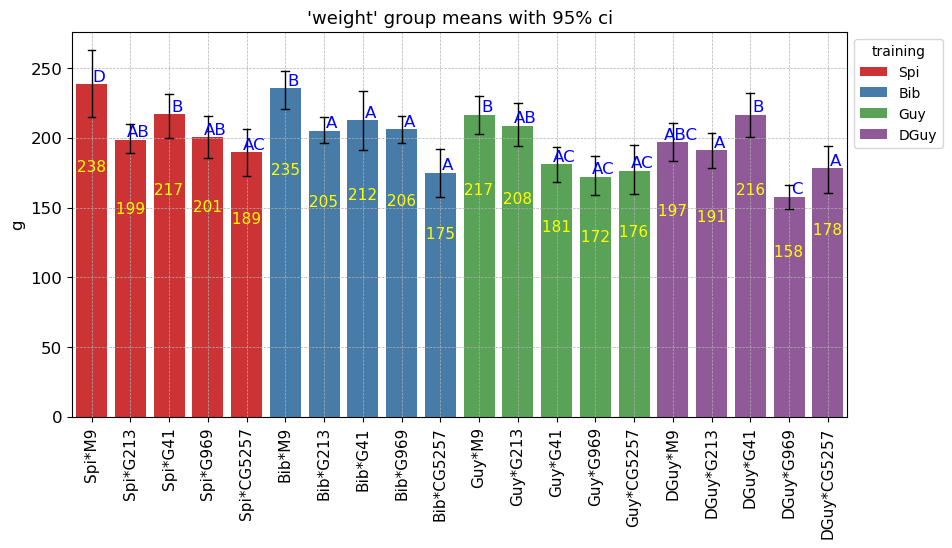

In [13]:
dataset = pd.read_excel(xlss_data_file, sheet_name='fruit_quality', skiprows=1)
display(dataset.head())

var_to_analyze = 'weight'

dataset = dataset.dropna(subset=[var_to_analyze])

# ------------------ Perform ANOVA
model = ols(str(var_to_analyze +' ~ training * Rootstock'), data=dataset).fit()
anova_table = sm.stats.anova_lm(model, typ=3)
anova_df = pd.DataFrame(anova_table)
anova_df['Significance'] = anova_df['PR(>F)'].apply(assign_significance)

print('-------ANOVA TABLE-----------')
display(anova_df)

# Perform ANOVA and Tukey analysis (separate tests for training and Rootstock)
analysis_results = perform_tukey_analysis(dataset, var_to_analyze, anova_df)

# Plotting
df = analysis_results['df'] 
# display(df.head())
measure_unit = 'g'
analysis_barplot_with_letters(df, var_to_analyze,measure_unit, round_unit=0)

### Size - Weight Regression

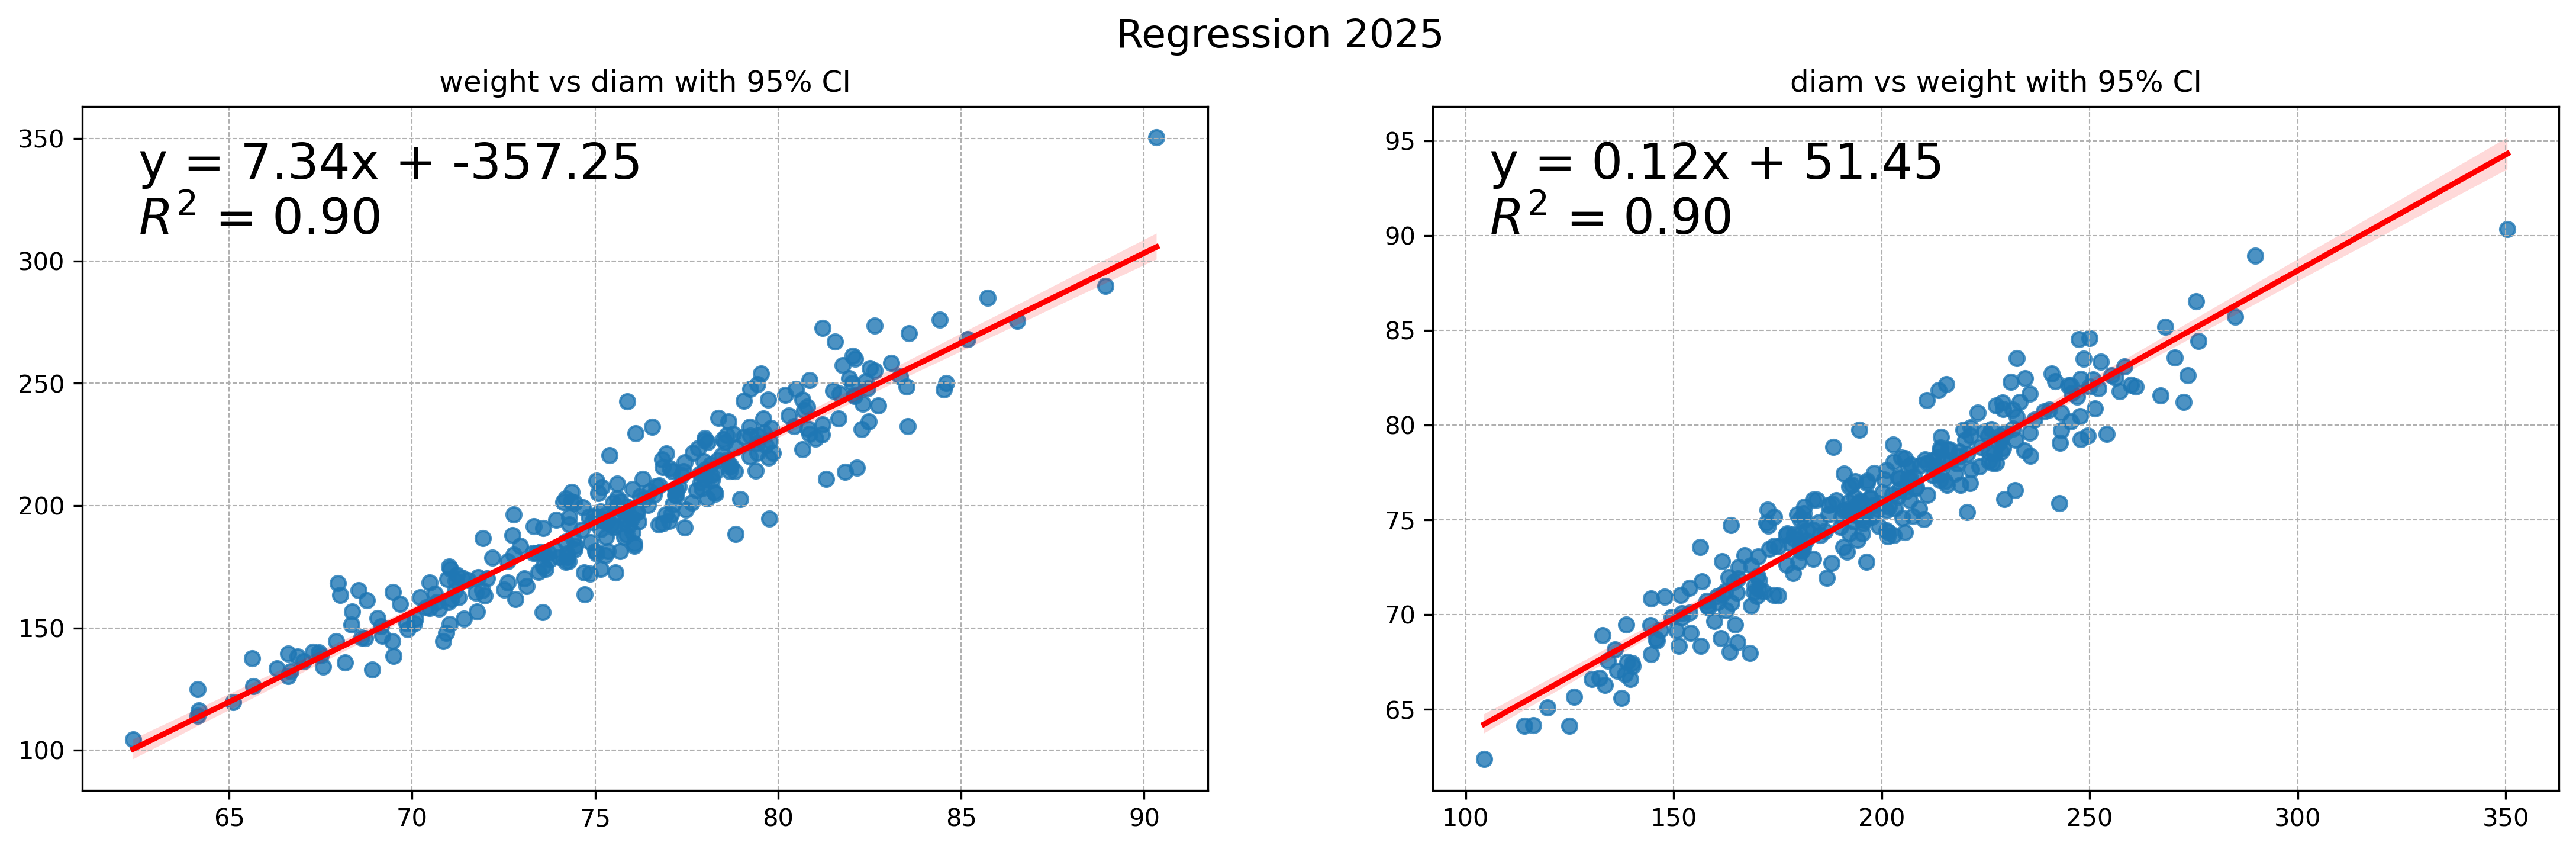

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats

# Assuming df and var_to_analyze are already defined
# df = ... (your DataFrame)
# var_to_analyze = ... (your variable to analyze)

# Prepare the data for plot 1
X1 = df['diam'].values
y1 = df[var_to_analyze].values

# Perform linear regression using scipy for plot 1
slope1, intercept1, r_value1, p_value1, std_err1 = stats.linregress(X1, y1)

# Prepare the data for plot 2
X2 = df[var_to_analyze].values
y2 = df['diam'].values

# Perform linear regression using scipy for plot 2
slope2, intercept2, r_value2, p_value2, std_err2 = stats.linregress(X2, y2)

# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(18, 5), dpi=300)

# Plot 1: X = df['diam'].values and y = df[var_to_analyze].values
sns.regplot(ax=axes[0], x=X1, y=y1, ci=95, line_kws={"color": "red"})
axes[0].set_title(f"{var_to_analyze} vs diam with 95% CI")
axes[0].text(0.05, 0.95, f'y = {slope1:.2f}x + {intercept1:.2f}\n$R^2$ = {(r_value1)**2:.2f}',
             transform=axes[0].transAxes,
             fontsize=20,
             verticalalignment='top')
axes[0].grid(which='both', linestyle='--', linewidth=0.5)

# Plot 2: y = df['diam'].values and X = df[var_to_analyze].values
sns.regplot(ax=axes[1], x=X2, y=y2, ci=95, line_kws={"color": "red"})
axes[1].set_title(f"diam vs {var_to_analyze} with 95% CI")
axes[1].text(0.05, 0.95, f'y = {slope2:.2f}x + {intercept2:.2f}\n$R^2$ = {r_value2**2:.2f}',
             transform=axes[1].transAxes,
             fontsize=20,
             verticalalignment='top')
axes[1].grid(which='both', linestyle='--', linewidth=0.5)
plt.suptitle(f'Regression 2025', fontsize=16)
plt.show()


## Brix


year training Rootstock  nr.fruit  diameter1  diameter2   diam  height  \
0  2025      Spi      G969         1      76.07      70.89  76.07   64.98   
1  2025      Spi      G969         2      73.39      73.51  73.51   61.69   
2  2025      Spi      G969         3      76.85      74.20  76.85   64.00   
3  2025      Spi      G969         4      75.55      72.29  75.55   62.62   
4  2025      Spi      G969         5      77.20      74.77  77.20   69.87   

   weight  color_cover   SSC  DA_Index  SDI   L   a   b   C  Hue  Firmness  
0  184.46         80.0  12.8    0.2787  5.0 NaN NaN NaN NaN  NaN       NaN  
1  181.17         60.0  12.5    0.6124  2.0 NaN NaN NaN NaN  NaN       NaN  
2  192.80        100.0  14.9    0.9112  3.0 NaN NaN NaN NaN  NaN       NaN  
3  172.58         80.0  14.7    0.2109  5.0 NaN NaN NaN NaN  NaN       NaN  
4  206.32         80.0  12.6    0.1973  6.0 NaN NaN NaN NaN  NaN       NaN

-------ANOVA TABLE-----------


sum_sq     df            F         PR(>F)  \
Intercept           3229.600667    1.0  2339.999655  5.524380e-138   
training              19.512667    3.0     4.712619   3.165132e-03   
Rootstock             13.228533    4.0     2.396176   5.062142e-02   
training:Rootstock    41.048800   12.0     2.478484   4.270044e-03   
Residual             386.448000  280.0          NaN            NaN   

                   Significance  
Intercept                   ***  
training                     **  
Rootstock                     ~  
training:Rootstock           **  
Residual


-------TUKEY TEST FOR TRAINING-----------


{'Bib': 'A', 'DGuy': 'B', 'Guy': 'B', 'Spi': 'B'}


-------TRAINING MEANS WITH TUKEY LETTERS-----------


training        SSC Letter
0      Bib  14.428000      A
1     DGuy  13.913333      B
2      Guy  13.789333      B
3      Spi  13.729333      B


-------TUKEY TEST FOR ROOTSTOCK-----------


{'CG5257': 'A', 'G213': 'A', 'G41': 'A', 'G969': 'A', 'M9': 'A'}


-------ROOTSTOCK MEANS WITH TUKEY LETTERS-----------


Rootstock        SSC Letter
0    CG5257  13.910000      A
1      G213  14.146667      A
2       G41  14.096667      A
3      G969  13.830000      A
4        M9  13.841667      A


-------TUKEY TEST FOR TRAINING * ROOTSTOCK-----------


{'Bib*CG5257': 'A',
 'Bib*G213': 'A',
 'Bib*G41': 'A',
 'Bib*G969': 'A',
 'Bib*M9': 'A',
 'DGuy*CG5257': 'A',
 'DGuy*G213': 'A',
 'DGuy*G41': 'A',
 'DGuy*G969': 'B',
 'DGuy*M9': 'AB',
 'Guy*CG5257': 'AB',
 'Guy*G213': 'AB',
 'Guy*G41': 'AB',
 'Guy*G969': 'B',
 'Guy*M9': 'AB',
 'Spi*CG5257': 'B',
 'Spi*G213': 'AB',
 'Spi*G41': 'AB',
 'Spi*G969': 'AB',
 'Spi*M9': 'AB'}

-------GROUP (TRAINING * ROOTSTOCK)WITH TUKEY LETTERS-----------


training Rootstock        SSC        Group Letter
0       Bib    CG5257  14.673333   Bib*CG5257      A
1       Bib      G213  14.500000     Bib*G213      A
2       Bib       G41  14.200000      Bib*G41      A
3       Bib      G969  15.000000     Bib*G969      A
4       Bib        M9  13.766667       Bib*M9      A
5      DGuy    CG5257  13.906667  DGuy*CG5257      A
6      DGuy      G213  13.980000    DGuy*G213      A
7      DGuy       G41  14.746667     DGuy*G41      A
8      DGuy      G969  13.246667    DGuy*G969      B
9      DGuy        M9  13.686667      DGuy*M9     AB
10      Guy    CG5257  13.993333   Guy*CG5257     AB
11      Guy      G213  13.986667     Guy*G213     AB
12      Guy       G41  13.653333      Guy*G41     AB
13      Guy      G969  13.306667     Guy*G969      B
14      Guy        M9  14.006667       Guy*M9     AB
15      Spi    CG5257  13.066667   Spi*CG5257      B
16      Spi      G213  14.120000     Spi*G213     AB
17      Spi       G41  13.786667      Spi*G41     AB
18      Spi      G969  13.766667     Spi*G969     AB
19      Spi        M9  13.906667       Spi*M9     AB

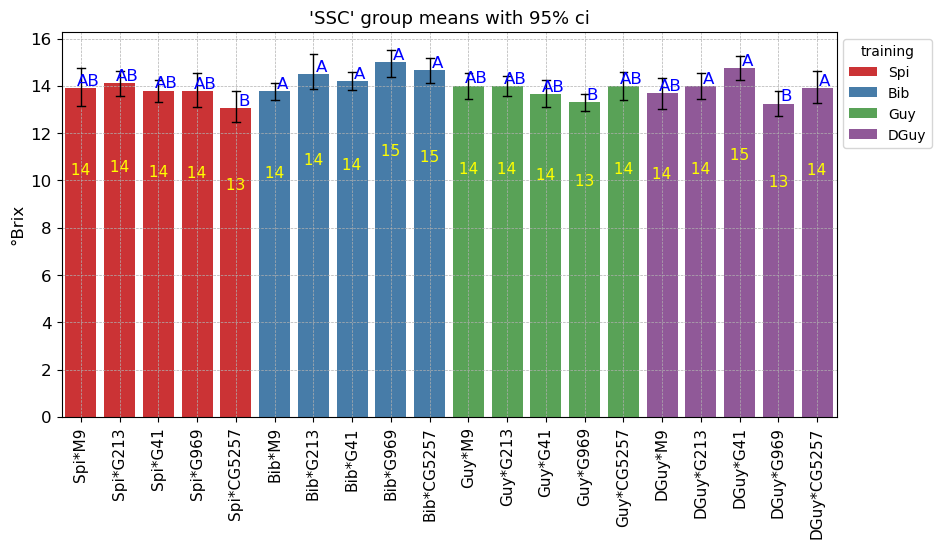

In [15]:
dataset = pd.read_excel(xlss_data_file, sheet_name='fruit_quality', skiprows=1)
display(dataset.head())

var_to_analyze = 'SSC'

dataset = dataset.dropna(subset=[var_to_analyze])

# ------------------ Perform ANOVA
model = ols(str(var_to_analyze +' ~ training * Rootstock'), data=dataset).fit()
anova_table = sm.stats.anova_lm(model, typ=3)
anova_df = pd.DataFrame(anova_table)
anova_df['Significance'] = anova_df['PR(>F)'].apply(assign_significance)

print('-------ANOVA TABLE-----------')
display(anova_df)

# Perform ANOVA and Tukey analysis (separate tests for training and Rootstock)
analysis_results = perform_tukey_analysis(dataset, var_to_analyze, anova_df)

# Plotting
df = analysis_results['df'] 
# display(df.head())
measure_unit = '°Brix'
analysis_barplot_with_letters(df, var_to_analyze,measure_unit, round_unit=0)

## DA meter


year training Rootstock  nr.fruit  diameter1  diameter2   diam  height  \
0  2025      Spi      G969         1      76.07      70.89  76.07   64.98   
1  2025      Spi      G969         2      73.39      73.51  73.51   61.69   
2  2025      Spi      G969         3      76.85      74.20  76.85   64.00   
3  2025      Spi      G969         4      75.55      72.29  75.55   62.62   
4  2025      Spi      G969         5      77.20      74.77  77.20   69.87   

   weight  color_cover   SSC  DA_Index  SDI   L   a   b   C  Hue  Firmness  
0  184.46         80.0  12.8    0.2787  5.0 NaN NaN NaN NaN  NaN       NaN  
1  181.17         60.0  12.5    0.6124  2.0 NaN NaN NaN NaN  NaN       NaN  
2  192.80        100.0  14.9    0.9112  3.0 NaN NaN NaN NaN  NaN       NaN  
3  172.58         80.0  14.7    0.2109  5.0 NaN NaN NaN NaN  NaN       NaN  
4  206.32         80.0  12.6    0.1973  6.0 NaN NaN NaN NaN  NaN       NaN

-------ANOVA TABLE-----------


sum_sq     df          F        PR(>F) Significance
Intercept            3.086476    1.0  70.325876  2.493076e-15          ***
training             0.637393    3.0   4.841039  2.664914e-03           **
Rootstock            0.126291    4.0   0.719393  5.792844e-01             
training:Rootstock   2.270906   12.0   4.311914  2.757788e-06          ***
Residual            12.288695  280.0        NaN           NaN


-------TUKEY TEST FOR TRAINING-----------


{'Bib': 'A', 'DGuy': 'B', 'Guy': 'B', 'Spi': 'C'}


-------TRAINING MEANS WITH TUKEY LETTERS-----------


training  DA_Index Letter
0      Bib  0.429677      A
1     DGuy  0.603352      B
2      Guy  0.595240      B
3      Spi  0.307540      C


-------TUKEY TEST FOR TRAINING * ROOTSTOCK-----------


{'Bib*CG5257': 'A',
 'Bib*G213': 'A',
 'Bib*G41': 'A',
 'Bib*G969': 'A',
 'Bib*M9': 'A',
 'DGuy*CG5257': 'A',
 'DGuy*G213': 'A',
 'DGuy*G41': 'A',
 'DGuy*G969': 'B',
 'DGuy*M9': 'B',
 'Guy*CG5257': 'AB',
 'Guy*G213': 'AB',
 'Guy*G41': 'A',
 'Guy*G969': 'A',
 'Guy*M9': 'A',
 'Spi*CG5257': 'C',
 'Spi*G213': 'C',
 'Spi*G41': 'AC',
 'Spi*G969': 'C',
 'Spi*M9': 'C'}

-------GROUP (TRAINING * ROOTSTOCK)WITH TUKEY LETTERS-----------


training Rootstock  DA_Index        Group Letter
0       Bib    CG5257  0.453613   Bib*CG5257      A
1       Bib      G213  0.385507     Bib*G213      A
2       Bib       G41  0.424220      Bib*G41      A
3       Bib      G969  0.389913     Bib*G969      A
4       Bib        M9  0.495133       Bib*M9      A
5      DGuy    CG5257  0.506787  DGuy*CG5257      A
6      DGuy      G213  0.481167    DGuy*G213      A
7      DGuy       G41  0.409327     DGuy*G41      A
8      DGuy      G969  0.885120    DGuy*G969      B
9      DGuy        M9  0.734360      DGuy*M9      B
10      Guy    CG5257  0.630853   Guy*CG5257     AB
11      Guy      G213  0.622960     Guy*G213     AB
12      Guy       G41  0.609153      Guy*G41      A
13      Guy      G969  0.564840     Guy*G969      A
14      Guy        M9  0.548393       Guy*M9      A
15      Spi    CG5257  0.344413   Spi*CG5257      C
16      Spi      G213  0.244720     Spi*G213      C
17      Spi       G41  0.359907      Spi*G41     AC
18      Spi      G969  0.302753     Spi*G969      C
19      Spi        M9  0.285907       Spi*M9      C

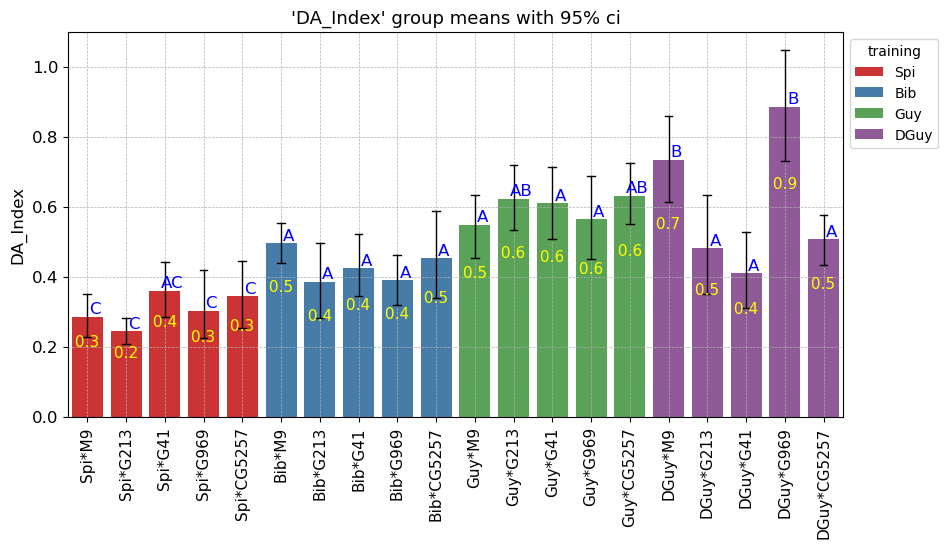

In [16]:
dataset = pd.read_excel(xlss_data_file, sheet_name='fruit_quality', skiprows=1)
display(dataset.head())

var_to_analyze = 'DA_Index'

dataset = dataset.dropna(subset=[var_to_analyze])

# ------------------ Perform ANOVA
model = ols(str(var_to_analyze +' ~ training * Rootstock'), data=dataset).fit()
anova_table = sm.stats.anova_lm(model, typ=3)
anova_df = pd.DataFrame(anova_table)
anova_df['Significance'] = anova_df['PR(>F)'].apply(assign_significance)

print('-------ANOVA TABLE-----------')
display(anova_df)

# Perform ANOVA and Tukey analysis (separate tests for training and Rootstock)
analysis_results = perform_tukey_analysis(dataset, var_to_analyze, anova_df)

# Plotting
df = analysis_results['df'] 
# display(df.head())
measure_unit = 'DA_Index'
analysis_barplot_with_letters(df, var_to_analyze,measure_unit, round_unit=1)

## Firmness


year training Rootstock  nr.fruit  diameter1  diameter2   diam  height  \
0  2025      Spi      G969         1      76.07      70.89  76.07   64.98   
1  2025      Spi      G969         2      73.39      73.51  73.51   61.69   
2  2025      Spi      G969         3      76.85      74.20  76.85   64.00   
3  2025      Spi      G969         4      75.55      72.29  75.55   62.62   
4  2025      Spi      G969         5      77.20      74.77  77.20   69.87   

   weight  color_cover   SSC  DA_Index  SDI   L   a   b   C  Hue  Firmness  
0  184.46         80.0  12.8    0.2787  5.0 NaN NaN NaN NaN  NaN       NaN  
1  181.17         60.0  12.5    0.6124  2.0 NaN NaN NaN NaN  NaN       NaN  
2  192.80        100.0  14.9    0.9112  3.0 NaN NaN NaN NaN  NaN       NaN  
3  172.58         80.0  14.7    0.2109  5.0 NaN NaN NaN NaN  NaN       NaN  
4  206.32         80.0  12.6    0.1973  6.0 NaN NaN NaN NaN  NaN       NaN

-------ANOVA TABLE-----------


sum_sq     df            F         PR(>F)  \
Intercept           3133.881255    1.0  2051.804577  1.242940e-192   
training              13.299031    3.0     2.902366   3.432783e-02   
Rootstock             63.178180    4.0    10.340953   4.279531e-08   
training:Rootstock    60.168818   12.0     3.282794   1.301088e-04   
Residual             885.879264  580.0          NaN            NaN   

                   Significance  
Intercept                   ***  
training                      *  
Rootstock                   ***  
training:Rootstock          ***  
Residual


-------TUKEY TEST FOR TRAINING-----------


{'Bib': 'A', 'DGuy': 'A', 'Guy': 'B', 'Spi': 'B'}


-------TRAINING MEANS WITH TUKEY LETTERS-----------


training  Firmness Letter
0      Bib  9.037553      A
1     DGuy  9.441773      A
2      Guy  9.751093      B
3      Spi  9.633520      B


-------TUKEY TEST FOR ROOTSTOCK-----------


{'CG5257': 'A', 'G213': 'B', 'G41': 'B', 'G969': 'B', 'M9': 'B'}


-------ROOTSTOCK MEANS WITH TUKEY LETTERS-----------


Rootstock   Firmness Letter
0    CG5257  10.490617      A
1      G213   8.912775      B
2       G41   9.352883      B
3      G969   9.327700      B
4        M9   9.245950      B


-------TUKEY TEST FOR TRAINING * ROOTSTOCK-----------


{'Bib*CG5257': 'A',
 'Bib*G213': 'B',
 'Bib*G41': 'B',
 'Bib*G969': 'B',
 'Bib*M9': 'B',
 'DGuy*CG5257': 'A',
 'DGuy*G213': 'B',
 'DGuy*G41': 'C',
 'DGuy*G969': 'BC',
 'DGuy*M9': 'BC',
 'Guy*CG5257': 'A',
 'Guy*G213': 'C',
 'Guy*G41': 'BC',
 'Guy*G969': 'A',
 'Guy*M9': 'BC',
 'Spi*CG5257': 'A',
 'Spi*G213': 'BC',
 'Spi*G41': 'C',
 'Spi*G969': 'A',
 'Spi*M9': 'C'}

-------GROUP (TRAINING * ROOTSTOCK)WITH TUKEY LETTERS-----------


training Rootstock   Firmness        Group Letter
0       Bib    CG5257  10.220700   Bib*CG5257      A
1       Bib      G213   8.294667     Bib*G213      B
2       Bib       G41   9.061067      Bib*G41      B
3       Bib      G969   8.653800     Bib*G969      B
4       Bib        M9   8.957533       Bib*M9      B
5      DGuy    CG5257  10.963800  DGuy*CG5257      A
6      DGuy      G213   9.064233    DGuy*G213      B
7      DGuy       G41   9.522233     DGuy*G41      C
8      DGuy      G969   8.663800    DGuy*G969     BC
9      DGuy        M9   8.994800      DGuy*M9     BC
10      Guy    CG5257  10.639867   Guy*CG5257      A
11      Guy      G213   9.468000     Guy*G213      C
12      Guy       G41   9.211133      Guy*G41     BC
13      Guy      G969  10.025000     Guy*G969      A
14      Guy        M9   9.411467       Guy*M9     BC
15      Spi    CG5257  10.138100   Spi*CG5257      A
16      Spi      G213   8.824200     Spi*G213     BC
17      Spi       G41   9.617100      Spi*G41      C
18      Spi      G969   9.968200     Spi*G969      A
19      Spi        M9   9.620000       Spi*M9      C

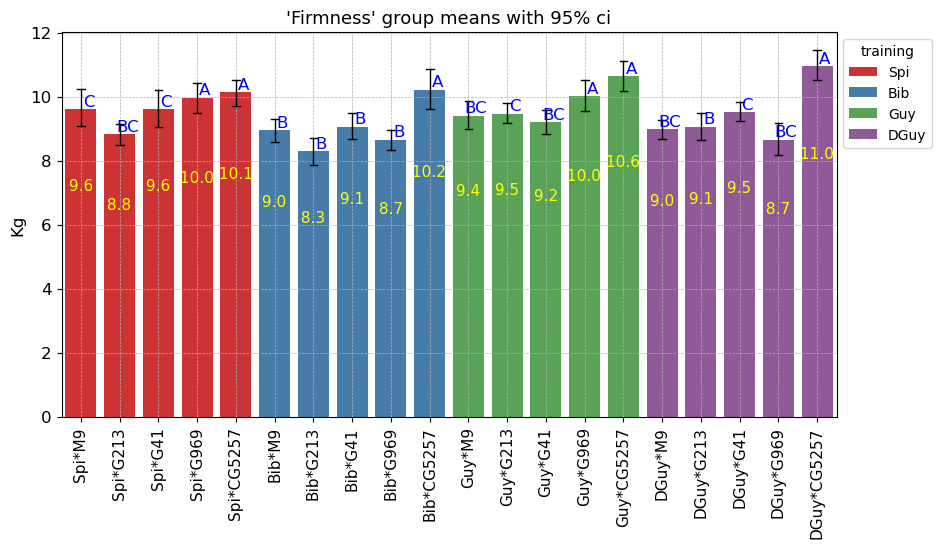

In [17]:
dataset = pd.read_excel(xlss_data_file, sheet_name='fruit_quality', skiprows=1)
display(dataset.head())

var_to_analyze = 'Firmness'

dataset = dataset.dropna(subset=[var_to_analyze])

# ------------------ Perform ANOVA
model = ols(str(var_to_analyze +' ~ training * Rootstock'), data=dataset).fit()
anova_table = sm.stats.anova_lm(model, typ=3)
anova_df = pd.DataFrame(anova_table)
anova_df['Significance'] = anova_df['PR(>F)'].apply(assign_significance)

print('-------ANOVA TABLE-----------')
display(anova_df)

# Perform ANOVA and Tukey analysis (separate tests for training and Rootstock)
analysis_results = perform_tukey_analysis(dataset, var_to_analyze, anova_df)

# Plotting
df = analysis_results['df'] 
# display(df.head())
measure_unit = 'Kg'
analysis_barplot_with_letters(df, var_to_analyze,measure_unit, round_unit=1)

## Starch  - TO Be DOne
## Da effettuare la valutazoine delle foto e successiva analisi

## Color


### Color Coverage

year training Rootstock  nr.fruit  diameter1  diameter2   diam  height  \
0  2025      Spi      G969         1      76.07      70.89  76.07   64.98   
1  2025      Spi      G969         2      73.39      73.51  73.51   61.69   
2  2025      Spi      G969         3      76.85      74.20  76.85   64.00   
3  2025      Spi      G969         4      75.55      72.29  75.55   62.62   
4  2025      Spi      G969         5      77.20      74.77  77.20   69.87   

   weight  color_cover   SSC  DA_Index  SDI   L   a   b   C  Hue  Firmness  
0  184.46         80.0  12.8    0.2787  5.0 NaN NaN NaN NaN  NaN       NaN  
1  181.17         60.0  12.5    0.6124  2.0 NaN NaN NaN NaN  NaN       NaN  
2  192.80        100.0  14.9    0.9112  3.0 NaN NaN NaN NaN  NaN       NaN  
3  172.58         80.0  14.7    0.2109  5.0 NaN NaN NaN NaN  NaN       NaN  
4  206.32         80.0  12.6    0.1973  6.0 NaN NaN NaN NaN  NaN       NaN

-------ANOVA TABLE-----------


sum_sq     df            F         PR(>F)  \
Intercept           112666.666667    1.0  1554.533509  2.643581e-116   
training              1723.333333    3.0     7.925975   4.313827e-05   
Rootstock             6268.666667    4.0    21.623193   1.462037e-15   
training:Rootstock    6543.500000   12.0     7.523735   4.888695e-12   
Residual             20293.333333  280.0          NaN            NaN   

                   Significance  
Intercept                   ***  
training                    ***  
Rootstock                   ***  
training:Rootstock          ***  
Residual


-------TUKEY TEST FOR TRAINING-----------


{'Bib': 'A', 'DGuy': 'A', 'Guy': 'B', 'Spi': 'C'}


-------TRAINING MEANS WITH TUKEY LETTERS-----------


training  color_cover Letter
0      Bib    86.533333      A
1     DGuy    82.600000      A
2      Guy    80.533333      B
3      Spi    90.800000      C


-------TUKEY TEST FOR ROOTSTOCK-----------


{'CG5257': 'A', 'G213': 'B', 'G41': 'A', 'G969': 'A', 'M9': 'A'}


-------ROOTSTOCK MEANS WITH TUKEY LETTERS-----------


Rootstock  color_cover Letter
0    CG5257    85.666667      A
1      G213    79.250000      B
2       G41    86.250000      A
3      G969    84.666667      A
4        M9    89.750000      A


-------TUKEY TEST FOR TRAINING * ROOTSTOCK-----------


{'Bib*CG5257': 'A',
 'Bib*G213': 'B',
 'Bib*G41': 'A',
 'Bib*G969': 'A',
 'Bib*M9': 'A',
 'DGuy*CG5257': 'A',
 'DGuy*G213': 'B',
 'DGuy*G41': 'A',
 'DGuy*G969': 'C',
 'DGuy*M9': 'C',
 'Guy*CG5257': 'BC',
 'Guy*G213': 'BC',
 'Guy*G41': 'C',
 'Guy*G969': 'BC',
 'Guy*M9': 'A',
 'Spi*CG5257': 'A',
 'Spi*G213': 'A',
 'Spi*G41': 'A',
 'Spi*G969': 'AC',
 'Spi*M9': 'D'}

-------GROUP (TRAINING * ROOTSTOCK)WITH TUKEY LETTERS-----------


training Rootstock  color_cover        Group Letter
0       Bib    CG5257    86.666667   Bib*CG5257      A
1       Bib      G213    69.000000     Bib*G213      B
2       Bib       G41    90.333333      Bib*G41      A
3       Bib      G969    94.666667     Bib*G969      A
4       Bib        M9    92.000000       Bib*M9      A
5      DGuy    CG5257    87.333333  DGuy*CG5257      A
6      DGuy      G213    76.333333    DGuy*G213      B
7      DGuy       G41    84.000000     DGuy*G41      A
8      DGuy      G969    82.666667    DGuy*G969      C
9      DGuy        M9    82.666667      DGuy*M9      C
10      Guy    CG5257    77.000000   Guy*CG5257     BC
11      Guy      G213    77.666667     Guy*G213     BC
12      Guy       G41    82.333333      Guy*G41      C
13      Guy      G969    77.333333     Guy*G969     BC
14      Guy        M9    88.333333       Guy*M9      A
15      Spi    CG5257    91.666667   Spi*CG5257      A
16      Spi      G213    94.000000     Spi*G213      A
17      Spi       G41    88.333333      Spi*G41      A
18      Spi      G969    84.000000     Spi*G969     AC
19      Spi        M9    96.000000       Spi*M9      D

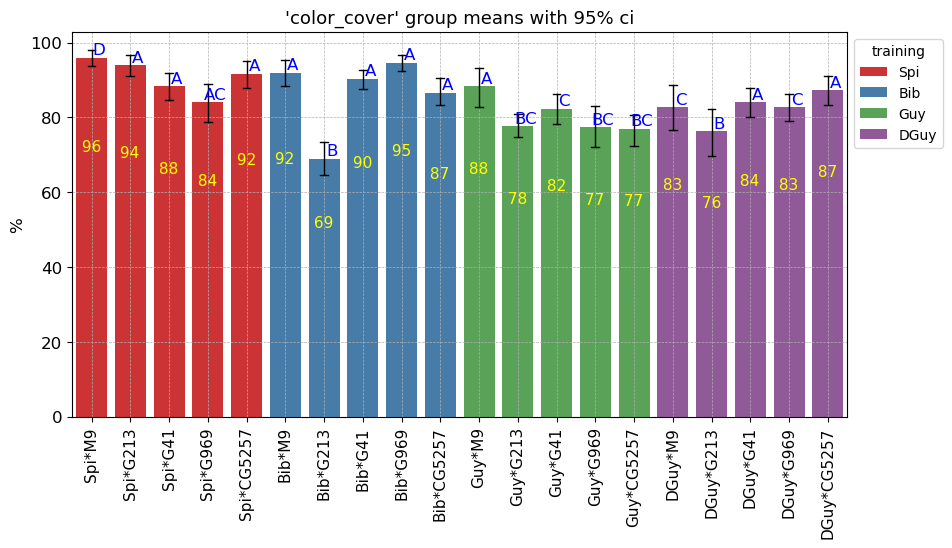

In [18]:
dataset = pd.read_excel(xlss_data_file, sheet_name='fruit_quality', skiprows=1)
display(dataset.head())

var_to_analyze = 'color_cover'

dataset = dataset.dropna(subset=[var_to_analyze])

# ------------------ Perform ANOVA
model = ols(str(var_to_analyze +' ~ training * Rootstock'), data=dataset).fit()
anova_table = sm.stats.anova_lm(model, typ=3)
anova_df = pd.DataFrame(anova_table)
anova_df['Significance'] = anova_df['PR(>F)'].apply(assign_significance)

print('-------ANOVA TABLE-----------')
display(anova_df)

# Perform ANOVA and Tukey analysis (separate tests for training and Rootstock)
analysis_results = perform_tukey_analysis(dataset, var_to_analyze, anova_df)

# Plotting
df = analysis_results['df'] 
# display(df.head())
measure_unit = '%'
analysis_barplot_with_letters(df, var_to_analyze,measure_unit, round_unit=0)

### Color - HUE

year training Rootstock  nr.fruit  diameter1  diameter2   diam  height  \
0  2025      Spi      G969         1      76.07      70.89  76.07   64.98   
1  2025      Spi      G969         2      73.39      73.51  73.51   61.69   
2  2025      Spi      G969         3      76.85      74.20  76.85   64.00   
3  2025      Spi      G969         4      75.55      72.29  75.55   62.62   
4  2025      Spi      G969         5      77.20      74.77  77.20   69.87   

   weight  color_cover   SSC  DA_Index  SDI   L   a   b   C  Hue  Firmness  
0  184.46         80.0  12.8    0.2787  5.0 NaN NaN NaN NaN  NaN       NaN  
1  181.17         60.0  12.5    0.6124  2.0 NaN NaN NaN NaN  NaN       NaN  
2  192.80        100.0  14.9    0.9112  3.0 NaN NaN NaN NaN  NaN       NaN  
3  172.58         80.0  14.7    0.2109  5.0 NaN NaN NaN NaN  NaN       NaN  
4  206.32         80.0  12.6    0.1973  6.0 NaN NaN NaN NaN  NaN       NaN

-------ANOVA TABLE-----------


sum_sq     df           F        PR(>F) Significance
Intercept           30579.361333    1.0  293.084413  1.751524e-53          ***
training             1045.105049    3.0    3.338897  1.908553e-02            *
Rootstock            1126.826249    4.0    2.699985  2.991007e-02            *
training:Rootstock   2070.694288   12.0    1.653861  7.335065e-02            ~
Residual            60515.089707  580.0         NaN           NaN


-------TUKEY TEST FOR TRAINING-----------


{'Bib': 'A', 'DGuy': 'A', 'Guy': 'B', 'Spi': 'C'}


-------TRAINING MEANS WITH TUKEY LETTERS-----------


training        Hue Letter
0      Bib  31.828933      A
1     DGuy  34.065200      A
2      Guy  35.193067      B
3      Spi  30.080933      C


-------TUKEY TEST FOR ROOTSTOCK-----------


{'CG5257': 'A', 'G213': 'A', 'G41': 'B', 'G969': 'A', 'M9': 'AB'}


-------ROOTSTOCK MEANS WITH TUKEY LETTERS-----------


Rootstock        Hue Letter
0    CG5257  32.560417      A
1      G213  35.343167      A
2       G41  29.921167      B
3      G969  34.287167      A
4        M9  31.848250     AB


-------TUKEY TEST FOR TRAINING * ROOTSTOCK-----------


{'Bib*CG5257': 'A',
 'Bib*G213': 'A',
 'Bib*G41': 'A',
 'Bib*G969': 'A',
 'Bib*M9': 'A',
 'DGuy*CG5257': 'A',
 'DGuy*G213': 'A',
 'DGuy*G41': 'A',
 'DGuy*G969': 'A',
 'DGuy*M9': 'A',
 'Guy*CG5257': 'A',
 'Guy*G213': 'A',
 'Guy*G41': 'A',
 'Guy*G969': 'A',
 'Guy*M9': 'A',
 'Spi*CG5257': 'A',
 'Spi*G213': 'A',
 'Spi*G41': 'B',
 'Spi*G969': 'AB',
 'Spi*M9': 'AB'}

-------GROUP (TRAINING * ROOTSTOCK)WITH TUKEY LETTERS-----------


training Rootstock        Hue        Group Letter
0       Bib    CG5257  31.926667   Bib*CG5257      A
1       Bib      G213  37.060000     Bib*G213      A
2       Bib       G41  30.660333      Bib*G41      A
3       Bib      G969  29.459000     Bib*G969      A
4       Bib        M9  30.038667       Bib*M9      A
5      DGuy    CG5257  32.767000  DGuy*CG5257      A
6      DGuy      G213  36.611000    DGuy*G213      A
7      DGuy       G41  28.256000     DGuy*G41      A
8      DGuy      G969  36.299667    DGuy*G969      A
9      DGuy        M9  36.392333      DGuy*M9      A
10      Guy    CG5257  36.915333   Guy*CG5257      A
11      Guy      G213  36.642667     Guy*G213      A
12      Guy       G41  33.223333      Guy*G41      A
13      Guy      G969  37.181333     Guy*G969      A
14      Guy        M9  32.002667       Guy*M9      A
15      Spi    CG5257  28.632667   Spi*CG5257      A
16      Spi      G213  31.059000     Spi*G213      A
17      Spi       G41  27.545000      Spi*G41      B
18      Spi      G969  34.208667     Spi*G969     AB
19      Spi        M9  28.959333       Spi*M9     AB

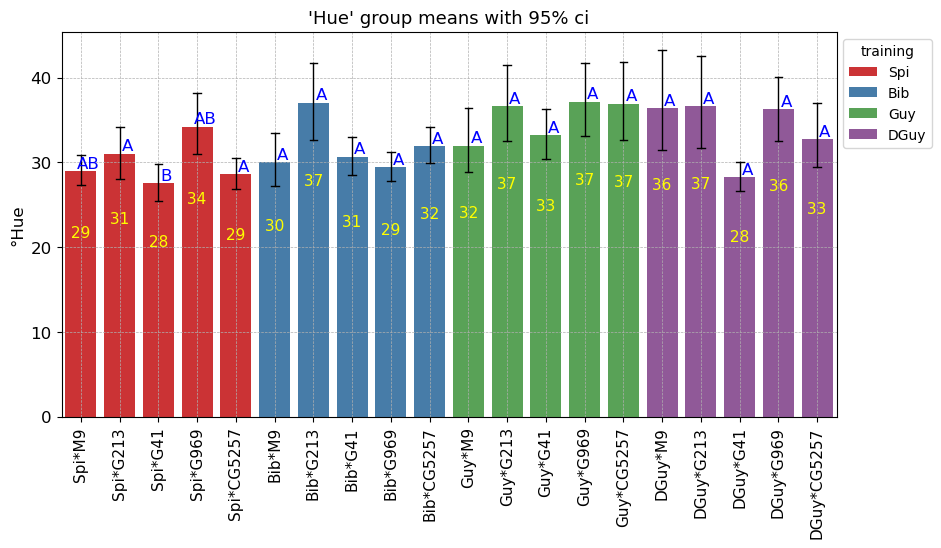

In [19]:
dataset = pd.read_excel(xlss_data_file, sheet_name='fruit_quality', skiprows=1)
display(dataset.head())

var_to_analyze = 'Hue'

dataset = dataset.dropna(subset=[var_to_analyze])

# ------------------ Perform ANOVA
model = ols(str(var_to_analyze +' ~ training * Rootstock'), data=dataset).fit()
anova_table = sm.stats.anova_lm(model, typ=3)
anova_df = pd.DataFrame(anova_table)
anova_df['Significance'] = anova_df['PR(>F)'].apply(assign_significance)

print('-------ANOVA TABLE-----------')
display(anova_df)

# Perform ANOVA and Tukey analysis (separate tests for training and Rootstock)
analysis_results = perform_tukey_analysis(dataset, var_to_analyze, anova_df)

# Plotting
df = analysis_results['df'] 
# display(df.head())
measure_unit = '°Hue'
analysis_barplot_with_letters(df, var_to_analyze,measure_unit, round_unit=0)

### Color -TO DO, COLOR EXAMPLE

**PRINT A COLOR CHART OF THE RESULTS**

###   TO DO: Cosine similarity Chroma
### To improve the code for using angles and not float

In [20]:
def cosine_similarity_chroma(hue: float = 0.0, astar: float = 0.0, target_hue: float = 0.0, cosine_tolerance: float = 0.85) -> float:
    """
    Computes the Cosine Similarity Chroma (CSC) based on the difference in hue between 
    an input color and a target hue, weighted by the astar component.

    The function calculates the cosine similarity of the hue difference, ensuring that 
    only values above a given cosine tolerance contribute to the final result. The CSC 
    value is then obtained by multiplying the cosine similarity by astar.

    Parameters:
        hue (float, optional): The hue of the input color in degrees. Default is 0.0.
        astar (float, optional): The chroma component (e.g., a* in CIELAB space), 
                                typically ranging from -60 to 60. Default is 0.0.
        target_hue (float, optional): The reference hue in degrees. Default is 0.0.
        cosine_tolerance (float, optional): The threshold for cosine similarity; values 
                                            below this are set to zero. Default is 0.85.

    Returns:
        float: The Cosine Similarity Chroma (CSC), which is a weighted measure of 
                hue similarity scaled by the chroma component.
    
    Example usage:
        >> cosine_similarity_chroma(hue, a_star, target_hue=30.0)
        33.56

    Notes:
        - The cosine similarity ranges from [-1, 1], but values below the specified 
            tolerance are set to zero.
        - The final CSC value is influenced by both the cosine similarity and the 
            magnitude of the astar parameter.
    """
    # Compute delta hue
    delta_hue = np.float32(hue) - np.float32(target_hue) 
    
    # Compute cosine similarity (if colors are the same, their difference is 0 and their cosine is maximum)
    cosine_similarity = np.cos(np.deg2rad(delta_hue))

    # cosine range [-1, 1] -> [0, 1]
    cosine_similarity = np.where(cosine_similarity >= cosine_tolerance, cosine_similarity, 0.0)

    # Compute Cosine Similarity Chroma (CSC)
    # 1e-1 adds 0.1 to star, so that if a* is 0 and cosine_similarity is 1, the color classification is still valid
    csc = cosine_similarity * (astar + 1e-1)  # ranges: cosine [0, 1]; astar [-60, 60]
    return(np.float32(csc))

year training Rootstock  nr.fruit  diameter1  diameter2   diam  height  \
0  2025      Spi      G969         1      76.07      70.89  76.07   64.98   
1  2025      Spi      G969         2      73.39      73.51  73.51   61.69   
2  2025      Spi      G969         3      76.85      74.20  76.85   64.00   
3  2025      Spi      G969         4      75.55      72.29  75.55   62.62   
4  2025      Spi      G969         5      77.20      74.77  77.20   69.87   

   weight  color_cover   SSC  DA_Index  SDI   L   a   b   C  Hue  Firmness  
0  184.46         80.0  12.8    0.2787  5.0 NaN NaN NaN NaN  NaN       NaN  
1  181.17         60.0  12.5    0.6124  2.0 NaN NaN NaN NaN  NaN       NaN  
2  192.80        100.0  14.9    0.9112  3.0 NaN NaN NaN NaN  NaN       NaN  
3  172.58         80.0  14.7    0.2109  5.0 NaN NaN NaN NaN  NaN       NaN  
4  206.32         80.0  12.6    0.1973  6.0 NaN NaN NaN NaN  NaN       NaN

-------ANOVA TABLE-----------


sum_sq     df          F        PR(>F) Significance
Intercept            11426.910804    1.0  35.157313  5.225214e-09          ***
training              2206.337938    3.0   2.262755  8.014272e-02            ~
Rootstock             3367.348018    4.0   2.590090  3.586731e-02            *
training:Rootstock    6960.067489   12.0   1.784510  4.740738e-02            *
Residual            188512.937773  580.0        NaN           NaN


-------TUKEY TEST FOR TRAINING-----------


{'Bib': 'A', 'DGuy': 'A', 'Guy': 'A', 'Spi': 'B'}


-------TRAINING MEANS WITH TUKEY LETTERS-----------


training        CSC Letter
0      Bib  23.453356      A
1     DGuy  23.517721      A
2      Guy  18.783468      A
3      Spi  27.626501      B


-------TUKEY TEST FOR ROOTSTOCK-----------


{'CG5257': 'A', 'G213': 'A', 'G41': 'A', 'G969': 'A', 'M9': 'A'}


-------ROOTSTOCK MEANS WITH TUKEY LETTERS-----------


Rootstock        CSC Letter
0    CG5257  23.440678      A
1      G213  20.394741      A
2       G41  25.941900      A
3      G969  20.415894      A
4        M9  26.533098      A


-------TUKEY TEST FOR TRAINING * ROOTSTOCK-----------


{'Bib*CG5257': 'A',
 'Bib*G213': 'A',
 'Bib*G41': 'A',
 'Bib*G969': 'A',
 'Bib*M9': 'A',
 'DGuy*CG5257': 'A',
 'DGuy*G213': 'A',
 'DGuy*G41': 'A',
 'DGuy*G969': 'A',
 'DGuy*M9': 'A',
 'Guy*CG5257': 'A',
 'Guy*G213': 'A',
 'Guy*G41': 'A',
 'Guy*G969': 'A',
 'Guy*M9': 'A',
 'Spi*CG5257': 'A',
 'Spi*G213': 'A',
 'Spi*G41': 'A',
 'Spi*G969': 'A',
 'Spi*M9': 'A'}

-------GROUP (TRAINING * ROOTSTOCK)WITH TUKEY LETTERS-----------


training Rootstock        CSC        Group Letter
0       Bib    CG5257  19.516582   Bib*CG5257      A
1       Bib      G213  16.330982     Bib*G213      A
2       Bib       G41  25.333992      Bib*G41      A
3       Bib      G969  28.466452     Bib*G969      A
4       Bib        M9  27.618767       Bib*M9      A
5      DGuy    CG5257  26.330132  DGuy*CG5257      A
6      DGuy      G213  20.387177    DGuy*G213      A
7      DGuy       G41  31.516848     DGuy*G41      A
8      DGuy      G969  16.532253    DGuy*G969      A
9      DGuy        M9  22.822201      DGuy*M9      A
10      Guy    CG5257  18.995043   Guy*CG5257      A
11      Guy      G213  15.948520     Guy*G213      A
12      Guy       G41  18.221855      Guy*G41      A
13      Guy      G969  17.238382     Guy*G969      A
14      Guy        M9  23.513544       Guy*M9      A
15      Spi    CG5257  28.920958   Spi*CG5257      A
16      Spi      G213  28.912285     Spi*G213      A
17      Spi       G41  28.694906      Spi*G41      A
18      Spi      G969  19.426485     Spi*G969      A
19      Spi        M9  32.177879       Spi*M9      A

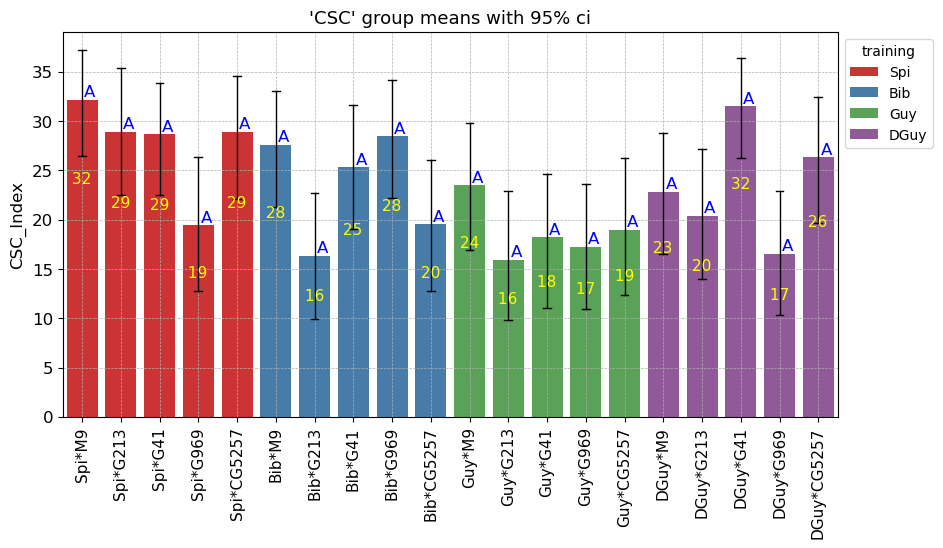

In [21]:
import pandas as pd

dataset = pd.read_excel(xlss_data_file, sheet_name='fruit_quality', skiprows=1)
display(dataset.head())

columns = [col for col in dataset.columns if col.find('Unnamed')==-1]
dataset = dataset[columns]
dataset['CSC'] = dataset.apply(lambda row: cosine_similarity_chroma(hue=row['Hue'], astar=row['a'], target_hue=0.0, cosine_tolerance=0.85), axis=1)

var_to_analyze = 'CSC'
dataset = dataset.dropna(subset=[var_to_analyze])

# ------------------ Perform ANOVA
model = ols(str(var_to_analyze +' ~ training * Rootstock'), data=dataset).fit()
anova_table = sm.stats.anova_lm(model, typ=3)
anova_df = pd.DataFrame(anova_table)
anova_df['Significance'] = anova_df['PR(>F)'].apply(assign_significance)

print('-------ANOVA TABLE-----------')
display(anova_df)

# Perform ANOVA and Tukey analysis (separate tests for training and Rootstock)
analysis_results = perform_tukey_analysis(dataset, var_to_analyze, anova_df)

# Plotting
df = analysis_results['df'] 
# display(df.head())
measure_unit = 'CSC_Index'
analysis_barplot_with_letters(df, var_to_analyze,measure_unit, round_unit=0)

year  inter-pole training  row  tree Rootstock  early_season_trunk1  \
0  2025           1     DGuy    2     2        M9                21.85   
1  2025           1     DGuy    2     3        M9                24.95   
2  2025           1     DGuy    2     4        M9                  NaN   
3  2025           2     DGuy    2     6      G213                23.77   
4  2025           2     DGuy    2     7      G213                28.06   

   early_season_trunk2  end_season_trunk1a  end_season_trunk1b  ...     kg  \
0                27.39               27.97               24.93  ...    NaN   
1                29.02               29.43               32.58  ...  19.22   
2                  NaN               25.54               23.85  ...  13.66   
3                29.79               29.44               29.19  ...  26.16   
4                39.55               35.81               36.91  ...  25.86   

   time/tree  tree/ha   Yield  yield_eff_2  avg_fruit_weight  harvest_time  \
0        NaN      NaN     NaN          NaN               NaN           NaN   
1       10.0   1600.0  30.752     2.264979        215.955056    266.666667   
2       10.0   1600.0  21.856     2.006713        168.641975    266.666667   
3       15.0   1600.0  41.856     2.765437        192.352941    400.000000   
4       15.0   1600.0  41.376     2.155353        160.621118    400.000000   

   VLIe  PLIe  VPLI  
0   NaN   NaN   NaN  
1   NaN   NaN   NaN  
2   NaN   NaN   NaN  
3   NaN   NaN   NaN  
4   NaN   NaN   NaN  

[5 rows x 36 columns]

-------ANOVA TABLE-----------


sum_sq     df          F        PR(>F) Significance
Intercept            12.500000    1.0  13.572063  3.338367e-04          ***
training              2.383333    3.0   0.862580  4.623553e-01             
Rootstock            60.350000    4.0  16.381481  6.403511e-11          ***
training:Rootstock   21.352534   12.0   1.931986  3.587297e-02            *
Residual            121.573260  132.0        NaN           NaN


-------TUKEY TEST FOR ROOTSTOCK-----------


{'CG5257': 'A', 'G213': 'B', 'G41': 'AB', 'G969': 'A', 'M9': 'C'}


-------ROOTSTOCK MEANS WITH TUKEY LETTERS-----------


Rootstock   Bknoots Letter
0    CG5257  1.700000      A
1      G213  0.903226      B
2       G41  1.548387     AB
3      G969  2.300000      A
4        M9  4.233333      C


-------TUKEY TEST FOR TRAINING * ROOTSTOCK-----------


{'Bib*CG5257': 'A',
 'Bib*G213': 'A',
 'Bib*G41': 'A',
 'Bib*G969': 'A',
 'Bib*M9': 'B',
 'DGuy*CG5257': 'A',
 'DGuy*G213': 'A',
 'DGuy*G41': 'A',
 'DGuy*G969': 'A',
 'DGuy*M9': 'B',
 'Guy*CG5257': 'A',
 'Guy*G213': 'A',
 'Guy*G41': 'A',
 'Guy*G969': 'A',
 'Guy*M9': 'B',
 'Spi*CG5257': 'A',
 'Spi*G213': 'A',
 'Spi*G41': 'A',
 'Spi*G969': 'B',
 'Spi*M9': 'C'}

-------GROUP (TRAINING * ROOTSTOCK)WITH TUKEY LETTERS-----------


training Rootstock   Bknoots        Group Letter
0       Bib    CG5257  1.250000   Bib*CG5257      A
1       Bib      G213  0.625000     Bib*G213      A
2       Bib       G41  1.250000      Bib*G41      A
3       Bib      G969  2.250000     Bib*G969      A
4       Bib        M9  4.125000       Bib*M9      B
5      DGuy    CG5257  1.750000  DGuy*CG5257      A
6      DGuy      G213  0.500000    DGuy*G213      A
7      DGuy       G41  0.500000     DGuy*G41      A
8      DGuy      G969  0.500000    DGuy*G969      A
9      DGuy        M9  3.750000      DGuy*M9      B
10      Guy    CG5257  2.000000   Guy*CG5257      A
11      Guy      G213  1.000000     Guy*G213      A
12      Guy       G41  2.000000      Guy*G41      A
13      Guy      G969  1.666667     Guy*G969      A
14      Guy        M9  3.500000       Guy*M9      B
15      Spi    CG5257  1.833333   Spi*CG5257      A
16      Spi      G213  1.142857     Spi*G213      A
17      Spi       G41  1.846154      Spi*G41      A
18      Spi      G969  3.250000     Spi*G969      B
19      Spi        M9  4.833333       Spi*M9      C

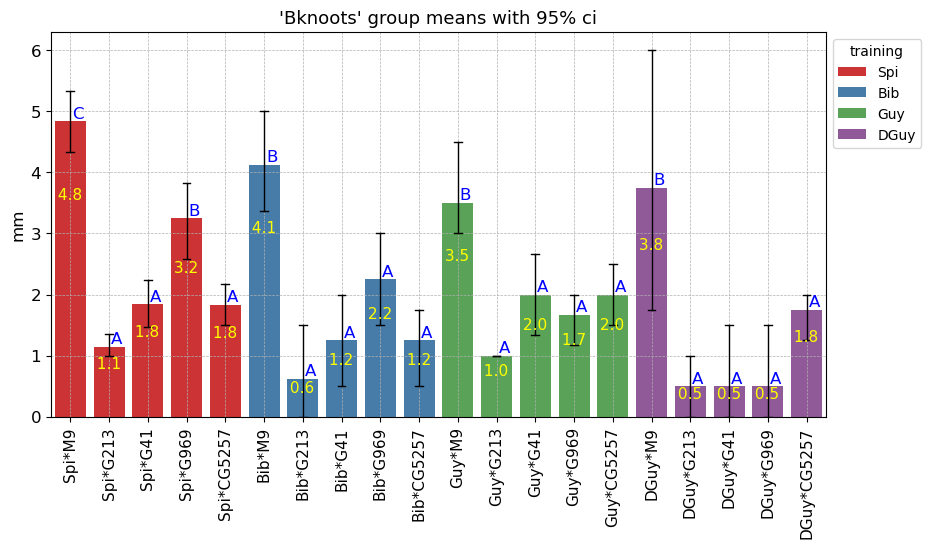

In [22]:
dataset = pd.read_excel(xlss_data_file, sheet_name='all_data', skiprows=1)
display(dataset.head())

var_to_analyze = 'Bknoots'

dataset = dataset.dropna(subset=[var_to_analyze])

# ------------------ Perform ANOVA
model = ols(str(var_to_analyze +' ~ training * Rootstock'), data=dataset).fit()
anova_table = sm.stats.anova_lm(model, typ=3)
anova_df = pd.DataFrame(anova_table)
anova_df['Significance'] = anova_df['PR(>F)'].apply(assign_significance)

print('-------ANOVA TABLE-----------')
display(anova_df)

# Perform ANOVA and Tukey analysis (separate tests for training and Rootstock)
analysis_results = perform_tukey_analysis(dataset, var_to_analyze, anova_df)

# Plotting
df = analysis_results['df'] 
# display(df.head())
measure_unit = 'mm'
analysis_barplot_with_letters(df, var_to_analyze,measure_unit, round_unit=1)

## Fruit size size and color class ##

In [23]:
dataset = pd.read_excel(xlss_data_file, sheet_name='fruit_quality', skiprows=1)
display(dataset.head())

columns = [col for col in dataset.columns if col.find('Unnamed')==-1]
dataset = dataset[columns]
display(dataset.head())

# yield_data = pd.read_excel('Bortolotti_Agromillora_Qualità_2024_local.xlsx', sheet_name='Harvest', skiprows=67)
# # Skip unnamed columns
# columns = [col for col in yield_data.columns if col.find('Unnamed')==-1]
# yield_data = yield_data[columns]
# display(yield_data.head())

year training Rootstock  nr.fruit  diameter1  diameter2   diam  height  \
0  2025      Spi      G969         1      76.07      70.89  76.07   64.98   
1  2025      Spi      G969         2      73.39      73.51  73.51   61.69   
2  2025      Spi      G969         3      76.85      74.20  76.85   64.00   
3  2025      Spi      G969         4      75.55      72.29  75.55   62.62   
4  2025      Spi      G969         5      77.20      74.77  77.20   69.87   

   weight  color_cover   SSC  DA_Index  SDI   L   a   b   C  Hue  Firmness  
0  184.46         80.0  12.8    0.2787  5.0 NaN NaN NaN NaN  NaN       NaN  
1  181.17         60.0  12.5    0.6124  2.0 NaN NaN NaN NaN  NaN       NaN  
2  192.80        100.0  14.9    0.9112  3.0 NaN NaN NaN NaN  NaN       NaN  
3  172.58         80.0  14.7    0.2109  5.0 NaN NaN NaN NaN  NaN       NaN  
4  206.32         80.0  12.6    0.1973  6.0 NaN NaN NaN NaN  NaN       NaN

year training Rootstock  nr.fruit  diameter1  diameter2   diam  height  \
0  2025      Spi      G969         1      76.07      70.89  76.07   64.98   
1  2025      Spi      G969         2      73.39      73.51  73.51   61.69   
2  2025      Spi      G969         3      76.85      74.20  76.85   64.00   
3  2025      Spi      G969         4      75.55      72.29  75.55   62.62   
4  2025      Spi      G969         5      77.20      74.77  77.20   69.87   

   weight  color_cover   SSC  DA_Index  SDI   L   a   b   C  Hue  Firmness  
0  184.46         80.0  12.8    0.2787  5.0 NaN NaN NaN NaN  NaN       NaN  
1  181.17         60.0  12.5    0.6124  2.0 NaN NaN NaN NaN  NaN       NaN  
2  192.80        100.0  14.9    0.9112  3.0 NaN NaN NaN NaN  NaN       NaN  
3  172.58         80.0  14.7    0.2109  5.0 NaN NaN NaN NaN  NaN       NaN  
4  206.32         80.0  12.6    0.1973  6.0 NaN NaN NaN NaN  NaN       NaN

In [24]:
#'<60','60-65','65-70','70-75','75-80','80-85','>85'

# Function to classify diam values
def classify_diam(diam):
    if diam < 60:
        return '<60mm'
    elif 60 <= diam < 65:
        return '60-65mm'
    elif 65 <= diam < 70:
        return '65-70mm'
    elif 70 <= diam < 75:
        return '70-75mm'
    elif 75 <= diam < 80:
        return '75-80mm'
    elif 80 <= diam < 85:
        return '80-85mm'
    else:
        return '>85mm'

def classify_color_cover(color_cover):
    if color_cover < 60:
        return '<60%'
    elif 60 <= color_cover < 70:
        return '60-70%'
    elif 70 <= color_cover < 80:
        return '70-80%'
    elif 80 <= color_cover < 90:
        return '80-90%'
    else:
        return '>90%'

df = dataset.copy()

df['groups'] = df['training']+"*"+df['Rootstock']
# Apply the function to create a new column
df['diam_class'] = df['diam'].apply(classify_diam)
# Apply the function to create a new column for color_cover classification
df['color_cover_class'] = df['color_cover'].apply(classify_color_cover)

display(df)
# Define the desired order
desired_order = ["Spi*M9", "Spi*G213", "Spi*G41", "Spi*G969","Spi*CG5257", "Bib*M9", "Bib*G213", "Bib*G41", "Bib*G969","Bib*CG5257",
               "Guy*M9", "Guy*G213", "Guy*G41", "Guy*G969","Guy*CG5257", "DGuy*M9", "DGuy*G213", "DGuy*G41", "DGuy*G969","DGuy*CG5257"
               ]
# Set the groups column as a categorical type with the desired order
df['groups'] = pd.Categorical(df['groups'], categories=desired_order, ordered=True)

# Sort the DataFrame by the groups column
df_sorted = df.sort_values('groups')

# Print the sorted DataFrame
display(df)



year training Rootstock  nr.fruit  diameter1  diameter2   diam  height  \
0    2025      Spi      G969         1      76.07      70.89  76.07   64.98   
1    2025      Spi      G969         2      73.39      73.51  73.51   61.69   
2    2025      Spi      G969         3      76.85      74.20  76.85   64.00   
3    2025      Spi      G969         4      75.55      72.29  75.55   62.62   
4    2025      Spi      G969         5      77.20      74.77  77.20   69.87   
..    ...      ...       ...       ...        ...        ...    ...     ...   
895  2025      Guy        M9        13        NaN        NaN    NaN     NaN   
896  2025      Guy        M9        14        NaN        NaN    NaN     NaN   
897  2025      Guy        M9        14        NaN        NaN    NaN     NaN   
898  2025      Guy        M9        15        NaN        NaN    NaN     NaN   
899  2025      Guy        M9        15        NaN        NaN    NaN     NaN   

     weight  color_cover  ...  SDI      L      a      b      C    Hue  \
0    184.46         80.0  ...  5.0    NaN    NaN    NaN    NaN    NaN   
1    181.17         60.0  ...  2.0    NaN    NaN    NaN    NaN    NaN   
2    192.80        100.0  ...  3.0    NaN    NaN    NaN    NaN    NaN   
3    172.58         80.0  ...  5.0    NaN    NaN    NaN    NaN    NaN   
4    206.32         80.0  ...  6.0    NaN    NaN    NaN    NaN    NaN   
..      ...          ...  ...  ...    ...    ...    ...    ...    ...   
895     NaN          NaN  ...  NaN  49.37  33.96  26.27  42.93  37.72   
896     NaN          NaN  ...  NaN  34.71  45.32  18.84  49.08  22.58   
897     NaN          NaN  ...  NaN  51.74  41.68  23.93  48.06  29.86   
898     NaN          NaN  ...  NaN  47.75  35.56  24.72  43.31  34.80   
899     NaN          NaN  ...  NaN  54.46  31.89  26.29  41.33  39.51   

     Firmness    groups  diam_class color_cover_class  
0         NaN  Spi*G969     75-80mm            80-90%  
1         NaN  Spi*G969     70-75mm            60-70%  
2         NaN  Spi*G969     75-80mm              >90%  
3         NaN  Spi*G969     75-80mm            80-90%  
4         NaN  Spi*G969     75-80mm            80-90%  
..        ...       ...         ...               ...  
895     8.504    Guy*M9       >85mm              >90%  
896    12.700    Guy*M9       >85mm              >90%  
897    11.272    Guy*M9       >85mm              >90%  
898     9.451    Guy*M9       >85mm              >90%  
899     9.990    Guy*M9       >85mm              >90%  

[900 rows x 22 columns]

year training Rootstock  nr.fruit  diameter1  diameter2   diam  height  \
0    2025      Spi      G969         1      76.07      70.89  76.07   64.98   
1    2025      Spi      G969         2      73.39      73.51  73.51   61.69   
2    2025      Spi      G969         3      76.85      74.20  76.85   64.00   
3    2025      Spi      G969         4      75.55      72.29  75.55   62.62   
4    2025      Spi      G969         5      77.20      74.77  77.20   69.87   
..    ...      ...       ...       ...        ...        ...    ...     ...   
895  2025      Guy        M9        13        NaN        NaN    NaN     NaN   
896  2025      Guy        M9        14        NaN        NaN    NaN     NaN   
897  2025      Guy        M9        14        NaN        NaN    NaN     NaN   
898  2025      Guy        M9        15        NaN        NaN    NaN     NaN   
899  2025      Guy        M9        15        NaN        NaN    NaN     NaN   

     weight  color_cover  ...  SDI      L      a      b      C    Hue  \
0    184.46         80.0  ...  5.0    NaN    NaN    NaN    NaN    NaN   
1    181.17         60.0  ...  2.0    NaN    NaN    NaN    NaN    NaN   
2    192.80        100.0  ...  3.0    NaN    NaN    NaN    NaN    NaN   
3    172.58         80.0  ...  5.0    NaN    NaN    NaN    NaN    NaN   
4    206.32         80.0  ...  6.0    NaN    NaN    NaN    NaN    NaN   
..      ...          ...  ...  ...    ...    ...    ...    ...    ...   
895     NaN          NaN  ...  NaN  49.37  33.96  26.27  42.93  37.72   
896     NaN          NaN  ...  NaN  34.71  45.32  18.84  49.08  22.58   
897     NaN          NaN  ...  NaN  51.74  41.68  23.93  48.06  29.86   
898     NaN          NaN  ...  NaN  47.75  35.56  24.72  43.31  34.80   
899     NaN          NaN  ...  NaN  54.46  31.89  26.29  41.33  39.51   

     Firmness    groups  diam_class color_cover_class  
0         NaN  Spi*G969     75-80mm            80-90%  
1         NaN  Spi*G969     70-75mm            60-70%  
2         NaN  Spi*G969     75-80mm              >90%  
3         NaN  Spi*G969     75-80mm            80-90%  
4         NaN  Spi*G969     75-80mm            80-90%  
..        ...       ...         ...               ...  
895     8.504    Guy*M9       >85mm              >90%  
896    12.700    Guy*M9       >85mm              >90%  
897    11.272    Guy*M9       >85mm              >90%  
898     9.451    Guy*M9       >85mm              >90%  
899     9.990    Guy*M9       >85mm              >90%  

[900 rows x 22 columns]

### fruit diam class

Text(0.5, 1.0, 'Fruit size class distribution')

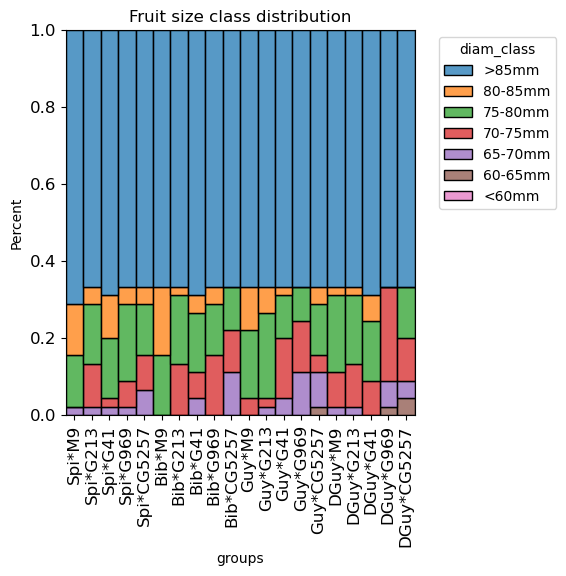

In [25]:

hue_order = ['>85mm', '80-85mm', '75-80mm', '70-75mm', '65-70mm', '60-65mm', '<60mm']

# group_order = ["Spi*M9", "Spi*G213", "Spi*G41", "Spi*G969", "Bib*M9", "Bib*G213", "Bib*G41", "Bib*G969", 
#                "Guy*M9", "Guy*G213", "Guy*G41", "Guy*G969", "DGuy*M9", "DGuy*G213", "DGuy*G41", "DGuy*G969"]

plt.figure(figsize=(4.5,5))

graph = sns.histplot(data=df, x='groups', hue='diam_class', hue_order=hue_order,  multiple='fill', stat='percent',
                      )


# Move the legend to the right, just outside the plot
sns.move_legend(graph, "upper left", bbox_to_anchor=(1.05, 1))
plt.xticks(rotation=90)
# Increase font size of x-ticks
plt.xticks(rotation=90, fontsize=12)
plt.yticks( fontsize=12)
plt.title("Fruit size class distribution")



### fruit color class

(array([0. , 0.2, 0.4, 0.6, 0.8, 1. ]),
 [Text(0, 0.0, '0.0'),
  Text(0, 0.2, '0.2'),
  Text(0, 0.4, '0.4'),
  Text(0, 0.6000000000000001, '0.6'),
  Text(0, 0.8, '0.8'),
  Text(0, 1.0, '1.0')])

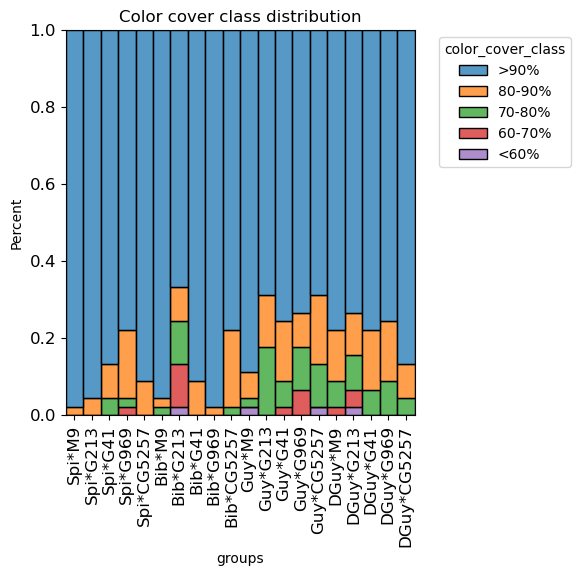

In [26]:
hue_order = ['>90%', '80-90%', '70-80%', '60-70%', '<60%']

# group_order = ["Spi*M9", "Spi*G213", "Spi*G41", "Spi*G969", "Bib*M9", "Bib*G213", "Bib*G41", "Bib*G969", 
#                "Guy*M9", "Guy*G213", "Guy*G41", "Guy*G969", "DGuy*M9", "DGuy*G213", "DGuy*G41", "DGuy*G969"]

plt.figure(figsize=(4.5,5))
graph = sns.histplot(data=df, x='groups', hue='color_cover_class', hue_order=hue_order,  multiple='fill', stat='percent',
                      )

# Move the legend to the right, just outside the plot
sns.move_legend(graph, "upper left", bbox_to_anchor=(1.05, 1))
plt.xticks(rotation=90)
# Increase font size of x-ticks
plt.title("Color cover class distribution")
plt.xticks(rotation=90, fontsize=12)
plt.yticks( fontsize=12)



# Tree Growth

## TCSA

### Early season Trunk TCSA

In [27]:
import pandas as pd

dataset = pd.read_excel(xlss_data_file, sheet_name='all_data', skiprows=1)
display(dataset.head())

columns = [col for col in dataset.columns if col.find('Unnamed')==-1]
dataset = dataset[columns]

var_to_analyze = 'TCSA1'
dataset = dataset.dropna(subset=[var_to_analyze])

display(dataset.head())


# ------------------ Perform ANOVA
model = ols(str(var_to_analyze +' ~ training * Rootstock'), data=dataset).fit()
anova_table = sm.stats.anova_lm(model, typ=3)
anova_df = pd.DataFrame(anova_table)
anova_df['Significance'] = anova_df['PR(>F)'].apply(assign_significance)

print('-------ANOVA TABLE-----------')
display(anova_df)

# Perform ANOVA and Tukey analysis (separate tests for training and Rootstock)
analysis_results = perform_tukey_analysis(dataset, var_to_analyze, anova_df)
df = analysis_results['df'] 
display(df.head())

year  inter-pole training  row  tree Rootstock  early_season_trunk1  \
0  2025           1     DGuy    2     2        M9                21.85   
1  2025           1     DGuy    2     3        M9                24.95   
2  2025           1     DGuy    2     4        M9                  NaN   
3  2025           2     DGuy    2     6      G213                23.77   
4  2025           2     DGuy    2     7      G213                28.06   

   early_season_trunk2  end_season_trunk1a  end_season_trunk1b  ...     kg  \
0                27.39               27.97               24.93  ...    NaN   
1                29.02               29.43               32.58  ...  19.22   
2                  NaN               25.54               23.85  ...  13.66   
3                29.79               29.44               29.19  ...  26.16   
4                39.55               35.81               36.91  ...  25.86   

   time/tree  tree/ha   Yield  yield_eff_2  avg_fruit_weight  harvest_time  \
0        NaN      NaN     NaN          NaN               NaN           NaN   
1       10.0   1600.0  30.752     2.264979        215.955056    266.666667   
2       10.0   1600.0  21.856     2.006713        168.641975    266.666667   
3       15.0   1600.0  41.856     2.765437        192.352941    400.000000   
4       15.0   1600.0  41.376     2.155353        160.621118    400.000000   

   VLIe  PLIe  VPLI  
0   NaN   NaN   NaN  
1   NaN   NaN   NaN  
2   NaN   NaN   NaN  
3   NaN   NaN   NaN  
4   NaN   NaN   NaN  

[5 rows x 36 columns]

year  inter-pole training  row  tree Rootstock  early_season_trunk1  \
0  2025           1     DGuy    2     2        M9                21.85   
1  2025           1     DGuy    2     3        M9                24.95   
3  2025           2     DGuy    2     6      G213                23.77   
4  2025           2     DGuy    2     7      G213                28.06   
5  2025           3     DGuy    2    10    CG5257                21.26   

   early_season_trunk2  end_season_trunk1a  end_season_trunk1b  ...     kg  \
0                27.39               27.97               24.93  ...    NaN   
1                29.02               29.43               32.58  ...  19.22   
3                29.79               29.44               29.19  ...  26.16   
4                39.55               35.81               36.91  ...  25.86   
5                12.40               32.40               30.35  ...   2.80   

   time/tree  tree/ha   Yield  yield_eff_2  avg_fruit_weight  harvest_time  \
0        NaN      NaN     NaN          NaN               NaN           NaN   
1       10.0   1600.0  30.752     2.264979        215.955056    266.666667   
3       15.0   1600.0  41.856     2.765437        192.352941    400.000000   
4       15.0   1600.0  41.376     2.155353        160.621118    400.000000   
5        2.0   1600.0   4.480     0.561505        175.000000     53.333333   

   VLIe  PLIe  VPLI  
0   NaN   NaN   NaN  
1   NaN   NaN   NaN  
3   NaN   NaN   NaN  
4   NaN   NaN   NaN  
5   NaN   NaN   NaN  

[5 rows x 36 columns]

-------ANOVA TABLE-----------


sum_sq     df          F    PR(>F) Significance
Intercept            70.500964    1.0  23.791761  0.000003          ***
training             29.790451    3.0   3.351100  0.021052            *
Rootstock            42.464290    4.0   3.582576  0.008294           **
training:Rootstock  130.661658   12.0   3.674502  0.000089          ***
Residual            391.149148  132.0        NaN       NaN


-------TUKEY TEST FOR TRAINING-----------


{'Bib': 'A', 'DGuy': 'A', 'Guy': 'B', 'Spi': 'C'}


-------TRAINING MEANS WITH TUKEY LETTERS-----------


training     TCSA1 Letter
0      Bib  4.741905      A
1     DGuy  5.444496      A
2      Guy  8.921739      B
3      Spi  7.039026      C


-------TUKEY TEST FOR ROOTSTOCK-----------


{'CG5257': 'A', 'G213': 'B', 'G41': 'B', 'G969': 'B', 'M9': 'B'}


-------ROOTSTOCK MEANS WITH TUKEY LETTERS-----------


Rootstock     TCSA1 Letter
0    CG5257  4.018216      A
1      G213  8.006969      B
2       G41  7.000181      B
3      G969  7.480173      B
4        M9  6.352730      B


-------TUKEY TEST FOR TRAINING * ROOTSTOCK-----------


{'Bib*CG5257': 'A',
 'Bib*G213': 'A',
 'Bib*G41': 'A',
 'Bib*G969': 'B',
 'Bib*M9': 'AB',
 'DGuy*CG5257': 'AB',
 'DGuy*G213': 'AB',
 'DGuy*G41': 'AB',
 'DGuy*G969': 'AB',
 'DGuy*M9': 'AB',
 'Guy*CG5257': 'AB',
 'Guy*G213': 'C',
 'Guy*G41': 'C',
 'Guy*G969': 'C',
 'Guy*M9': 'D',
 'Spi*CG5257': 'ABD',
 'Spi*G213': 'E',
 'Spi*G41': 'DE',
 'Spi*G969': 'DE',
 'Spi*M9': 'DE'}

-------GROUP (TRAINING * ROOTSTOCK)WITH TUKEY LETTERS-----------


training Rootstock      TCSA1        Group Letter
0       Bib    CG5257   2.968606   Bib*CG5257      A
1       Bib      G213   4.826515     Bib*G213      A
2       Bib       G41   5.257205      Bib*G41      A
3       Bib      G969   6.103948     Bib*G969      B
4       Bib        M9   4.553250       Bib*M9     AB
5      DGuy    CG5257   2.847437  DGuy*CG5257     AB
6      DGuy      G213   6.235357    DGuy*G213     AB
7      DGuy       G41   5.980385     DGuy*G41     AB
8      DGuy      G969   6.601577    DGuy*G969     AB
9      DGuy        M9   5.557722      DGuy*M9     AB
10      Guy    CG5257   3.929112   Guy*CG5257     AB
11      Guy      G213  12.214399     Guy*G213      C
12      Guy       G41   9.114986      Guy*G41      C
13      Guy      G969  11.743010     Guy*G969      C
14      Guy        M9   8.155964       Guy*M9      D
15      Spi    CG5257   5.152767   Spi*CG5257    ABD
16      Spi      G213   8.827892     Spi*G213      E
17      Spi       G41   7.410502      Spi*G41     DE
18      Spi      G969   6.559102     Spi*G969     DE
19      Spi        M9   6.915768       Spi*M9     DE

year  inter-pole training  row  tree Rootstock  early_season_trunk1  \
0  2025           1     DGuy    2     2        M9                21.85   
1  2025           1     DGuy    2     3        M9                24.95   
3  2025           2     DGuy    2     6      G213                23.77   
4  2025           2     DGuy    2     7      G213                28.06   
5  2025           3     DGuy    2    10    CG5257                21.26   

   early_season_trunk2  end_season_trunk1a  end_season_trunk1b  ...  \
0                27.39               27.97               24.93  ...   
1                29.02               29.43               32.58  ...   
3                29.79               29.44               29.19  ...   
4                39.55               35.81               36.91  ...   
5                12.40               32.40               30.35  ...   

   yield_eff_2  avg_fruit_weight  harvest_time  VLIe  PLIe  VPLI        group  \
0          NaN               NaN           NaN   NaN   NaN   NaN      DGuy*M9   
1     2.264979        215.955056    266.666667   NaN   NaN   NaN      DGuy*M9   
3     2.765437        192.352941    400.000000   NaN   NaN   NaN    DGuy*G213   
4     2.155353        160.621118    400.000000   NaN   NaN   NaN    DGuy*G213   
5     0.561505        175.000000     53.333333   NaN   NaN   NaN  DGuy*CG5257   

   training_letter  rootstock_letter  group_letter  
0                A                 B            AB  
1                A                 B            AB  
3                A                 B            AB  
4                A                 B            AB  
5                A                 A            AB  

[5 rows x 40 columns]

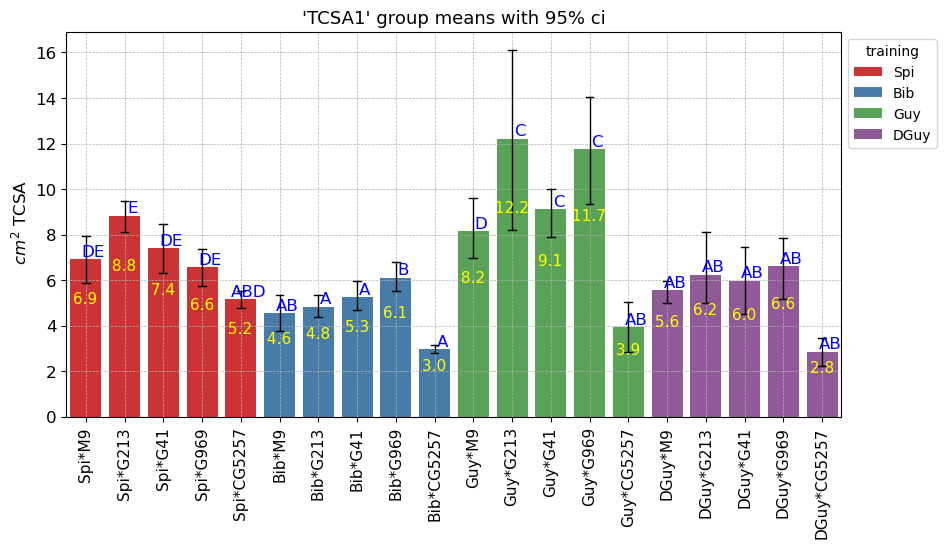

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming df is already defined and contains the necessary columns
hue_order = ["Spi", "Bib", "Guy", "DGuy"]
group_order = ["Spi*M9", "Spi*G213", "Spi*G41", "Spi*G969","Spi*CG5257", "Bib*M9", "Bib*G213", "Bib*G41", "Bib*G969","Bib*CG5257",
               "Guy*M9", "Guy*G213", "Guy*G41", "Guy*G969","Guy*CG5257", "DGuy*M9", "DGuy*G213", "DGuy*G41", "DGuy*G969","DGuy*CG5257"
               ]

plt.figure(figsize=(10, 5))
graph = sns.barplot(data=df, y=var_to_analyze, x="group", order=group_order, hue="training", hue_order=hue_order,
                    errorbar=('ci', 95), capsize=0.2, err_kws={'color': 'black', 'linewidth': 1}, palette="Set1")

sns.move_legend(graph, "upper left", bbox_to_anchor=(1, 1))
plt.grid(which='both', linestyle='--', linewidth=0.5)
plt.title(f"'{var_to_analyze}' group means with 95% ci")
# Remove x and y axis labels
plt.xlabel('')
plt.ylabel(' ${cm}^2$ TCSA', fontsize=12)


# Rotate x values of group by 90 degrees
plt.xticks(rotation=90)

# Increase font size of everything but bar values and Tukey letters
plt.xticks(fontsize=11)
plt.yticks(fontsize=12)
# plt.xlabel(graph.get_xlabel(), fontsize=13)
# plt.ylabel(graph.get_ylabel(), fontsize=14)
plt.title(graph.get_title(), fontsize=13)

# Add Tukey group letters and bar values
unique_groups = df.drop_duplicates(subset=['group'])
unique_groups = unique_groups[['group_letter', 'group']]
for i, row in unique_groups.iterrows():
    x_position = group_order.index(row['group'])
    bar_value = df[df['group'] == row['group']][var_to_analyze].mean()
    graph.text(x_position-0.07, bar_value*0.75, f' {bar_value:.1f}', ha='center', va='center', fontsize=11, color='yellow')
    graph.text(x_position + 0.2, bar_value, f'{row["group_letter"]}', ha='center', va='bottom', fontsize=12, color='blue')

### Late season Trunk TCSA

In [29]:
import pandas as pd

dataset = pd.read_excel(xlss_data_file, sheet_name='all_data', skiprows=1)
display(dataset.head())

columns = [col for col in dataset.columns if col.find('Unnamed')==-1]
dataset = dataset[columns]

var_to_analyze = 'TCSA2'
dataset = dataset.dropna(subset=[var_to_analyze])

display(dataset.head())


# ------------------ Perform ANOVA
model = ols(str(var_to_analyze +' ~ training * Rootstock'), data=dataset).fit()
anova_table = sm.stats.anova_lm(model, typ=3)
anova_df = pd.DataFrame(anova_table)
anova_df['Significance'] = anova_df['PR(>F)'].apply(assign_significance)

print('-------ANOVA TABLE-----------')
display(anova_df)

# Perform ANOVA and Tukey analysis (separate tests for training and Rootstock)
analysis_results = perform_tukey_analysis(dataset, var_to_analyze, anova_df)
df = analysis_results['df'] 
display(df.head())

year  inter-pole training  row  tree Rootstock  early_season_trunk1  \
0  2025           1     DGuy    2     2        M9                21.85   
1  2025           1     DGuy    2     3        M9                24.95   
2  2025           1     DGuy    2     4        M9                  NaN   
3  2025           2     DGuy    2     6      G213                23.77   
4  2025           2     DGuy    2     7      G213                28.06   

   early_season_trunk2  end_season_trunk1a  end_season_trunk1b  ...     kg  \
0                27.39               27.97               24.93  ...    NaN   
1                29.02               29.43               32.58  ...  19.22   
2                  NaN               25.54               23.85  ...  13.66   
3                29.79               29.44               29.19  ...  26.16   
4                39.55               35.81               36.91  ...  25.86   

   time/tree  tree/ha   Yield  yield_eff_2  avg_fruit_weight  harvest_time  \
0        NaN      NaN     NaN          NaN               NaN           NaN   
1       10.0   1600.0  30.752     2.264979        215.955056    266.666667   
2       10.0   1600.0  21.856     2.006713        168.641975    266.666667   
3       15.0   1600.0  41.856     2.765437        192.352941    400.000000   
4       15.0   1600.0  41.376     2.155353        160.621118    400.000000   

   VLIe  PLIe  VPLI  
0   NaN   NaN   NaN  
1   NaN   NaN   NaN  
2   NaN   NaN   NaN  
3   NaN   NaN   NaN  
4   NaN   NaN   NaN  

[5 rows x 36 columns]

year  inter-pole training  row  tree Rootstock  early_season_trunk1  \
0  2025           1     DGuy    2     2        M9                21.85   
1  2025           1     DGuy    2     3        M9                24.95   
2  2025           1     DGuy    2     4        M9                  NaN   
3  2025           2     DGuy    2     6      G213                23.77   
4  2025           2     DGuy    2     7      G213                28.06   

   early_season_trunk2  end_season_trunk1a  end_season_trunk1b  ...     kg  \
0                27.39               27.97               24.93  ...    NaN   
1                29.02               29.43               32.58  ...  19.22   
2                  NaN               25.54               23.85  ...  13.66   
3                29.79               29.44               29.19  ...  26.16   
4                39.55               35.81               36.91  ...  25.86   

   time/tree  tree/ha   Yield  yield_eff_2  avg_fruit_weight  harvest_time  \
0        NaN      NaN     NaN          NaN               NaN           NaN   
1       10.0   1600.0  30.752     2.264979        215.955056    266.666667   
2       10.0   1600.0  21.856     2.006713        168.641975    266.666667   
3       15.0   1600.0  41.856     2.765437        192.352941    400.000000   
4       15.0   1600.0  41.376     2.155353        160.621118    400.000000   

   VLIe  PLIe  VPLI  
0   NaN   NaN   NaN  
1   NaN   NaN   NaN  
2   NaN   NaN   NaN  
3   NaN   NaN   NaN  
4   NaN   NaN   NaN  

[5 rows x 36 columns]

-------ANOVA TABLE-----------


sum_sq     df          F        PR(>F) Significance
Intercept           217.322820    1.0  50.498531  6.090957e-11          ***
training            105.276964    3.0   8.154278  4.947576e-05          ***
Rootstock            37.039703    4.0   2.151696  7.778074e-02            ~
training:Rootstock  234.685438   12.0   4.544418  3.849084e-06          ***
Residual            585.282446  136.0        NaN           NaN


-------TUKEY TEST FOR TRAINING-----------


{'Bib': 'A', 'DGuy': 'A', 'Guy': 'B', 'Spi': 'C'}


-------TRAINING MEANS WITH TUKEY LETTERS-----------


training      TCSA2 Letter
0      Bib   6.797105      A
1     DGuy   8.052307      A
2      Guy  12.812462      B
3      Spi  10.485644      C


-------TUKEY TEST FOR ROOTSTOCK-----------


{'CG5257': 'A', 'G213': 'B', 'G41': 'AB', 'G969': 'B', 'M9': 'A'}


-------ROOTSTOCK MEANS WITH TUKEY LETTERS-----------


Rootstock      TCSA2 Letter
0    CG5257   7.723509      A
1      G213  11.645911      B
2       G41   9.645324     AB
3      G969  10.590236      B
4        M9   8.562250      A


-------TUKEY TEST FOR TRAINING * ROOTSTOCK-----------


{'Bib*CG5257': 'A',
 'Bib*G213': 'A',
 'Bib*G41': 'A',
 'Bib*G969': 'A',
 'Bib*M9': 'A',
 'DGuy*CG5257': 'A',
 'DGuy*G213': 'A',
 'DGuy*G41': 'A',
 'DGuy*G969': 'A',
 'DGuy*M9': 'A',
 'Guy*CG5257': 'A',
 'Guy*G213': 'B',
 'Guy*G41': 'C',
 'Guy*G969': 'B',
 'Guy*M9': 'C',
 'Spi*CG5257': 'C',
 'Spi*G213': 'D',
 'Spi*G41': 'CD',
 'Spi*G969': 'CD',
 'Spi*M9': 'C'}

-------GROUP (TRAINING * ROOTSTOCK)WITH TUKEY LETTERS-----------


training Rootstock      TCSA2        Group Letter
0       Bib    CG5257   5.212039   Bib*CG5257      A
1       Bib      G213   6.826475     Bib*G213      A
2       Bib       G41   7.209573      Bib*G41      A
3       Bib      G969   8.158230     Bib*G969      A
4       Bib        M9   6.527646       Bib*M9      A
5      DGuy    CG5257   5.846511  DGuy*CG5257      A
6      DGuy      G213   9.279614    DGuy*G213      A
7      DGuy       G41   7.841142     DGuy*G41      A
8      DGuy      G969   9.336083    DGuy*G969      A
9      DGuy        M9   7.989560      DGuy*M9      A
10      Guy    CG5257   8.937198   Guy*CG5257      A
11      Guy      G213  18.347648     Guy*G213      B
12      Guy       G41  11.917821      Guy*G41      C
13      Guy      G969  16.252538     Guy*G969      B
14      Guy        M9  10.175514       Guy*M9      C
15      Spi    CG5257   9.315503   Spi*CG5257      C
16      Spi      G213  12.682482     Spi*G213      D
17      Spi       G41  10.837900      Spi*G41     CD
18      Spi      G969   9.798474     Spi*G969     CD
19      Spi        M9   9.398365       Spi*M9      C

year  inter-pole training  row  tree Rootstock  early_season_trunk1  \
0  2025           1     DGuy    2     2        M9                21.85   
1  2025           1     DGuy    2     3        M9                24.95   
2  2025           1     DGuy    2     4        M9                  NaN   
3  2025           2     DGuy    2     6      G213                23.77   
4  2025           2     DGuy    2     7      G213                28.06   

   early_season_trunk2  end_season_trunk1a  end_season_trunk1b  ...  \
0                27.39               27.97               24.93  ...   
1                29.02               29.43               32.58  ...   
2                  NaN               25.54               23.85  ...   
3                29.79               29.44               29.19  ...   
4                39.55               35.81               36.91  ...   

   yield_eff_2  avg_fruit_weight  harvest_time  VLIe  PLIe  VPLI      group  \
0          NaN               NaN           NaN   NaN   NaN   NaN    DGuy*M9   
1     2.264979        215.955056    266.666667   NaN   NaN   NaN    DGuy*M9   
2     2.006713        168.641975    266.666667   NaN   NaN   NaN    DGuy*M9   
3     2.765437        192.352941    400.000000   NaN   NaN   NaN  DGuy*G213   
4     2.155353        160.621118    400.000000   NaN   NaN   NaN  DGuy*G213   

   training_letter  rootstock_letter  group_letter  
0                A                 A             A  
1                A                 A             A  
2                A                 A             A  
3                A                 B             A  
4                A                 B             A  

[5 rows x 40 columns]

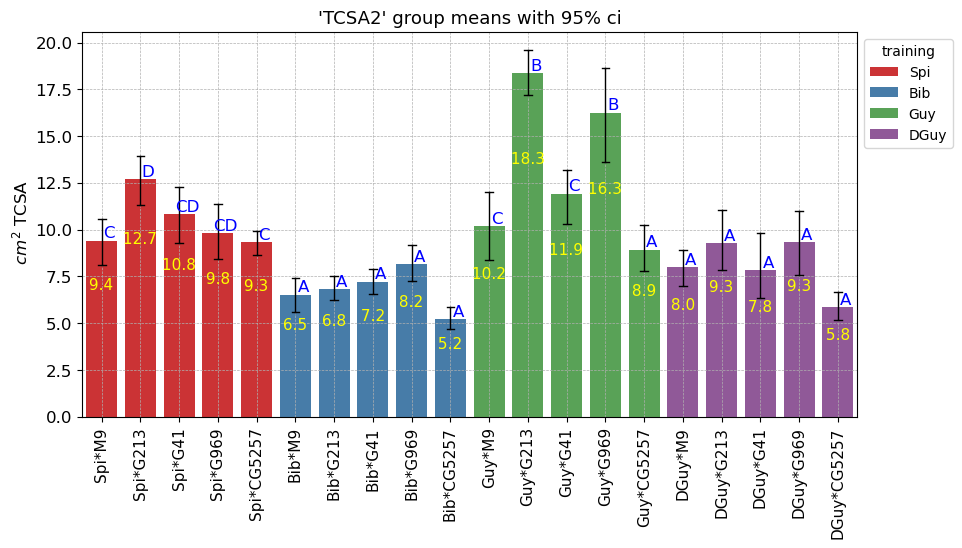

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming df is already defined and contains the necessary columns
hue_order = ["Spi", "Bib", "Guy", "DGuy"]
group_order = ["Spi*M9", "Spi*G213", "Spi*G41", "Spi*G969","Spi*CG5257", "Bib*M9", "Bib*G213", "Bib*G41", "Bib*G969","Bib*CG5257",
               "Guy*M9", "Guy*G213", "Guy*G41", "Guy*G969","Guy*CG5257", "DGuy*M9", "DGuy*G213", "DGuy*G41", "DGuy*G969","DGuy*CG5257"
               ]

plt.figure(figsize=(10, 5))
graph = sns.barplot(data=df, y=var_to_analyze, x="group", order=group_order, hue="training", hue_order=hue_order,
                    errorbar=('ci', 95), capsize=0.2, err_kws={'color': 'black', 'linewidth': 1}, palette="Set1")

sns.move_legend(graph, "upper left", bbox_to_anchor=(1, 1))
plt.grid(which='both', linestyle='--', linewidth=0.5)
plt.title(f"'{var_to_analyze}' group means with 95% ci")
# Remove x and y axis labels
plt.xlabel('')
plt.ylabel(' ${cm}^2$ TCSA', fontsize=12)


# Rotate x values of group by 90 degrees
plt.xticks(rotation=90)

# Increase font size of everything but bar values and Tukey letters
plt.xticks(fontsize=11)
plt.yticks(fontsize=12)
# plt.xlabel(graph.get_xlabel(), fontsize=13)
# plt.ylabel(graph.get_ylabel(), fontsize=14)
plt.title(graph.get_title(), fontsize=13)

# Add Tukey group letters and bar values
unique_groups = df.drop_duplicates(subset=['group'])
unique_groups = unique_groups[['group_letter', 'group']]
for i, row in unique_groups.iterrows():
    x_position = group_order.index(row['group'])
    bar_value = df[df['group'] == row['group']][var_to_analyze].mean()
    graph.text(x_position-0.07, bar_value*0.75, f' {bar_value:.1f}', ha='center', va='center', fontsize=11, color='yellow')
    graph.text(x_position + 0.2, bar_value, f'{row["group_letter"]}', ha='center', va='bottom', fontsize=12, color='blue')

### TCSA_growth


In [31]:
import pandas as pd

dataset = pd.read_excel(xlss_data_file, sheet_name='all_data', skiprows=1)
display(dataset.head())

columns = [col for col in dataset.columns if col.find('Unnamed')==-1]
dataset = dataset[columns]

var_to_analyze = 'TCSA_growth'
dataset = dataset.dropna(subset=[var_to_analyze])

display(dataset.head())


# ------------------ Perform ANOVA
model = ols(str(var_to_analyze +' ~ training * Rootstock'), data=dataset).fit()
anova_table = sm.stats.anova_lm(model, typ=3)
anova_df = pd.DataFrame(anova_table)
anova_df['Significance'] = anova_df['PR(>F)'].apply(assign_significance)

print('-------ANOVA TABLE-----------')
display(anova_df)

# Perform ANOVA and Tukey analysis (separate tests for training and Rootstock)
analysis_results = perform_tukey_analysis(dataset, var_to_analyze, anova_df)
df = analysis_results['df'] 
display(df.head())

year  inter-pole training  row  tree Rootstock  early_season_trunk1  \
0  2025           1     DGuy    2     2        M9                21.85   
1  2025           1     DGuy    2     3        M9                24.95   
2  2025           1     DGuy    2     4        M9                  NaN   
3  2025           2     DGuy    2     6      G213                23.77   
4  2025           2     DGuy    2     7      G213                28.06   

   early_season_trunk2  end_season_trunk1a  end_season_trunk1b  ...     kg  \
0                27.39               27.97               24.93  ...    NaN   
1                29.02               29.43               32.58  ...  19.22   
2                  NaN               25.54               23.85  ...  13.66   
3                29.79               29.44               29.19  ...  26.16   
4                39.55               35.81               36.91  ...  25.86   

   time/tree  tree/ha   Yield  yield_eff_2  avg_fruit_weight  harvest_time  \
0        NaN      NaN     NaN          NaN               NaN           NaN   
1       10.0   1600.0  30.752     2.264979        215.955056    266.666667   
2       10.0   1600.0  21.856     2.006713        168.641975    266.666667   
3       15.0   1600.0  41.856     2.765437        192.352941    400.000000   
4       15.0   1600.0  41.376     2.155353        160.621118    400.000000   

   VLIe  PLIe  VPLI  
0   NaN   NaN   NaN  
1   NaN   NaN   NaN  
2   NaN   NaN   NaN  
3   NaN   NaN   NaN  
4   NaN   NaN   NaN  

[5 rows x 36 columns]

year  inter-pole training  row  tree Rootstock  early_season_trunk1  \
0  2025           1     DGuy    2     2        M9                21.85   
1  2025           1     DGuy    2     3        M9                24.95   
3  2025           2     DGuy    2     6      G213                23.77   
4  2025           2     DGuy    2     7      G213                28.06   
5  2025           3     DGuy    2    10    CG5257                21.26   

   early_season_trunk2  end_season_trunk1a  end_season_trunk1b  ...     kg  \
0                27.39               27.97               24.93  ...    NaN   
1                29.02               29.43               32.58  ...  19.22   
3                29.79               29.44               29.19  ...  26.16   
4                39.55               35.81               36.91  ...  25.86   
5                12.40               32.40               30.35  ...   2.80   

   time/tree  tree/ha   Yield  yield_eff_2  avg_fruit_weight  harvest_time  \
0        NaN      NaN     NaN          NaN               NaN           NaN   
1       10.0   1600.0  30.752     2.264979        215.955056    266.666667   
3       15.0   1600.0  41.856     2.765437        192.352941    400.000000   
4       15.0   1600.0  41.376     2.155353        160.621118    400.000000   
5        2.0   1600.0   4.480     0.561505        175.000000     53.333333   

   VLIe  PLIe  VPLI  
0   NaN   NaN   NaN  
1   NaN   NaN   NaN  
3   NaN   NaN   NaN  
4   NaN   NaN   NaN  
5   NaN   NaN   NaN  

[5 rows x 36 columns]

-------ANOVA TABLE-----------


sum_sq     df          F        PR(>F) Significance
Intercept            40.263946    1.0  33.109753  5.935137e-08          ***
training             23.038728    3.0   6.315051  4.946389e-04          ***
Rootstock             0.689319    4.0   0.141710  9.663448e-01             
training:Rootstock   40.800822   12.0   2.795936  1.995747e-03           **
Residual            158.089762  130.0        NaN           NaN


-------TUKEY TEST FOR TRAINING-----------


{'Bib': 'A', 'DGuy': 'A', 'Guy': 'B', 'Spi': 'B'}


-------TRAINING MEANS WITH TUKEY LETTERS-----------


training  TCSA_growth Letter
0      Bib     2.113739      A
1     DGuy     2.598066      A
2      Guy     3.860799      B
3      Spi     3.446617      B


-------TUKEY TEST FOR TRAINING * ROOTSTOCK-----------


{'Bib*CG5257': 'A',
 'Bib*G213': 'A',
 'Bib*G41': 'A',
 'Bib*G969': 'A',
 'Bib*M9': 'A',
 'DGuy*CG5257': 'A',
 'DGuy*G213': 'A',
 'DGuy*G41': 'A',
 'DGuy*G969': 'A',
 'DGuy*M9': 'A',
 'Guy*CG5257': 'B',
 'Guy*G213': 'B',
 'Guy*G41': 'A',
 'Guy*G969': 'B',
 'Guy*M9': 'A',
 'Spi*CG5257': 'B',
 'Spi*G213': 'B',
 'Spi*G41': 'AB',
 'Spi*G969': 'A',
 'Spi*M9': 'A'}

-------GROUP (TRAINING * ROOTSTOCK)WITH TUKEY LETTERS-----------


training Rootstock  TCSA_growth        Group Letter
0       Bib    CG5257     2.243433   Bib*CG5257      A
1       Bib      G213     1.999960     Bib*G213      A
2       Bib       G41     2.296624      Bib*G41      A
3       Bib      G969     2.054282     Bib*G969      A
4       Bib        M9     1.974396       Bib*M9      A
5      DGuy    CG5257     2.999074  DGuy*CG5257      A
6      DGuy      G213     3.044257    DGuy*G213      A
7      DGuy       G41     1.860757     DGuy*G41      A
8      DGuy      G969     2.734506    DGuy*G969      A
9      DGuy        M9     2.351738      DGuy*M9      A
10      Guy    CG5257     4.332590   Guy*CG5257      B
11      Guy      G213     5.496410     Guy*G213      B
12      Guy       G41     2.802835      Guy*G41      A
13      Guy      G969     5.465215     Guy*G969      B
14      Guy        M9     2.019550       Guy*M9      A
15      Spi    CG5257     4.162737   Spi*CG5257      B
16      Spi      G213     3.854590     Spi*G213      B
17      Spi       G41     3.427398      Spi*G41     AB
18      Spi      G969     3.239372     Spi*G969      A
19      Spi        M9     2.482597       Spi*M9      A

year  inter-pole training  row  tree Rootstock  early_season_trunk1  \
0  2025           1     DGuy    2     2        M9                21.85   
1  2025           1     DGuy    2     3        M9                24.95   
3  2025           2     DGuy    2     6      G213                23.77   
4  2025           2     DGuy    2     7      G213                28.06   
5  2025           3     DGuy    2    10    CG5257                21.26   

   early_season_trunk2  end_season_trunk1a  end_season_trunk1b  ...  \
0                27.39               27.97               24.93  ...   
1                29.02               29.43               32.58  ...   
3                29.79               29.44               29.19  ...   
4                39.55               35.81               36.91  ...   
5                12.40               32.40               30.35  ...   

   yield_eff_2  avg_fruit_weight  harvest_time  VLIe  PLIe  VPLI        group  \
0          NaN               NaN           NaN   NaN   NaN   NaN      DGuy*M9   
1     2.264979        215.955056    266.666667   NaN   NaN   NaN      DGuy*M9   
3     2.765437        192.352941    400.000000   NaN   NaN   NaN    DGuy*G213   
4     2.155353        160.621118    400.000000   NaN   NaN   NaN    DGuy*G213   
5     0.561505        175.000000     53.333333   NaN   NaN   NaN  DGuy*CG5257   

   training_letter  rootstock_letter  group_letter  
0                A                 A             A  
1                A                 A             A  
3                A                 A             A  
4                A                 A             A  
5                A                 A             A  

[5 rows x 40 columns]

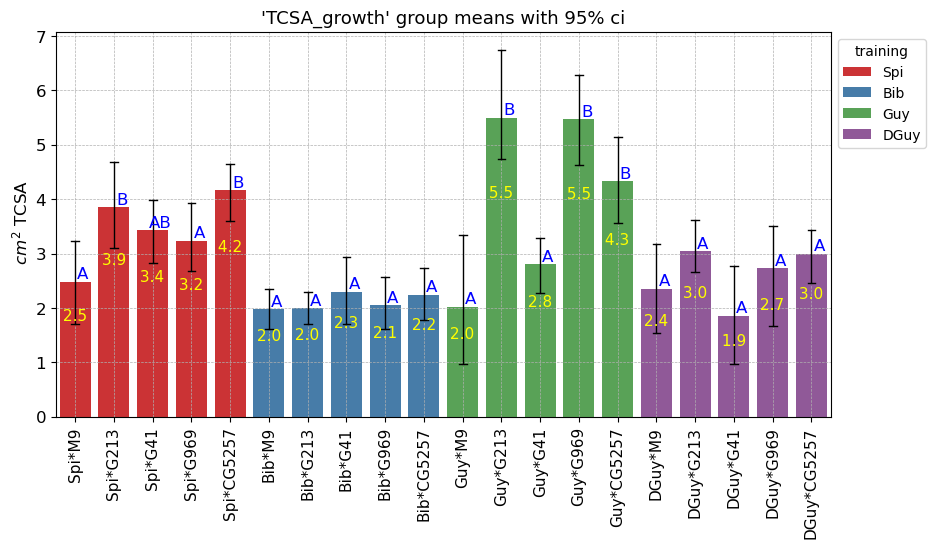

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming df is already defined and contains the necessary columns
hue_order = ["Spi", "Bib", "Guy", "DGuy"]
group_order = ["Spi*M9", "Spi*G213", "Spi*G41", "Spi*G969","Spi*CG5257", "Bib*M9", "Bib*G213", "Bib*G41", "Bib*G969","Bib*CG5257",
               "Guy*M9", "Guy*G213", "Guy*G41", "Guy*G969","Guy*CG5257", "DGuy*M9", "DGuy*G213", "DGuy*G41", "DGuy*G969","DGuy*CG5257"
               ]

plt.figure(figsize=(10, 5))
graph = sns.barplot(data=df, y=var_to_analyze, x="group", order=group_order, hue="training", hue_order=hue_order,
                    errorbar=('ci', 95), capsize=0.2, err_kws={'color': 'black', 'linewidth': 1}, palette="Set1")

sns.move_legend(graph, "upper left", bbox_to_anchor=(1, 1))
plt.grid(which='both', linestyle='--', linewidth=0.5)
plt.title(f"'{var_to_analyze}' group means with 95% ci")
# Remove x and y axis labels
plt.xlabel('')
plt.ylabel(' ${cm}^2$ TCSA', fontsize=12)


# Rotate x values of group by 90 degrees
plt.xticks(rotation=90)

# Increase font size of everything but bar values and Tukey letters
plt.xticks(fontsize=11)
plt.yticks(fontsize=12)
# plt.xlabel(graph.get_xlabel(), fontsize=13)
# plt.ylabel(graph.get_ylabel(), fontsize=14)
plt.title(graph.get_title(), fontsize=13)

# Add Tukey group letters and bar values
unique_groups = df.drop_duplicates(subset=['group'])
unique_groups = unique_groups[['group_letter', 'group']]
for i, row in unique_groups.iterrows():
    x_position = group_order.index(row['group'])
    bar_value = df[df['group'] == row['group']][var_to_analyze].mean()
    graph.text(x_position-0.07, bar_value*0.75, f' {bar_value:.1f}', ha='center', va='center', fontsize=11, color='yellow')
    graph.text(x_position + 0.2, bar_value, f'{row["group_letter"]}', ha='center', va='bottom', fontsize=12, color='blue')

## Tree Height

In [33]:
import pandas as pd

dataset = pd.read_excel(xlss_data_file, sheet_name='all_data', skiprows=1)
display(dataset.head())

columns = [col for col in dataset.columns if col.find('Unnamed')==-1]
dataset = dataset[columns]

var_to_analyze = 'TreeH'
dataset = dataset.dropna(subset=[var_to_analyze])

display(dataset.head())


# ------------------ Perform ANOVA
model = ols(str(var_to_analyze +' ~ training * Rootstock'), data=dataset).fit()
anova_table = sm.stats.anova_lm(model, typ=3)
anova_df = pd.DataFrame(anova_table)
anova_df['Significance'] = anova_df['PR(>F)'].apply(assign_significance)

print('-------ANOVA TABLE-----------')
display(anova_df)

# Perform ANOVA and Tukey analysis (separate tests for training and Rootstock)
analysis_results = perform_tukey_analysis(dataset, var_to_analyze, anova_df)
df = analysis_results['df'] 
display(df.head())

year  inter-pole training  row  tree Rootstock  early_season_trunk1  \
0  2025           1     DGuy    2     2        M9                21.85   
1  2025           1     DGuy    2     3        M9                24.95   
2  2025           1     DGuy    2     4        M9                  NaN   
3  2025           2     DGuy    2     6      G213                23.77   
4  2025           2     DGuy    2     7      G213                28.06   

   early_season_trunk2  end_season_trunk1a  end_season_trunk1b  ...     kg  \
0                27.39               27.97               24.93  ...    NaN   
1                29.02               29.43               32.58  ...  19.22   
2                  NaN               25.54               23.85  ...  13.66   
3                29.79               29.44               29.19  ...  26.16   
4                39.55               35.81               36.91  ...  25.86   

   time/tree  tree/ha   Yield  yield_eff_2  avg_fruit_weight  harvest_time  \
0        NaN      NaN     NaN          NaN               NaN           NaN   
1       10.0   1600.0  30.752     2.264979        215.955056    266.666667   
2       10.0   1600.0  21.856     2.006713        168.641975    266.666667   
3       15.0   1600.0  41.856     2.765437        192.352941    400.000000   
4       15.0   1600.0  41.376     2.155353        160.621118    400.000000   

   VLIe  PLIe  VPLI  
0   NaN   NaN   NaN  
1   NaN   NaN   NaN  
2   NaN   NaN   NaN  
3   NaN   NaN   NaN  
4   NaN   NaN   NaN  

[5 rows x 36 columns]

year  inter-pole training  row  tree Rootstock  early_season_trunk1  \
0  2025           1     DGuy    2     2        M9                21.85   
1  2025           1     DGuy    2     3        M9                24.95   
3  2025           2     DGuy    2     6      G213                23.77   
4  2025           2     DGuy    2     7      G213                28.06   
5  2025           3     DGuy    2    10    CG5257                21.26   

   early_season_trunk2  end_season_trunk1a  end_season_trunk1b  ...     kg  \
0                27.39               27.97               24.93  ...    NaN   
1                29.02               29.43               32.58  ...  19.22   
3                29.79               29.44               29.19  ...  26.16   
4                39.55               35.81               36.91  ...  25.86   
5                12.40               32.40               30.35  ...   2.80   

   time/tree  tree/ha   Yield  yield_eff_2  avg_fruit_weight  harvest_time  \
0        NaN      NaN     NaN          NaN               NaN           NaN   
1       10.0   1600.0  30.752     2.264979        215.955056    266.666667   
3       15.0   1600.0  41.856     2.765437        192.352941    400.000000   
4       15.0   1600.0  41.376     2.155353        160.621118    400.000000   
5        2.0   1600.0   4.480     0.561505        175.000000     53.333333   

   VLIe  PLIe  VPLI  
0   NaN   NaN   NaN  
1   NaN   NaN   NaN  
3   NaN   NaN   NaN  
4   NaN   NaN   NaN  
5   NaN   NaN   NaN  

[5 rows x 36 columns]

-------ANOVA TABLE-----------


sum_sq     df           F        PR(>F)  \
Intercept           639580.500000    1.0  203.115670  2.438466e-28   
training             53104.965204    3.0    5.621628  1.179076e-03   
Rootstock             9809.670152    4.0    0.778830  5.408833e-01   
training:Rootstock   42545.049174   12.0    1.125942  3.447945e-01   
Residual            409350.323341  130.0         NaN           NaN   

                   Significance  
Intercept                   ***  
training                     **  
Rootstock                        
training:Rootstock               
Residual


-------TUKEY TEST FOR TRAINING-----------


{'Bib': 'A', 'DGuy': 'A', 'Guy': 'A', 'Spi': 'B'}


-------TRAINING MEANS WITH TUKEY LETTERS-----------


training       TreeH Letter
0      Bib  292.667260      A
1     DGuy  251.400000      A
2      Guy  271.615400      A
3      Spi  308.716667      B

year  inter-pole training  row  tree Rootstock  early_season_trunk1  \
0  2025           1     DGuy    2     2        M9                21.85   
1  2025           1     DGuy    2     3        M9                24.95   
3  2025           2     DGuy    2     6      G213                23.77   
4  2025           2     DGuy    2     7      G213                28.06   
5  2025           3     DGuy    2    10    CG5257                21.26   

   early_season_trunk2  end_season_trunk1a  end_season_trunk1b  ...  \
0                27.39               27.97               24.93  ...   
1                29.02               29.43               32.58  ...   
3                29.79               29.44               29.19  ...   
4                39.55               35.81               36.91  ...   
5                12.40               32.40               30.35  ...   

   yield_eff_2  avg_fruit_weight  harvest_time  VLIe  PLIe  VPLI        group  \
0          NaN               NaN           NaN   NaN   NaN   NaN      DGuy*M9   
1     2.264979        215.955056    266.666667   NaN   NaN   NaN      DGuy*M9   
3     2.765437        192.352941    400.000000   NaN   NaN   NaN    DGuy*G213   
4     2.155353        160.621118    400.000000   NaN   NaN   NaN    DGuy*G213   
5     0.561505        175.000000     53.333333   NaN   NaN   NaN  DGuy*CG5257   

   training_letter  rootstock_letter  group_letter  
0                A                 A             A  
1                A                 A             A  
3                A                 A             A  
4                A                 A             A  
5                A                 A             A  

[5 rows x 40 columns]

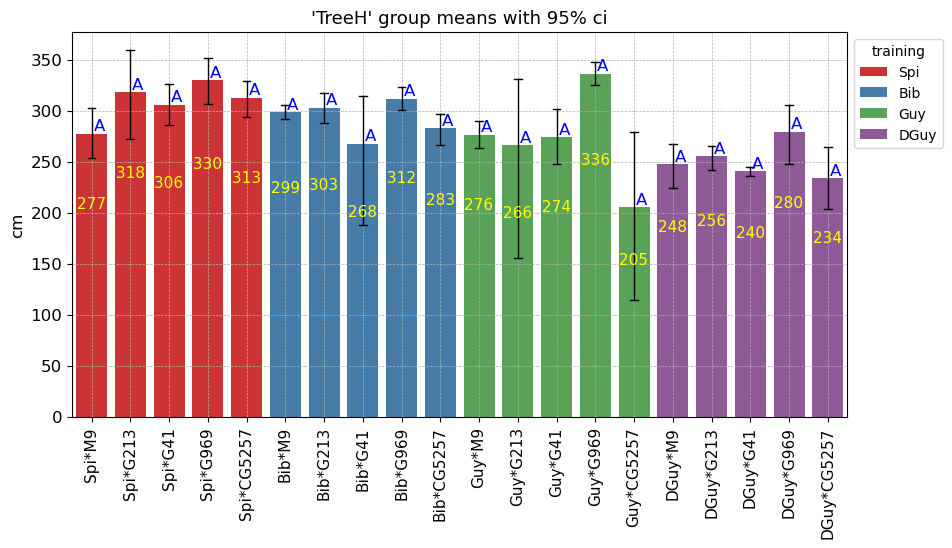

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming df is already defined and contains the necessary columns
hue_order = ["Spi", "Bib", "Guy", "DGuy"]
group_order = ["Spi*M9", "Spi*G213", "Spi*G41", "Spi*G969","Spi*CG5257", "Bib*M9", "Bib*G213", "Bib*G41", "Bib*G969","Bib*CG5257",
               "Guy*M9", "Guy*G213", "Guy*G41", "Guy*G969","Guy*CG5257", "DGuy*M9", "DGuy*G213", "DGuy*G41", "DGuy*G969","DGuy*CG5257"
               ]

plt.figure(figsize=(10, 5))
graph = sns.barplot(data=df, y=var_to_analyze, x="group", order=group_order, hue="training", hue_order=hue_order,
                    errorbar=('ci', 95), capsize=0.2, err_kws={'color': 'black', 'linewidth': 1}, palette="Set1")

sns.move_legend(graph, "upper left", bbox_to_anchor=(1, 1))
plt.grid(which='both', linestyle='--', linewidth=0.5)
plt.title(f"'{var_to_analyze}' group means with 95% ci")
# Remove x and y axis labels
plt.xlabel('')
plt.ylabel('cm', fontsize=12)


# Rotate x values of group by 90 degrees
plt.xticks(rotation=90)

# Increase font size of everything but bar values and Tukey letters
plt.xticks(fontsize=11)
plt.yticks(fontsize=12)
# plt.xlabel(graph.get_xlabel(), fontsize=13)
# plt.ylabel(graph.get_ylabel(), fontsize=14)
plt.title(graph.get_title(), fontsize=13)

# Add Tukey group letters and bar values
unique_groups = df.drop_duplicates(subset=['group'])
unique_groups = unique_groups[['group_letter', 'group']]
for i, row in unique_groups.iterrows():
    x_position = group_order.index(row['group'])
    bar_value = df[df['group'] == row['group']][var_to_analyze].mean()
    graph.text(x_position-0.07, bar_value*0.75, f' {bar_value:.0f}', ha='center', va='center', fontsize=11, color='yellow')
    graph.text(x_position + 0.2, bar_value, f'{row["group_letter"]}', ha='center', va='bottom', fontsize=12, color='blue')

## Tree Volume

In [35]:
import pandas as pd

dataset = pd.read_excel(xlss_data_file, sheet_name='all_data', skiprows=1)
display(dataset.head())

columns = [col for col in dataset.columns if col.find('Unnamed')==-1]
dataset = dataset[columns]

var_to_analyze = 'TreeVol'
dataset = dataset.dropna(subset=[var_to_analyze])

display(dataset.head())


# ------------------ Perform ANOVA
model = ols(str(var_to_analyze +' ~ training * Rootstock'), data=dataset).fit()
anova_table = sm.stats.anova_lm(model, typ=3)
anova_df = pd.DataFrame(anova_table)
anova_df['Significance'] = anova_df['PR(>F)'].apply(assign_significance)

print('-------ANOVA TABLE-----------')
display(anova_df)

# Perform ANOVA and Tukey analysis (separate tests for training and Rootstock)
analysis_results = perform_tukey_analysis(dataset, var_to_analyze, anova_df)
df = analysis_results['df'] 
display(df.head())

year  inter-pole training  row  tree Rootstock  early_season_trunk1  \
0  2025           1     DGuy    2     2        M9                21.85   
1  2025           1     DGuy    2     3        M9                24.95   
2  2025           1     DGuy    2     4        M9                  NaN   
3  2025           2     DGuy    2     6      G213                23.77   
4  2025           2     DGuy    2     7      G213                28.06   

   early_season_trunk2  end_season_trunk1a  end_season_trunk1b  ...     kg  \
0                27.39               27.97               24.93  ...    NaN   
1                29.02               29.43               32.58  ...  19.22   
2                  NaN               25.54               23.85  ...  13.66   
3                29.79               29.44               29.19  ...  26.16   
4                39.55               35.81               36.91  ...  25.86   

   time/tree  tree/ha   Yield  yield_eff_2  avg_fruit_weight  harvest_time  \
0        NaN      NaN     NaN          NaN               NaN           NaN   
1       10.0   1600.0  30.752     2.264979        215.955056    266.666667   
2       10.0   1600.0  21.856     2.006713        168.641975    266.666667   
3       15.0   1600.0  41.856     2.765437        192.352941    400.000000   
4       15.0   1600.0  41.376     2.155353        160.621118    400.000000   

   VLIe  PLIe  VPLI  
0   NaN   NaN   NaN  
1   NaN   NaN   NaN  
2   NaN   NaN   NaN  
3   NaN   NaN   NaN  
4   NaN   NaN   NaN  

[5 rows x 36 columns]

year  inter-pole training  row  tree Rootstock  early_season_trunk1  \
0  2025           1     DGuy    2     2        M9                21.85   
1  2025           1     DGuy    2     3        M9                24.95   
3  2025           2     DGuy    2     6      G213                23.77   
4  2025           2     DGuy    2     7      G213                28.06   
5  2025           3     DGuy    2    10    CG5257                21.26   

   early_season_trunk2  end_season_trunk1a  end_season_trunk1b  ...     kg  \
0                27.39               27.97               24.93  ...    NaN   
1                29.02               29.43               32.58  ...  19.22   
3                29.79               29.44               29.19  ...  26.16   
4                39.55               35.81               36.91  ...  25.86   
5                12.40               32.40               30.35  ...   2.80   

   time/tree  tree/ha   Yield  yield_eff_2  avg_fruit_weight  harvest_time  \
0        NaN      NaN     NaN          NaN               NaN           NaN   
1       10.0   1600.0  30.752     2.264979        215.955056    266.666667   
3       15.0   1600.0  41.856     2.765437        192.352941    400.000000   
4       15.0   1600.0  41.376     2.155353        160.621118    400.000000   
5        2.0   1600.0   4.480     0.561505        175.000000     53.333333   

   VLIe  PLIe  VPLI  
0   NaN   NaN   NaN  
1   NaN   NaN   NaN  
3   NaN   NaN   NaN  
4   NaN   NaN   NaN  
5   NaN   NaN   NaN  

[5 rows x 36 columns]

-------ANOVA TABLE-----------


sum_sq     df          F        PR(>F) Significance
Intercept            94.237229    1.0  63.267665  7.692588e-13          ***
training             98.222821    3.0  21.981152  1.409585e-11          ***
Rootstock             7.165852    4.0   1.202727  3.128081e-01             
training:Rootstock   29.255973   12.0   1.636789  8.898279e-02            ~
Residual            193.635087  130.0        NaN           NaN


-------TUKEY TEST FOR TRAINING-----------


{'Bib': 'A', 'DGuy': 'B', 'Guy': 'A', 'Spi': 'C'}


-------TRAINING MEANS WITH TUKEY LETTERS-----------


training   TreeVol Letter
0      Bib  3.938008      A
1     DGuy  7.314675      B
2      Guy  4.732712      A
3      Spi  1.792145      C


-------TUKEY TEST FOR TRAINING * ROOTSTOCK-----------


{'Bib*CG5257': 'A',
 'Bib*G213': 'A',
 'Bib*G41': 'A',
 'Bib*G969': 'A',
 'Bib*M9': 'A',
 'DGuy*CG5257': 'B',
 'DGuy*G213': 'B',
 'DGuy*G41': 'B',
 'DGuy*G969': 'B',
 'DGuy*M9': 'B',
 'Guy*CG5257': 'A',
 'Guy*G213': 'B',
 'Guy*G41': 'A',
 'Guy*G969': 'B',
 'Guy*M9': 'A',
 'Spi*CG5257': 'C',
 'Spi*G213': 'AC',
 'Spi*G41': 'C',
 'Spi*G969': 'C',
 'Spi*M9': 'C'}

-------GROUP (TRAINING * ROOTSTOCK)WITH TUKEY LETTERS-----------


training Rootstock   TreeVol        Group Letter
0       Bib    CG5257  3.432150   Bib*CG5257      A
1       Bib      G213  4.507763     Bib*G213      A
2       Bib       G41  3.626754      Bib*G41      A
3       Bib      G969  4.368075     Bib*G969      A
4       Bib        M9  3.755300       Bib*M9      A
5      DGuy    CG5257  7.304062  DGuy*CG5257      B
6      DGuy      G213  8.539375    DGuy*G213      B
7      DGuy       G41  6.218000     DGuy*G41      B
8      DGuy      G969  7.884688    DGuy*G969      B
9      DGuy        M9  6.627250      DGuy*M9      B
10      Guy    CG5257  3.348091   Guy*CG5257      A
11      Guy      G213  5.950369     Guy*G213      B
12      Guy       G41  3.867050      Guy*G41      A
13      Guy      G969  6.182500     Guy*G969      B
14      Guy        M9  4.315550       Guy*M9      A
15      Spi    CG5257  1.611314   Spi*CG5257      C
16      Spi      G213  2.964610     Spi*G213     AC
17      Spi       G41  1.652377      Spi*G41      C
18      Spi      G969  1.327707     Spi*G969      C
19      Spi        M9  1.404717       Spi*M9      C

year  inter-pole training  row  tree Rootstock  early_season_trunk1  \
0  2025           1     DGuy    2     2        M9                21.85   
1  2025           1     DGuy    2     3        M9                24.95   
3  2025           2     DGuy    2     6      G213                23.77   
4  2025           2     DGuy    2     7      G213                28.06   
5  2025           3     DGuy    2    10    CG5257                21.26   

   early_season_trunk2  end_season_trunk1a  end_season_trunk1b  ...  \
0                27.39               27.97               24.93  ...   
1                29.02               29.43               32.58  ...   
3                29.79               29.44               29.19  ...   
4                39.55               35.81               36.91  ...   
5                12.40               32.40               30.35  ...   

   yield_eff_2  avg_fruit_weight  harvest_time  VLIe  PLIe  VPLI        group  \
0          NaN               NaN           NaN   NaN   NaN   NaN      DGuy*M9   
1     2.264979        215.955056    266.666667   NaN   NaN   NaN      DGuy*M9   
3     2.765437        192.352941    400.000000   NaN   NaN   NaN    DGuy*G213   
4     2.155353        160.621118    400.000000   NaN   NaN   NaN    DGuy*G213   
5     0.561505        175.000000     53.333333   NaN   NaN   NaN  DGuy*CG5257   

   training_letter  rootstock_letter  group_letter  
0                B                 A             B  
1                B                 A             B  
3                B                 A             B  
4                B                 A             B  
5                B                 A             B  

[5 rows x 40 columns]

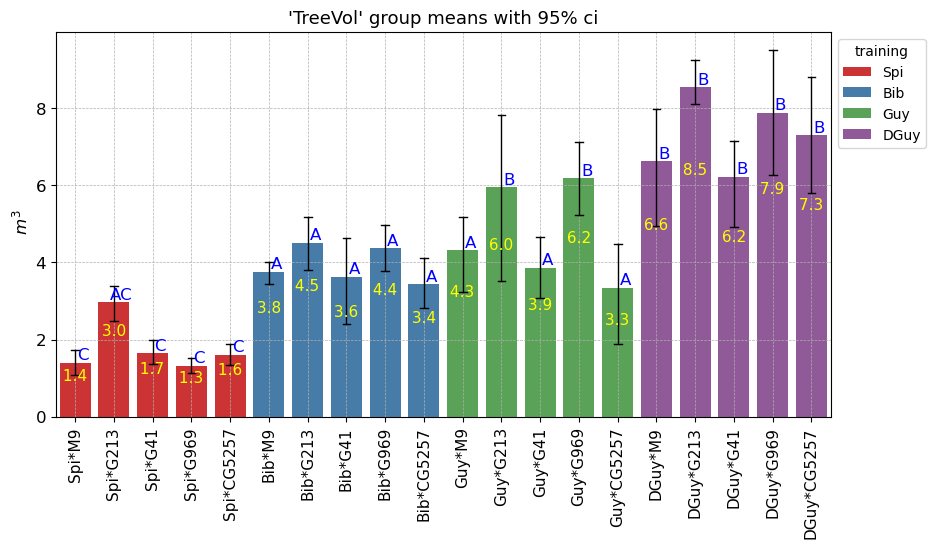

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming df is already defined and contains the necessary columns
hue_order = ["Spi", "Bib", "Guy", "DGuy"]
group_order = ["Spi*M9", "Spi*G213", "Spi*G41", "Spi*G969","Spi*CG5257", "Bib*M9", "Bib*G213", "Bib*G41", "Bib*G969","Bib*CG5257",
               "Guy*M9", "Guy*G213", "Guy*G41", "Guy*G969","Guy*CG5257", "DGuy*M9", "DGuy*G213", "DGuy*G41", "DGuy*G969","DGuy*CG5257"
               ]

plt.figure(figsize=(10, 5))
graph = sns.barplot(data=df, y=var_to_analyze, x="group", order=group_order, hue="training", hue_order=hue_order,
                    errorbar=('ci', 95), capsize=0.2, err_kws={'color': 'black', 'linewidth': 1}, palette="Set1")

sns.move_legend(graph, "upper left", bbox_to_anchor=(1, 1))
plt.grid(which='both', linestyle='--', linewidth=0.5)
plt.title(f"'{var_to_analyze}' group means with 95% ci")
# Remove x and y axis labels
plt.xlabel('')
plt.ylabel(' ${m}^3$', fontsize=12)


# Rotate x values of group by 90 degrees
plt.xticks(rotation=90)

# Increase font size of everything but bar values and Tukey letters
plt.xticks(fontsize=11)
plt.yticks(fontsize=12)
# plt.xlabel(graph.get_xlabel(), fontsize=13)
# plt.ylabel(graph.get_ylabel(), fontsize=14)
plt.title(graph.get_title(), fontsize=13)

# Add Tukey group letters and bar values
unique_groups = df.drop_duplicates(subset=['group'])
unique_groups = unique_groups[['group_letter', 'group']]
for i, row in unique_groups.iterrows():
    x_position = group_order.index(row['group'])
    bar_value = df[df['group'] == row['group']][var_to_analyze].mean()
    graph.text(x_position-0.07, bar_value*0.75, f' {bar_value:.1f}', ha='center', va='center', fontsize=11, color='yellow')
    graph.text(x_position + 0.2, bar_value, f'{row["group_letter"]}', ha='center', va='bottom', fontsize=12, color='blue')

## Tot. Shoot Length

In [37]:
import pandas as pd

dataset = pd.read_excel(xlss_data_file, sheet_name='all_data', skiprows=1)
display(dataset.head())

columns = [col for col in dataset.columns if col.find('Unnamed')==-1]
dataset = dataset[columns]

var_to_analyze = 'TotShootLenght'
dataset['TotShootLenght'] = dataset['TotShootLenght'] /100
dataset = dataset.dropna(subset=[var_to_analyze])

display(dataset.head())


# ------------------ Perform ANOVA
model = ols(str(var_to_analyze +' ~ training * Rootstock'), data=dataset).fit()
anova_table = sm.stats.anova_lm(model, typ=3)
anova_df = pd.DataFrame(anova_table)
anova_df['Significance'] = anova_df['PR(>F)'].apply(assign_significance)

print('-------ANOVA TABLE-----------')
display(anova_df)

# Perform ANOVA and Tukey analysis (separate tests for training and Rootstock)
analysis_results = perform_tukey_analysis(dataset, var_to_analyze, anova_df)
df = analysis_results['df'] 
display(df.head())

year  inter-pole training  row  tree Rootstock  early_season_trunk1  \
0  2025           1     DGuy    2     2        M9                21.85   
1  2025           1     DGuy    2     3        M9                24.95   
2  2025           1     DGuy    2     4        M9                  NaN   
3  2025           2     DGuy    2     6      G213                23.77   
4  2025           2     DGuy    2     7      G213                28.06   

   early_season_trunk2  end_season_trunk1a  end_season_trunk1b  ...     kg  \
0                27.39               27.97               24.93  ...    NaN   
1                29.02               29.43               32.58  ...  19.22   
2                  NaN               25.54               23.85  ...  13.66   
3                29.79               29.44               29.19  ...  26.16   
4                39.55               35.81               36.91  ...  25.86   

   time/tree  tree/ha   Yield  yield_eff_2  avg_fruit_weight  harvest_time  \
0        NaN      NaN     NaN          NaN               NaN           NaN   
1       10.0   1600.0  30.752     2.264979        215.955056    266.666667   
2       10.0   1600.0  21.856     2.006713        168.641975    266.666667   
3       15.0   1600.0  41.856     2.765437        192.352941    400.000000   
4       15.0   1600.0  41.376     2.155353        160.621118    400.000000   

   VLIe  PLIe  VPLI  
0   NaN   NaN   NaN  
1   NaN   NaN   NaN  
2   NaN   NaN   NaN  
3   NaN   NaN   NaN  
4   NaN   NaN   NaN  

[5 rows x 36 columns]

year  inter-pole training  row  tree Rootstock  early_season_trunk1  \
0  2025           1     DGuy    2     2        M9                21.85   
1  2025           1     DGuy    2     3        M9                24.95   
3  2025           2     DGuy    2     6      G213                23.77   
4  2025           2     DGuy    2     7      G213                28.06   
5  2025           3     DGuy    2    10    CG5257                21.26   

   early_season_trunk2  end_season_trunk1a  end_season_trunk1b  ...     kg  \
0                27.39               27.97               24.93  ...    NaN   
1                29.02               29.43               32.58  ...  19.22   
3                29.79               29.44               29.19  ...  26.16   
4                39.55               35.81               36.91  ...  25.86   
5                12.40               32.40               30.35  ...   2.80   

   time/tree  tree/ha   Yield  yield_eff_2  avg_fruit_weight  harvest_time  \
0        NaN      NaN     NaN          NaN               NaN           NaN   
1       10.0   1600.0  30.752     2.264979        215.955056    266.666667   
3       15.0   1600.0  41.856     2.765437        192.352941    400.000000   
4       15.0   1600.0  41.376     2.155353        160.621118    400.000000   
5        2.0   1600.0   4.480     0.561505        175.000000     53.333333   

   VLIe  PLIe  VPLI  
0   NaN   NaN   NaN  
1   NaN   NaN   NaN  
3   NaN   NaN   NaN  
4   NaN   NaN   NaN  
5   NaN   NaN   NaN  

[5 rows x 36 columns]

-------ANOVA TABLE-----------


sum_sq     df         F        PR(>F) Significance
Intercept             59.841800    1.0  6.107114  1.475756e-02            *
training              52.077676    3.0  1.771584  1.557839e-01             
Rootstock              8.810126    4.0  0.224778  9.241475e-01             
training:Rootstock  1048.833352   12.0  8.919830  2.758449e-12          ***
Residual            1273.831557  130.0       NaN           NaN


-------TUKEY TEST FOR TRAINING * ROOTSTOCK-----------


{'Bib*CG5257': 'A',
 'Bib*G213': 'A',
 'Bib*G41': 'A',
 'Bib*G969': 'A',
 'Bib*M9': 'A',
 'DGuy*CG5257': 'A',
 'DGuy*G213': 'B',
 'DGuy*G41': 'B',
 'DGuy*G969': 'B',
 'DGuy*M9': 'B',
 'Guy*CG5257': 'A',
 'Guy*G213': 'C',
 'Guy*G41': 'BC',
 'Guy*G969': 'D',
 'Guy*M9': 'B',
 'Spi*CG5257': 'A',
 'Spi*G213': 'A',
 'Spi*G41': 'A',
 'Spi*G969': 'A',
 'Spi*M9': 'A'}

-------GROUP (TRAINING * ROOTSTOCK)WITH TUKEY LETTERS-----------


training Rootstock  TotShootLenght        Group Letter
0       Bib    CG5257        2.735000   Bib*CG5257      A
1       Bib      G213        3.710000     Bib*G213      A
2       Bib       G41        2.450130      Bib*G41      A
3       Bib      G969        3.411250     Bib*G969      A
4       Bib        M9        2.762500       Bib*M9      A
5      DGuy    CG5257        4.317500  DGuy*CG5257      A
6      DGuy      G213       19.275000    DGuy*G213      B
7      DGuy       G41       12.172500     DGuy*G41      B
8      DGuy      G969       14.062500    DGuy*G969      B
9      DGuy        M9       14.272500      DGuy*M9      B
10      Guy    CG5257        6.556829   Guy*CG5257      A
11      Guy      G213       21.142187     Guy*G213      C
12      Guy       G41       14.916667      Guy*G41     BC
13      Guy      G969       23.970000     Guy*G969      D
14      Guy        M9       12.881667       Guy*M9      B
15      Spi    CG5257        3.835000   Spi*CG5257      A
16      Spi      G213        5.586667     Spi*G213      A
17      Spi       G41        4.258333      Spi*G41      A
18      Spi      G969        3.260000     Spi*G969      A
19      Spi        M9        3.506667       Spi*M9      A

year  inter-pole training  row  tree Rootstock  early_season_trunk1  \
0  2025           1     DGuy    2     2        M9                21.85   
1  2025           1     DGuy    2     3        M9                24.95   
3  2025           2     DGuy    2     6      G213                23.77   
4  2025           2     DGuy    2     7      G213                28.06   
5  2025           3     DGuy    2    10    CG5257                21.26   

   early_season_trunk2  end_season_trunk1a  end_season_trunk1b  ...  \
0                27.39               27.97               24.93  ...   
1                29.02               29.43               32.58  ...   
3                29.79               29.44               29.19  ...   
4                39.55               35.81               36.91  ...   
5                12.40               32.40               30.35  ...   

   yield_eff_2  avg_fruit_weight  harvest_time  VLIe  PLIe  VPLI        group  \
0          NaN               NaN           NaN   NaN   NaN   NaN      DGuy*M9   
1     2.264979        215.955056    266.666667   NaN   NaN   NaN      DGuy*M9   
3     2.765437        192.352941    400.000000   NaN   NaN   NaN    DGuy*G213   
4     2.155353        160.621118    400.000000   NaN   NaN   NaN    DGuy*G213   
5     0.561505        175.000000     53.333333   NaN   NaN   NaN  DGuy*CG5257   

   training_letter  rootstock_letter  group_letter  
0                A                 A             B  
1                A                 A             B  
3                A                 A             B  
4                A                 A             B  
5                A                 A             A  

[5 rows x 40 columns]

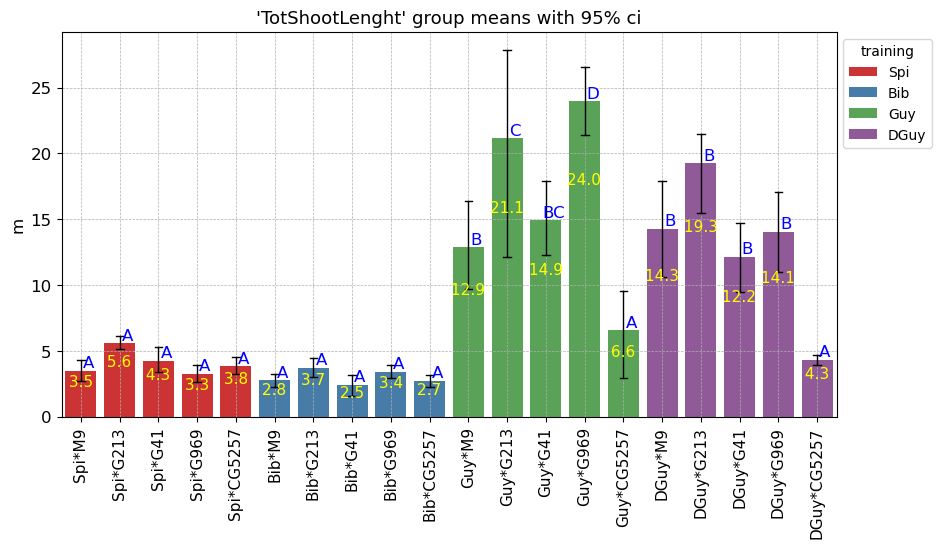

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming df is already defined and contains the necessary columns
hue_order = ["Spi", "Bib", "Guy", "DGuy"]
group_order = ["Spi*M9", "Spi*G213", "Spi*G41", "Spi*G969","Spi*CG5257", "Bib*M9", "Bib*G213", "Bib*G41", "Bib*G969","Bib*CG5257",
               "Guy*M9", "Guy*G213", "Guy*G41", "Guy*G969","Guy*CG5257", "DGuy*M9", "DGuy*G213", "DGuy*G41", "DGuy*G969","DGuy*CG5257"
               ]

plt.figure(figsize=(10, 5))
graph = sns.barplot(data=df, y=var_to_analyze, x="group", order=group_order, hue="training", hue_order=hue_order,
                    errorbar=('ci', 95), capsize=0.2, err_kws={'color': 'black', 'linewidth': 1}, palette="Set1")

sns.move_legend(graph, "upper left", bbox_to_anchor=(1, 1))
plt.grid(which='both', linestyle='--', linewidth=0.5)
plt.title(f"'{var_to_analyze}' group means with 95% ci")
# Remove x and y axis labels
plt.xlabel('')
plt.ylabel('m', fontsize=12)


# Rotate x values of group by 90 degrees
plt.xticks(rotation=90)

# Increase font size of everything but bar values and Tukey letters
plt.xticks(fontsize=11)
plt.yticks(fontsize=12)
# plt.xlabel(graph.get_xlabel(), fontsize=13)
# plt.ylabel(graph.get_ylabel(), fontsize=14)
plt.title(graph.get_title(), fontsize=13)

# Add Tukey group letters and bar values
unique_groups = df.drop_duplicates(subset=['group'])
unique_groups = unique_groups[['group_letter', 'group']]
for i, row in unique_groups.iterrows():
    x_position = group_order.index(row['group'])
    bar_value = df[df['group'] == row['group']][var_to_analyze].mean()
    graph.text(x_position-0.07, bar_value*0.75, f' {bar_value:.1f}', ha='center', va='center', fontsize=11, color='yellow')
    graph.text(x_position + 0.2, bar_value, f'{row["group_letter"]}', ha='center', va='bottom', fontsize=12, color='blue')

# Suckers  TBD

## Suckers N

year  inter-pole training  row  tree Rootstock  early_season_trunk1  \
0  2025           1     DGuy    2     2        M9                21.85   
1  2025           1     DGuy    2     3        M9                24.95   
2  2025           1     DGuy    2     4        M9                  NaN   
3  2025           2     DGuy    2     6      G213                23.77   
4  2025           2     DGuy    2     7      G213                28.06   

   early_season_trunk2  end_season_trunk1a  end_season_trunk1b  ...     kg  \
0                27.39               27.97               24.93  ...    NaN   
1                29.02               29.43               32.58  ...  19.22   
2                  NaN               25.54               23.85  ...  13.66   
3                29.79               29.44               29.19  ...  26.16   
4                39.55               35.81               36.91  ...  25.86   

   time/tree  tree/ha   Yield  yield_eff_2  avg_fruit_weight  harvest_time  \
0        NaN      NaN     NaN          NaN               NaN           NaN   
1       10.0   1600.0  30.752     2.264979        215.955056    266.666667   
2       10.0   1600.0  21.856     2.006713        168.641975    266.666667   
3       15.0   1600.0  41.856     2.765437        192.352941    400.000000   
4       15.0   1600.0  41.376     2.155353        160.621118    400.000000   

   VLIe  PLIe  VPLI  
0   NaN   NaN   NaN  
1   NaN   NaN   NaN  
2   NaN   NaN   NaN  
3   NaN   NaN   NaN  
4   NaN   NaN   NaN  

[5 rows x 36 columns]

-------ANOVA TABLE-----------


sum_sq     df         F    PR(>F) Significance
Intercept              0.125000    1.0  0.013677  0.907078             
training               4.491667    3.0  0.163820  0.920558             
Rootstock             65.850000    4.0  1.801264  0.132338             
training:Rootstock   198.372964   12.0  1.808768  0.052773            ~
Residual            1206.402930  132.0       NaN       NaN


-------TUKEY TEST FOR TRAINING * ROOTSTOCK-----------


{'Bib*CG5257': 'A',
 'Bib*G213': 'A',
 'Bib*G41': 'A',
 'Bib*G969': 'A',
 'Bib*M9': 'A',
 'DGuy*CG5257': 'A',
 'DGuy*G213': 'A',
 'DGuy*G41': 'A',
 'DGuy*G969': 'A',
 'DGuy*M9': 'A',
 'Guy*CG5257': 'A',
 'Guy*G213': 'A',
 'Guy*G41': 'A',
 'Guy*G969': 'A',
 'Guy*M9': 'A',
 'Spi*CG5257': 'A',
 'Spi*G213': 'A',
 'Spi*G41': 'A',
 'Spi*G969': 'A',
 'Spi*M9': 'B'}

-------GROUP (TRAINING * ROOTSTOCK)WITH TUKEY LETTERS-----------


training Rootstock   SuckerN        Group Letter
0       Bib    CG5257  0.125000   Bib*CG5257      A
1       Bib      G213  3.000000     Bib*G213      A
2       Bib       G41  2.750000      Bib*G41      A
3       Bib      G969  0.000000     Bib*G969      A
4       Bib        M9  0.875000       Bib*M9      A
5      DGuy    CG5257  0.000000  DGuy*CG5257      A
6      DGuy      G213  1.500000    DGuy*G213      A
7      DGuy       G41  3.000000     DGuy*G41      A
8      DGuy      G969  2.000000    DGuy*G969      A
9      DGuy        M9  3.250000      DGuy*M9      A
10      Guy    CG5257  1.000000   Guy*CG5257      A
11      Guy      G213  2.000000     Guy*G213      A
12      Guy       G41  3.166667      Guy*G41      A
13      Guy      G969  0.666667     Guy*G969      A
14      Guy        M9  3.166667       Guy*M9      A
15      Spi    CG5257  0.000000   Spi*CG5257      A
16      Spi      G213  2.928571     Spi*G213      A
17      Spi       G41  2.230769      Spi*G41      A
18      Spi      G969  4.250000     Spi*G969      A
19      Spi        M9  6.583333       Spi*M9      B

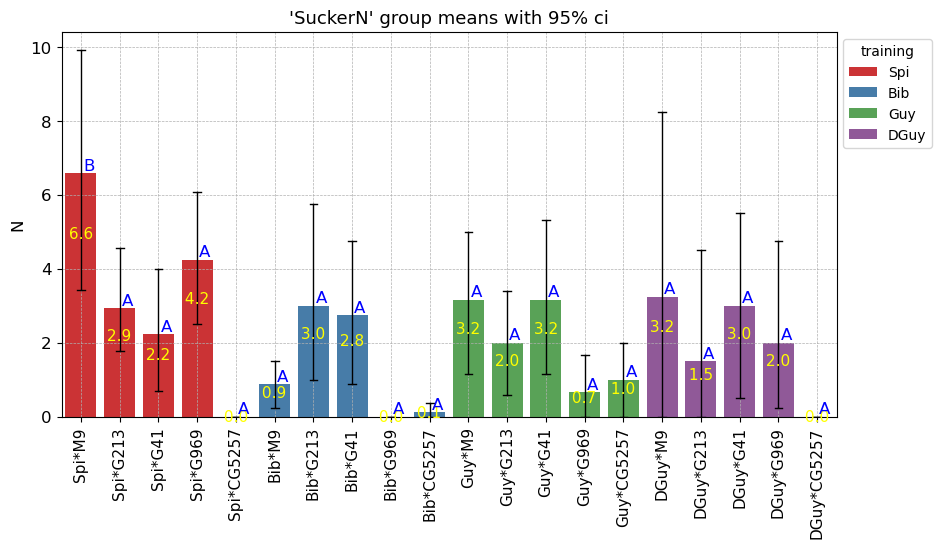

In [39]:
dataset = pd.read_excel(xlss_data_file, sheet_name='all_data', skiprows=1)
display(dataset.head())

var_to_analyze = 'SuckerN'

dataset = dataset.dropna(subset=[var_to_analyze])
# print(dataset)
# ------------------ Perform ANOVA
model = ols(str(var_to_analyze +' ~ training * Rootstock'), data=dataset).fit()
anova_table = sm.stats.anova_lm(model, typ=3)
anova_df = pd.DataFrame(anova_table)
anova_df['Significance'] = anova_df['PR(>F)'].apply(assign_significance)

print('-------ANOVA TABLE-----------')
display(anova_df)

# Perform ANOVA and Tukey analysis (separate tests for training and Rootstock)
analysis_results = perform_tukey_analysis(dataset, var_to_analyze, anova_df)

# Plotting
df = analysis_results['df'] 
# display(df.head())
measure_unit = 'N'
analysis_barplot_with_letters(df, var_to_analyze,measure_unit, round_unit=1)

# BKnoots

year  inter-pole training  row  tree Rootstock  early_season_trunk1  \
0  2025           1     DGuy    2     2        M9                21.85   
1  2025           1     DGuy    2     3        M9                24.95   
2  2025           1     DGuy    2     4        M9                  NaN   
3  2025           2     DGuy    2     6      G213                23.77   
4  2025           2     DGuy    2     7      G213                28.06   

   early_season_trunk2  end_season_trunk1a  end_season_trunk1b  ...     kg  \
0                27.39               27.97               24.93  ...    NaN   
1                29.02               29.43               32.58  ...  19.22   
2                  NaN               25.54               23.85  ...  13.66   
3                29.79               29.44               29.19  ...  26.16   
4                39.55               35.81               36.91  ...  25.86   

   time/tree  tree/ha   Yield  yield_eff_2  avg_fruit_weight  harvest_time  \
0        NaN      NaN     NaN          NaN               NaN           NaN   
1       10.0   1600.0  30.752     2.264979        215.955056    266.666667   
2       10.0   1600.0  21.856     2.006713        168.641975    266.666667   
3       15.0   1600.0  41.856     2.765437        192.352941    400.000000   
4       15.0   1600.0  41.376     2.155353        160.621118    400.000000   

   VLIe  PLIe  VPLI  
0   NaN   NaN   NaN  
1   NaN   NaN   NaN  
2   NaN   NaN   NaN  
3   NaN   NaN   NaN  
4   NaN   NaN   NaN  

[5 rows x 36 columns]

-------ANOVA TABLE-----------


sum_sq     df          F        PR(>F) Significance
Intercept            12.500000    1.0  13.572063  3.338367e-04          ***
training              2.383333    3.0   0.862580  4.623553e-01             
Rootstock            60.350000    4.0  16.381481  6.403511e-11          ***
training:Rootstock   21.352534   12.0   1.931986  3.587297e-02            *
Residual            121.573260  132.0        NaN           NaN


-------TUKEY TEST FOR ROOTSTOCK-----------


{'CG5257': 'A', 'G213': 'B', 'G41': 'AB', 'G969': 'A', 'M9': 'C'}


-------ROOTSTOCK MEANS WITH TUKEY LETTERS-----------


Rootstock   Bknoots Letter
0    CG5257  1.700000      A
1      G213  0.903226      B
2       G41  1.548387     AB
3      G969  2.300000      A
4        M9  4.233333      C


-------TUKEY TEST FOR TRAINING * ROOTSTOCK-----------


{'Bib*CG5257': 'A',
 'Bib*G213': 'A',
 'Bib*G41': 'A',
 'Bib*G969': 'A',
 'Bib*M9': 'B',
 'DGuy*CG5257': 'A',
 'DGuy*G213': 'A',
 'DGuy*G41': 'A',
 'DGuy*G969': 'A',
 'DGuy*M9': 'B',
 'Guy*CG5257': 'A',
 'Guy*G213': 'A',
 'Guy*G41': 'A',
 'Guy*G969': 'A',
 'Guy*M9': 'B',
 'Spi*CG5257': 'A',
 'Spi*G213': 'A',
 'Spi*G41': 'A',
 'Spi*G969': 'B',
 'Spi*M9': 'C'}

-------GROUP (TRAINING * ROOTSTOCK)WITH TUKEY LETTERS-----------


training Rootstock   Bknoots        Group Letter
0       Bib    CG5257  1.250000   Bib*CG5257      A
1       Bib      G213  0.625000     Bib*G213      A
2       Bib       G41  1.250000      Bib*G41      A
3       Bib      G969  2.250000     Bib*G969      A
4       Bib        M9  4.125000       Bib*M9      B
5      DGuy    CG5257  1.750000  DGuy*CG5257      A
6      DGuy      G213  0.500000    DGuy*G213      A
7      DGuy       G41  0.500000     DGuy*G41      A
8      DGuy      G969  0.500000    DGuy*G969      A
9      DGuy        M9  3.750000      DGuy*M9      B
10      Guy    CG5257  2.000000   Guy*CG5257      A
11      Guy      G213  1.000000     Guy*G213      A
12      Guy       G41  2.000000      Guy*G41      A
13      Guy      G969  1.666667     Guy*G969      A
14      Guy        M9  3.500000       Guy*M9      B
15      Spi    CG5257  1.833333   Spi*CG5257      A
16      Spi      G213  1.142857     Spi*G213      A
17      Spi       G41  1.846154      Spi*G41      A
18      Spi      G969  3.250000     Spi*G969      B
19      Spi        M9  4.833333       Spi*M9      C

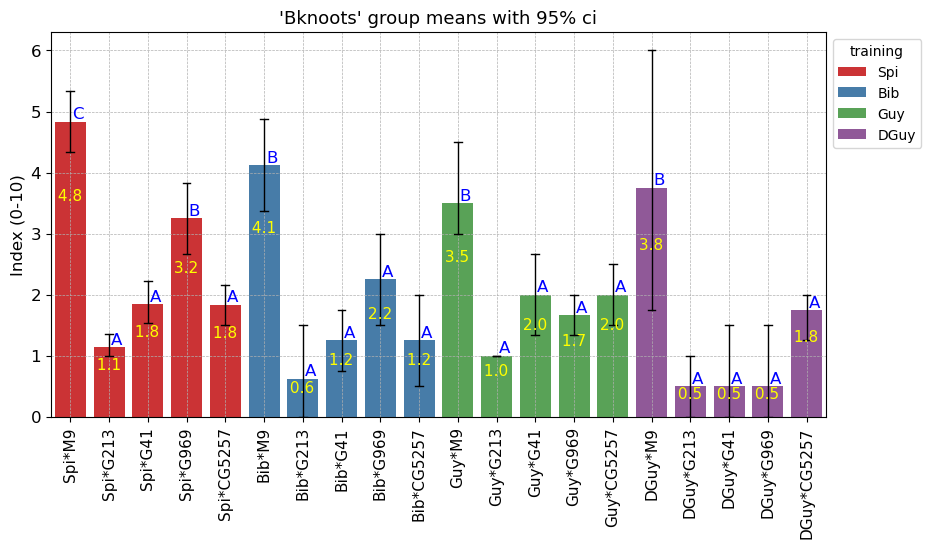

In [40]:
dataset = pd.read_excel(xlss_data_file, sheet_name='all_data', skiprows=1)
display(dataset.head())

var_to_analyze = 'Bknoots'

dataset = dataset.dropna(subset=[var_to_analyze])

# ------------------ Perform ANOVA
model = ols(str(var_to_analyze +' ~ training * Rootstock'), data=dataset).fit()
anova_table = sm.stats.anova_lm(model, typ=3)
anova_df = pd.DataFrame(anova_table)
anova_df['Significance'] = anova_df['PR(>F)'].apply(assign_significance)

print('-------ANOVA TABLE-----------')
display(anova_df)

# Perform ANOVA and Tukey analysis (separate tests for training and Rootstock)
analysis_results = perform_tukey_analysis(dataset, var_to_analyze, anova_df)

# Plotting
df = analysis_results['df'] 
# display(df.head())
measure_unit = 'Index (0-10)'
analysis_barplot_with_letters(df, var_to_analyze,measure_unit, round_unit=1)

# TBD - Efficiency and REQUIRED combined plots

## VLIe PLIe and VPLI

In [ ]:
dataset = pd.read_excel('Agromillora correzzione errori IA (2025).xlsx', sheet_name='efficiency eval', skiprows=65)

dataset.head()

# Skip unnamed columns
columns = [col for col in dataset.columns if col.find('Unnamed')==-1]
dataset = dataset[columns]
display(dataset.head())



In [ ]:
df = dataset.copy()

# Create the 'groups' column
df['groups'] = df['Training System'] + '*' + df['Rootstock']

# Melt the dataframe for barplot
df_melted = df.melt(id_vars=['groups'], value_vars=['VLIe', 'PLIe'], var_name='Variable', value_name='Value')

# Create the barplot
fig, ax1 = plt.subplots(figsize=(9, 5))
sns.barplot(data=df_melted, x='groups', y='Value', hue='Variable',palette={'PLIe': 'red', 'VLIe': 'green'}, errorbar=None, ax=ax1)
# Rotate x values of group by 90 degrees
plt.xticks(rotation=90)

# Add the pointplot for VPLI
ax2 = ax1.twinx()
sns.pointplot(data=df, x='groups', y='VPLI', color='black', errorbar=None, ax=ax2,linestyles='--' )

# Set labels and titles
ax1.set_title('Barplot for VLIe and PLIe with Pointplot for VPLI')
ax1.set_xlabel('Groups')
ax1.set_ylabel('Value (VLIe and PLIe)')
ax2.set_ylabel('Value (VPLI)')

# Increase font size of everything but bar values and Tukey letters
ax1.tick_params(axis='x', labelsize=14)
ax1.tick_params(axis='y', labelsize=14)
ax2.tick_params(axis='y', labelsize=14)
ax1.set_xlabel(ax1.get_xlabel(), fontsize=14)
ax1.set_ylabel(ax1.get_ylabel(), fontsize=14)
ax2.set_ylabel(ax2.get_ylabel(), fontsize=14)
ax1.set_title(ax1.get_title(), fontsize=16)
ax1.legend(title='Variable', title_fontsize=14, fontsize=14)


plt.grid(True)
plt.show()

## Yield and fruit diam

In [ ]:
dataset = pd.read_excel('Bortolotti_Agromillora_Qualità_2024_local.xlsx', sheet_name='efficiency eval', skiprows=65)
# Skip unnamed columns
columns = [col for col in dataset.columns if col.find('Unnamed')==-1]
dataset = dataset[columns]
display(dataset)



In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'dataset' is already defined
df = dataset.copy()

# Create the 'groups' column
df['groups'] = df['Training System'] + '*' + df['Rootstock']

hue_order = ["Spi", "Bib", "Guy", "DGuy"]
group_order = ["Spi*M9", "Spi*G213", "Spi*G41", "Spi*G969", "Bib*M9", "Bib*G213", "Bib*G41", "Bib*G969", 
               "Guy*M9", "Guy*G213", "Guy*G41", "Guy*G969", "DGuy*M9", "DGuy*G213", "DGuy*G41", "DGuy*G969"]

# Create the barplot
fig, ax1 = plt.subplots(figsize=(9, 5))
barplot = sns.barplot(data=df, x='groups', y='Yield', hue='Training System', hue_order=hue_order, order=group_order, errorbar=None, ax=ax1, palette='Set1')

# Rotate x values of group by 90 degrees
plt.xticks(rotation=90)

# Move the legend outside of the plot
ax1.legend( fontsize=12, loc='upper left', bbox_to_anchor=(1.1, 1))

# Add the pointplot for fruit diameter with reduced line thickness and increased point size
ax2 = ax1.twinx()
pointplot = sns.pointplot(data=df, x='groups', y='diam', color='black', errorbar=None, ax=ax2, linestyles='--', linewidth=1.2, markersize=6)

# Set labels and titles
ax1.set_title('Barplot for Yield and Pointplot for Fruit Diameter')
ax1.set_xlabel('Groups')
ax1.set_ylabel('ton/Ha (Yield)')
ax2.set_ylabel('mm (Fruit diam)')

# Increase font size of everything but bar values and Tukey letters
font_size=13
ax1.tick_params(axis='x', labelsize=font_size)
ax1.tick_params(axis='y', labelsize=font_size)
ax2.tick_params(axis='y', labelsize=font_size)
ax1.set_xlabel(ax1.get_xlabel(), fontsize=font_size)
ax1.set_ylabel(ax1.get_ylabel(), fontsize=font_size)
ax2.set_ylabel(ax2.get_ylabel(), fontsize=font_size)
ax2.set_ylim(65,81)
ax1.set_title(ax1.get_title(), fontsize=font_size)

# Add bar values to the plot
for p in barplot.patches:
    ax1.annotate(format(p.get_height(), '.1f'), 
                 (p.get_x() + p.get_width() / 2., p.get_height()/2.5), 
                 ha='center', va='center', 
                 xytext=(0, 9), 
                 textcoords='offset points',
                 fontsize=12, color='yellow')

# Add diam values to the point plot
for line in pointplot.lines:
    for x, y in zip(line.get_xdata(), line.get_ydata()):
        ax2.annotate(format(y, '.1f'), 
                     (x, y), 
                     ha='center', va='center', 
                     xytext=(0, 9), 
                     textcoords='offset points',
                     fontsize=11)

# Add yield letter values to the top of each bar
for p in barplot.patches:
    group_name = p.get_x() + p.get_width() / 2.
    group_name_str = df['groups'].unique()[int(group_name)]
    letter = df[df['groups'] == group_name_str]['YieldLetter'].values[0]
    ax1.annotate(letter,
                 (p.get_x() + p.get_width() / 2., p.get_height()-0.4),
                 ha='center', va='bottom',
                 xytext=(0, 9),
                 textcoords='offset points',
                 fontsize=11,
                 color='blue')

plt.grid(True)
plt.show()


## TCSA 2023 VS 2024 **NO GRAPH! SEARCH FOR ORIGINAL 2023 DATA FROM GIGI FOR NEXT REPORTING IN 2025**

## SUnburn - **NO GRAPH! no collected data, not in the protocol**